In estimating AvNLL (or perplexity or mean probability) ... the question is what 'n' to take.
This can be error prone, and we don't want to constantly re-score the quotation, so...

    use snellius to get a bunch of sentence, gpt-2 tokens, chained scores for each quote ... from which we can group into 'words' 
    retrospectively



In [5]:
#pip install "numpy<2"  # handles the arviz import error

  Using cached numpy-1.26.4-cp311-cp311-macosx_11_0_arm64.whl.metadata (114 kB)
Using cached numpy-1.26.4-cp311-cp311-macosx_11_0_arm64.whl (14.0 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.1
    Uninstalling numpy-2.0.1:
      Successfully uninstalled numpy-2.0.1
Note: you may need to restart the kernel to use updated packages.


In [845]:
import pathlib
import re
from tqdm import tqdm
import typing
from pprint import pprint as pp
import json
from nltk.tokenize import WhitespaceTokenizer, word_tokenize
import arviz as az
import numpy as np
from collections import Counter, defaultdict
import pathlib
import pandas as pd
from itertools import permutations

tqdm.pandas()

In [2]:
import torch
import torch.nn.functional as F
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import numpy as np
import arviz as az
import pymc as pm


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Load the quotes

## Get the subset with less than 1024 tokens, corresponding to the GPT2 chain output

In [1090]:
with open('../extract_quotes_via_spaCy/quotes_5Jul/quotes_blacklist.json', 'r') as f:
    blacklist = json.load(f)  # i.e., quotes indices for which len(span) > 1024; thus, 

In [1091]:
with open('../extract_quotes_via_spaCy/quotes_5Jul/quotes_5Jul.json', 'r') as f:
    quotes = df = pd.DataFrame([t for i,t in enumerate(json.load(f)) if i not in blacklist], columns = ["id", "p", "quote", "manner", "speaker"])

In [1092]:
list(quotes.loc[quotes.loc[:,"speaker"].isin(['negro', 'Negro']),"quote"])

['"Howdy, Marse Stephen,"',
 '"I seed yo\' ma yestiddy en she sutney wuz lookin well an\' peart."',
 '"None, suh?"',
 '"Well, suh,"',
 '"Dey won\'t find \'em,"',
 '"I\'m coming, suh!"',
 '"Yes, mistis,"',
 '"I ain\'t a gwine to stay here, missis,"',
 '"for any money in dis world, and if dey wont let me go out wid you, I will come arter you by myself."',
 '"His name is Mr. Alfred Wentworth,"',
 '"Top a bit, mistis, an\' I will fix de little gal for you,"',
 '"Dar now,"',
 '"did not I tell you dat de sweet little child was libbing."',
 '"What make you come to dis part ob town to-night, missis,"',
 '"I don\'t know, but I spect it will do,"',
 '"Don\'t cry chile,"',
 '"Dat\'s a good gal,"',
 '"you tell him dat I want to see him, but don\'t tell him what I want him for--I rader tell him dat mysef."',
 '"Jes de lubliest baby you eber seed in your life,"',
 '"Why de lady and childen dat come to my cabin was from New Orleans too,"',
 '"Dat\'s it,"',
 '"dat\'s de berry name!"',
 '"Poh lady,"',


# Load the GPT-2 chained probabilities wrt., tokenized quotes (sans blacklist)

In [1566]:
chains_dir = pathlib.Path('../chains/quotes_5Jul/124M/')

# get orders list of chains fps - they need to be re-assembled in this order, to correspond to 
ordered_chains_fps = sorted(list(chains_dir.glob('*.json')), key=lambda c: int(re.search(r"_(\d+)\.json", str(c)).groups()[0]))

# re-assemble
chains = []
for chain_fp in tqdm(ordered_chains_fps):
    with open(chain_fp, 'r') as f:
        chains += json.load(f)

100%|████████████████████████████████████████████████████████████████| 75/75 [00:14<00:00,  5.24it/s]


In [1286]:
# chains - quotes
len(chains) - len(quotes)

0

## test our chains

*do sampled chains (collected on server), approximately equal chains for sample indices produced locally?*

In [1525]:
GPTmodel = GPT2LMHeadModel.from_pretrained('gpt2-xl')
tokenizer = GPT2Tokenizer.from_pretrained('gpt2-xl')

In [1526]:
def get_chains(quotes: list[str], tokenizer, model):
    """
    get the chained probabilities wrt., each span, i.e.: torch.tensor([P(w1), P(w2|w1), P(w3|w1,w2), ...])
    """
    spans = quotes
    
    # encode the spans
    spans_ids = [tokenizer.encode(span) for span in spans]

    # add padding
    max_length = max([len(span_ids) for span_ids in spans_ids])
    pad_token_id = tokenizer.eos_token_id
    input_ids = torch.tensor(
        [
            span_ids + [pad_token_id] * (max_length - len(span_ids))
            for span_ids in spans_ids
        ]
    )

    # create attention mask
    attention_mask = torch.tensor(
        [
            [0 if token_id == pad_token_id else 1 for token_id in span_ids]
            for span_ids in input_ids
        ]
    )

    # get the chained proababilities
    with torch.no_grad():

        logits = model(input_ids=input_ids, attention_mask=attention_mask).logits
        # logits.shape = (|batch size|, |tokens|, |vocab|)

        probs = F.softmax(logits, dim=-1)  # transfer to gpu

        chains = [
            [probs[i][j][id_] for j, id_ in enumerate(span_ids)]
            for i, span_ids in enumerate(spans_ids)
        ]

    return chains


# Load the tokenizer

In [1527]:
tk = WhitespaceTokenizer()
whitespace_tokenize = tk.tokenize

# Measuring surprise with GPT-2 and analysing with pymc

In [1506]:
import torch
import torch.nn.functional as F
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import numpy as np
import arviz as az

In [1528]:
# how big is the loaded model?
sum(p.numel() for p in model.parameters() if p.requires_grad)

1557611200

In [1508]:
## let's double check how the tokenizer handles various examples of punctation ...

# note: the tokenizer tokenizes, and there's nothing we can do about those 
#       subtoken choices. However, what's important to us is that we correctly
#       partition them into 'words', for perplexity calculations

test_cases = [
    '"Howdy, Marse Stephen,"',
    "what is this life (if full of care).",
    "what is this life [if full of care].",
    "what is this life {if full of care}.",
    "what is this life, if full of care.",
    "what is this life, if full of care?",
    "what is this life, if full of care!",
    "what is this life: if full of care.",
    "what is this life; if full of care.",
    "what is this life ... if full of care.",
    "what is this,(life) ... if full of care.",
]

for test_case in test_cases:
    print(test_case)
    print('\t' + str(tokenizer.tokenize(test_case)))

"Howdy, Marse Stephen,"
	['"', 'How', 'dy', ',', 'ĠMarse', 'ĠStephen', ',"']
what is this life (if full of care).
	['what', 'Ġis', 'Ġthis', 'Ġlife', 'Ġ(', 'if', 'Ġfull', 'Ġof', 'Ġcare', ').']
what is this life [if full of care].
	['what', 'Ġis', 'Ġthis', 'Ġlife', 'Ġ[', 'if', 'Ġfull', 'Ġof', 'Ġcare', '].']
what is this life {if full of care}.
	['what', 'Ġis', 'Ġthis', 'Ġlife', 'Ġ{', 'if', 'Ġfull', 'Ġof', 'Ġcare', '}.']
what is this life, if full of care.
	['what', 'Ġis', 'Ġthis', 'Ġlife', ',', 'Ġif', 'Ġfull', 'Ġof', 'Ġcare', '.']
what is this life, if full of care?
	['what', 'Ġis', 'Ġthis', 'Ġlife', ',', 'Ġif', 'Ġfull', 'Ġof', 'Ġcare', '?']
what is this life, if full of care!
	['what', 'Ġis', 'Ġthis', 'Ġlife', ',', 'Ġif', 'Ġfull', 'Ġof', 'Ġcare', '!']
what is this life: if full of care.
	['what', 'Ġis', 'Ġthis', 'Ġlife', ':', 'Ġif', 'Ġfull', 'Ġof', 'Ġcare', '.']
what is this life; if full of care.
	['what', 'Ġis', 'Ġthis', 'Ġlife', ';', 'Ġif', 'Ġfull', 'Ġof', 'Ġcare', '.']
what is this 

Re. above ...
    
tokens may or may not be part a new word ... hence why Ġ is used.

Our stragegy for punctuation is as follows:

* ' or - is a continuation of the previous word part.
    
* every other punctation is a new word

Thus, we must account for this separately since GPT does not indicate this.

Also, we see instances ').' being lumped as a unit ... we accept this, since i) it's rare presumably in quotations

In [1509]:
whitespace_tokenize("I jes’ want")

['I', 'jes’', 'want']

In [1510]:
get_words("Tisn't")

["Tisn't"]

In [1511]:
def get_words(s:str)->list[str]:
    """ split into words, ensure that contractions aren't split
        Note: This is my N wrt., 
        Note: why not word_tokenize() ? ... because it splits contractions
    """

    # split on whitespace
    words = whitespace_tokenize(s)

    # split off cases where word is enclosed by '' or `'
    words_ = []
    for word in words:
        if (word[0] == "'" and word[-1] == "'") or (word[0] == "`" and word[-1] == "'") or (word[0] == "\"" and word[-1] == "\""):
            words_.append(word[0])
            words_.append(word[1:-1])
            words_.append(word[-1])
        else:
            words_.append(word)
    words = words_
    

    # split of multiple hyphens, elipses, honorifics, initial (followed by dot), non alphanumeric/hyphen/apostrophe
    words_ = []
    for word in words:
        words_ += re.split(r"(-{2,}|\.\.\.|Mr\.|Mrs\.|Dr\.|Prof\.|[A-Z]\.|[^A-Za-z0-9-'’]+)", word)
    words = words_

    # split blocks of consecutive punctuation
    words_ = []
    for word in words:
        if re.match(r"[^A-Za-z0-9-']+", word) and not re.match(r"(\.\.\.|-{2,})", word):
            words_ += list(word)
        else:
            words_ += [word]
    words = words_

    # finally, remove empty strings
    words = [word for word in words if word != ""]

    return words

def get_words_indices(words, tokens):
    """ Return [list of token indices in first 'word', list of token indices in 2nd 'word', ...]

        Args:
            words (list[str]): reference list of 'words'
            tokens (list[str]): GPT-2 tokenizer tokens

        Sometimes we see the GPT-2 tokenizer fail to split consecutive punctuation, e.g., ")," ... since there's no way to split it ... we don't! 
        i.e., we return a list of indices which for that case contains 2 words ... this is not a problem, since we can just them in post-processing

        N is a count of the number of 'true words' in the words_indices, so we can perform this post processing adjustment

    """
    words_indices = []

    ti = 0  # token index
    wi = 0  # word index
    while wi < len(words) and ti < len(tokens):
        
        words_indices.append([])  # ready the container next set of indices
        
        to_fill = len(words[wi])

        # fill the 'word' indices with available token indices while ... 
        while to_fill > 0:
            
            # add token index to word indices
            words_indices[-1].append(ti)
            to_fill -= len(tokens[ti].strip("Ġ"))
            ti+=1

            # where the addition of tokens results in a negative remaining word length, 
            # add another word to current word ...
            while to_fill < 0:
                wi += 1 
                to_fill += len(words[wi])

        wi+=1 
            
    return words_indices, len(words_indices)


In [19]:
# where does this fail ... looks like encoding errors

errors = []
for i, quote in tqdm(enumerate(list(quotes['quote']))):

    try:
        s  = quote[1:-1]
        words = get_words(s)
        tokens = np.array(tokenizer.tokenize(s))
        words_indices, N = get_words_indices(words, tokens)
    except:
        errors.append(i)


2379076it [03:31, 11251.20it/s]


In [20]:
len(errors)

2352

In [21]:
# as a proportion ...
100*len(errors) / len(quotes)

0.09886191109489567

### ADD AvNLL scores to quotes
note: where error, instead add None

AvNLL = (1/N) sum_{links in chain} log(P(link))
exp(AvNLL) = perplexity = 1/P
P = exp(AvLL)

so maybe just logP

In [1512]:
quotes["i"] = list(range(len(quotes)))

In [1513]:
quotes["N"] = quotes["quote"].progress_apply(lambda x: len(get_words(x[1:-1])))

100%|███████████████████████████████████████████████████| 2379076/2379076 [01:06<00:00, 35900.07it/s]


In [1516]:
quotes["sumNLL"] = quotes["i"].progress_apply(lambda i: -np.log(chains[i]).sum())

100%|██████████████████████████████████████████████████| 2379076/2379076 [00:09<00:00, 255120.59it/s]


In [1517]:
quotes["AvNLL"] = quotes["sumNLL"]/quotes["N"]

# RQs

In [1529]:
# Plotting helper functions
# adapted from https://github.com/dustinstansbury/statistical-rethinking-2023/blob/main/Lecture%2004%20-%20Categories%20%26%20Curves.ipynb

# Note: use plot_posterior_estimates.py where only posterior plot wanted (faster)
def plot_posterior_trace(trace)->None:
    """ Plot:
            i) trace plots
            ii) posterior parameter distributions, i.e., P(parameter=value | data)

        Args:
            trace (arviz.data.inference_data.InferenceData)
    """
    var_names = [name for name in trace.posterior]
    for i, var_name in enumerate(var_names):
        az.plot_trace(data=trace, var_names=[var_name])
        
        
def plot_posterior_estimates(trace, size: int = 1000, kind: str = "auto") -> dict:
    """Plot posterior parameter samples, i.e., P(parameter=value | data)

    Args:
        trace (arviz.data.inference_data.InferenceData)
        size (int): size of subsample to plot from complete set of posterior samples
            Note: max sample size of chains*draws (see trace.posterior)
        kind (str): arviz.plot_dist kind  (i.e., 'hist', 'kde', 'auto')

    Return a dict of posterior samples by parameters
    """
    # get the parameter names, for which there's a posterior est.
    var_names = [name for name in trace.posterior]

    # set up the plot
    fig, axs = plt.subplots((len(var_names)))
    fig.tight_layout()

    # MCMC samples the parameter space for all parameters simultaneously
    # we sample these (stacked) chain & draw instances
    # yields and xarray.core.dataset.Dataset, where sample_subset['param'] is a 1D array
    sample_subset = az.extract(trace, num_samples=size)  

    # for each parameter ... plot the sample_subset
    d = {}
    for i, (var_name) in enumerate(var_names):
        
        if len(var_names) > 1:
            plt.sca(axs[i])
        else:
            pass

        # get posterior samples wrt., var_name
        draw_samples = sample_subset[var_name]
        d[var_name] = draw_samples

        # get random samples of
        az.plot_dist(draw_samples, kind=kind, label=f"{var_name}")

    return d

import typing

import arviz as az
import matplotlib.pyplot as plt
import numpy as np


def plot_posterior_estimates_contrast(
    trace: az.data.inference_data.InferenceData,
    size: int = 1000,
    pairs: list[tuple] = [],
    kind: str = "auto",
) -> list:
    """ For each (param1::str, param2::str) pair in 'pairs' ...
        plot distribution of corresponding (param1 - param2) samples.

        where corresponding means the same chain&draw

        Args:
            trace ():
            size (int): sample size
                Note: max sample size of chains*draws (see trace.posterior)
            pairs (list[tuple]):
            kind (str):

        Returns a list of each pair contrast. I.e., returned[i] is a contrast dist. corresponding to pairs[i]
    """
    # get sample_subset (of the posterior samples)
    #   yields xarray.core.dataset.Dataset object, where sample_subset['param'] is a 1D array
    sample_subset = az.extract(trace, num_samples=size)

    # init plot
    fig, axs = plt.subplots(len(pairs))
    fig.tight_layout()

    # plot contrasts
    contrasts = []
    for i, (p1, p2) in enumerate(pairs):

        # get posterior contrast
        pc = sample_subset[p1] - sample_subset[p2]
        
        # set current subplot
        if len(pairs) > 1:
            plt.sca(axs[i])
        else:
            pass

        # plot
        az.plot_dist(pc, color=f"C{i}", kind=kind, label=f"{p1}-{p2}")

        # record the posterior contrast for the sample_subset, wrt., the pair
        contrasts.append(pc)

    plt.xlabel(f"posterior estimates contrast")
    plt.ylabel("density")
    plt.legend()

    return contrasts


def plot_posterior_predictive_overlay(model, trace, size=1000)->None:
    """ (density) plots of estimand predictions (based on parameter posteriors) against the observed

        Args:

            model (pymc.model.core.Model)
            trace (arviz.data.inference_data.InferenceData)
            size (int): the number of posterior predictions to obtain and plot

        Returns a {'estimand': posterior_predictive_samples::np.ndarray, ...} 
    """

    # sample posterior predictions. Don't add to trace.
    with model:
        post_pred: arviz.data.inference_data.InferenceData = (
            pm.sample_posterior_predictive(trace, extend_inferencedata=False)
        )
        # NOTE: preds[var].shape=(chains, draws, len(observed_originally_fed_to_estimator))

    
    # for each estimand, sample preditions and record a (predictions, observed) tuple
    d = {}  # d['estimand'] = (p::np.ndarray, o::np.ndarray)
    for i, estimand in enumerate(post_pred.posterior_predictive):

        # get a random sample (with replacement) of predictions from stack predictions accross draws and chains
        p_dims = post_pred.posterior_predictive[estimand].dims  # (chains, draws, len(observed))
        p: np.ndarray = np.random.choice(
            post_pred.posterior_predictive[estimand].stack(sample=p_dims).to_numpy(),  # 1D array of all estimand predictions
            size,
            replace=True,
        )

        # p: xarray.core.dataarray.DataArray = post_pred.posterior_predictive[name].mean(sample=('chain', 'draw'))

        o: np.ndarray = post_pred.observed_data[estimand].to_numpy()
        d[estimand] = (p, o)  # (predicted, observed)

        # Note: it doesn't matter that we have a different numbe

    # set up plots
    num_estimands = len(post_pred.posterior_predictive)
    fig, axs = plt.subplots(num_estimands)
    fig.tight_layout(h_pad=4)

    # plot observed vs predicted for each estimand
    for i, estimand in enumerate(post_pred.posterior_predictive):

        if num_estimands > 1:
            plt.sca(axs[i])
        else:
            pass

        plt.hist(
            [d[estimand][0], d[estimand][1]], label=["predicted", "observed"], density=True
        )
        plt.xlabel(estimand)
        plt.ylabel("density")
        plt.legend()
        plt.xticks(rotation=90)

    return d

## Note: could also use arviz for this:
# with model:
#   post_pred = pm.sample_posterior_predictive(trace, extend_inferencedata=False)
# az.plot_ppc(post_pred, num_pp_samples=100)


def plot_posterior_predictive_qq(model, trace, size: int = 1000) -> None:
    """QQ plots comparing predictions and observed estimands

    Args:
        model (pymc.model.core.Model)
        trace (arviz.data.inference_data.InferenceData)
        size (int): the number of estimands to simulate
    """

    # sample posterior predictions. Don't add to trace.
    with model:
        post_pred: az.data.inference_data.InferenceData = (
            pm.sample_posterior_predictive(trace, extend_inferencedata=False)
        )

    # set up the plots
    fig, axs = plt.subplots(len(post_pred.posterior_predictive))
    fig.tight_layout(h_pad=4)

    for i, estimand in enumerate(post_pred.posterior_predictive):

        # set current subplot
        try:
            plt.sca(axs[i])
        except:
            pass

        # sample predictions
        p_dims = post_pred.posterior_predictive[estimand].dims
        p_sample = np.random.choice(
            post_pred.posterior_predictive[estimand].stack(sample=p_dims).to_numpy(),
            size,
            replace=True,
        )

        # get quantiles
        quantiles = np.linspace(0,1,11)

        # predicted estimand quantiles
        p_quantiles = np.quantile(
            p_sample,
            quantiles
        )

        # observed estimand quantiles
        o_quantiles = np.quantile(
            post_pred.observed_data[estimand].to_numpy(),
            quantiles
        )

        # plot
        plt.scatter(o_quantiles, p_quantiles)
        plt.axline([0,0], [1,1], linestyle='--')
        plt.title(f'Q-Q plot wrt., {estimand}')
        plt.xlabel('observed estimand quantiles')
        plt.ylabel('predicted estimand quantiles')

        
def get_hdi(d: np.ndarray, hdi=0.89)->tuple[float]:
    """ Return (lowerbound::float, upperbound::float) wrt.,
        prescribed highest density interval
    """
    lb = (1-hdi)/2
    ub = hdi+lb
    return (np.quantile(d, lb), np.quantile(d, ub))


def cohens_d(mu1, mu2, sigma1, sigma2)->np.ndarray:
    """ Return posterior estimates of cohen's d wrt., 2 population means

        Args:
            mu1 (np.ndarray): 1D array of posterior estimates of mean of pop1
            mu2 (np.ndarray): 1D array of posterior estimates of mean of pop2
            sigma1 (np.ndarray): 1D array of posterior estimates of sd of pop1
            sigma2 (np.ndarray): 1D array of posterior estimates of sd of pop1
    """
    # pooled standard dev
    pooled = np.sqrt((sigma1**2 + sigma2**2)/2)

    # posterior estimates of cohen's d
    return (mu1-mu2) / pooled

## E.g.,
# mu1 = trace.posterior['mu1'].stack(sample=('chain', 'draw')).to_numpy()
# mu2 = trace.posterior['mu2'].stack(sample=('chain', 'draw')).to_numpy()  
# sigma1 = trace.posterior['sigma1'].stack(sample=('chain', 'draw')).to_numpy()
# sigma2 = trace.posterior['sigma2'].stack(sample=('chain', 'draw')).to_numpy()
# posterior_d = cohens_d(mu1, mu1, sigma1, sigma2)

## E.g., to plot:
# import arviz as az
# import matplotlib.pyplot as plt
# az.plot_dist(posterior_d, kind='kde')

def glass_delta(mu_ref, mu2, sigma_ref)->np.ndarray:
    """ Return posterior estimates of cohen's d wrt., 2 population means

        Args:
            mu1 (np.ndarray): 1D array of posterior estimates of mean of pop1
            mu2 (np.ndarray): 1D array of posterior estimates of mean of pop2
            sigma1 (np.ndarray): 1D array of posterior estimates of sd of pop1
            sigma2 (np.ndarray): 1D array of posterior estimates of sd of pop1
    """

    # posterior estimates of cohen's d
    return (mu2-mu_ref) / sigma_ref

### What does the populaitlns / sub-populaiton look like?

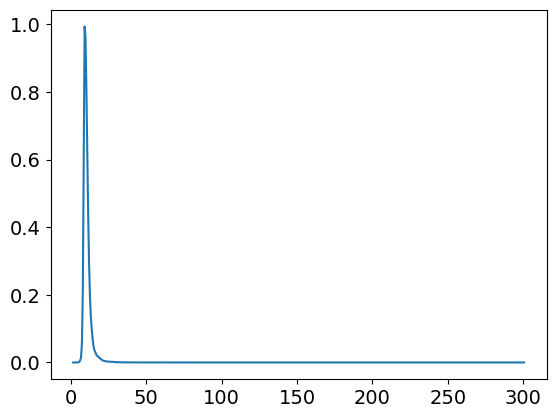

In [1530]:
az.plot_kde(np.array(quotes.loc[(quotes.loc[:, "AvNLL"].isna()==False), "AvNLL"]));

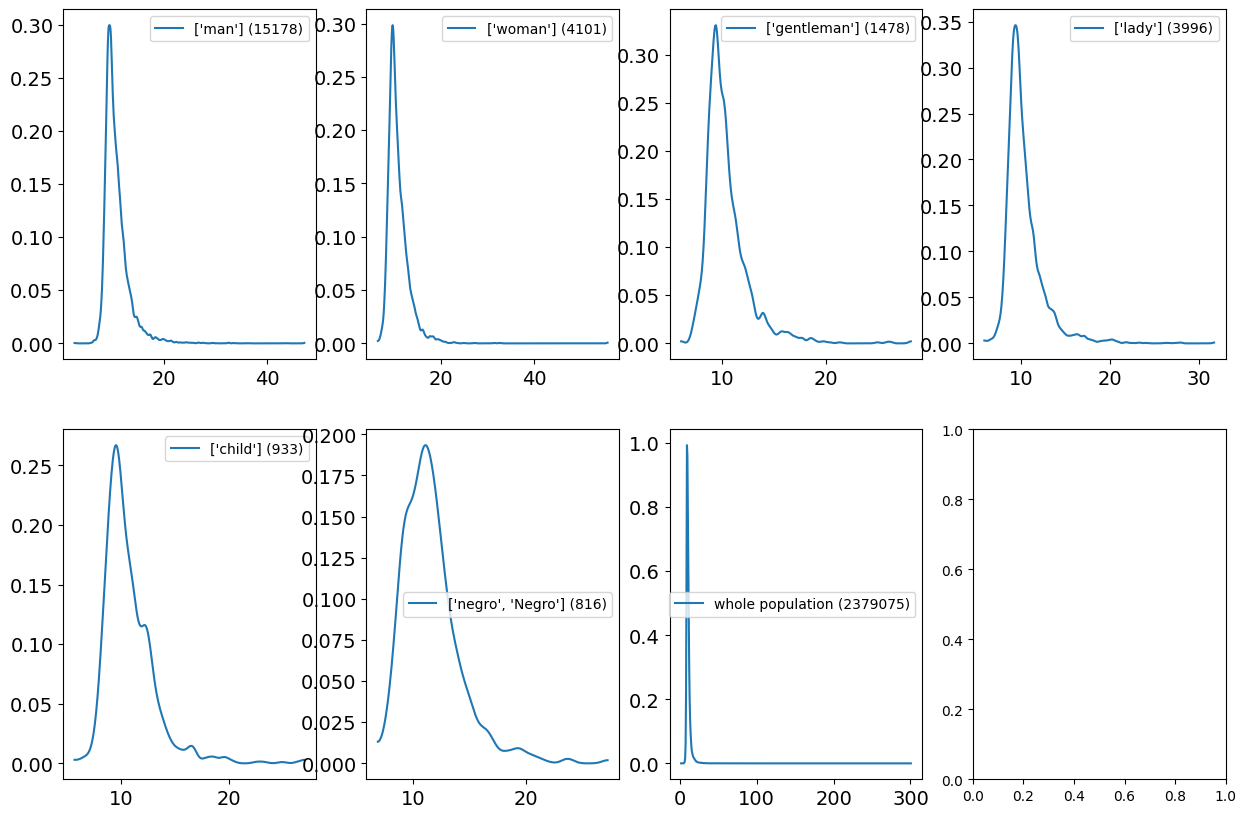

In [1531]:
fig, axs = plt.subplots(2, 4, figsize=(15, 10))
for i, speaker in enumerate([["man"], ["woman"], ["gentleman"], ["lady"], ["child"], ["negro", "Negro"], None]):
    row = i // 4
    col = i - (row)*4
    if speaker != None:
        mask = (quotes.loc[:, "AvNLL"].isna()==False) & (quotes.loc[:, "speaker"].isin(speaker))
        az.plot_kde(np.array(quotes.loc[mask, "AvNLL"]), ax=axs[row, col], label=f"{speaker} ({sum(mask)})");
    else:
        mask = quotes.loc[:, "AvNLL"].isna()==False
        az.plot_kde(np.array(quotes.loc[mask, "AvNLL"]), ax=axs[row, col], label=f"whole population ({sum(mask)})");


### what about the 95% hdi wrt., I scores?

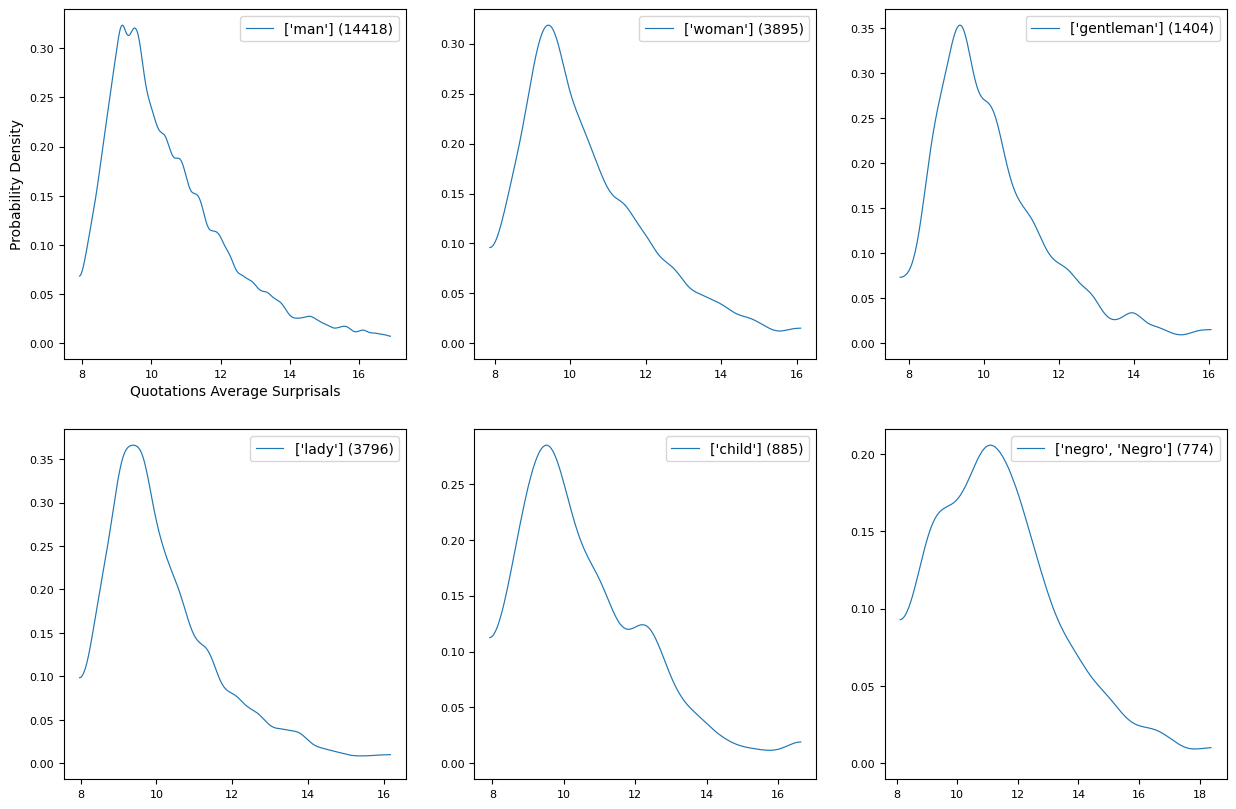

In [1532]:
x,y = 2,3
fig, axs = plt.subplots(x, y, figsize=(15, 10))
# for i, speaker in enumerate([["man"], ["woman"], ["gentleman"], ["lady"], ["child"], ["negro", "Negro"], None]):
for i, speaker in enumerate([["man"], ["woman"], ["gentleman"], ["lady"], ["child"], ["negro", "Negro"]]):

    row = i // y
    col = i - (row)*y
    if speaker != None:
        lb, ub = get_hdi(np.array(quotes.loc[(quotes.loc[:, "AvNLL"].isna()==False) & (quotes.loc[:, "speaker"].isin(speaker)), "AvNLL"]), hdi=0.95)
        mask = (quotes.loc[:, "AvNLL"].isna()==False) & (quotes.loc[:, "AvNLL"] < ub) & (quotes.loc[:, "AvNLL"] > lb) & (quotes.loc[:, "speaker"].isin(speaker))
        az.plot_kde(np.array(quotes.loc[mask, "AvNLL"]), ax=axs[row, col], label=f"{speaker} ({sum(mask)})", textsize=8, );
    else: # whole population
        lb, ub = get_hdi(np.array(quotes.loc[(quotes.loc[:, "AvNLL"].isna()==False), "AvNLL"]), hdi=0.95)
        mask = (quotes.loc[:, "AvNLL"].isna()==False) & (quotes.loc[:, "AvNLL"] < ub) & (quotes.loc[:, "AvNLL"] > lb)
        az.plot_kde(np.array(quotes.loc[mask, "AvNLL"]), ax=axs[row, col], label=f"Whole Population ({sum(mask)})", textsize=8, );

    if row==0 and col==0:
        axs[row, col].set_xlabel("Quotations Average Surprisals")
        axs[row, col].set_ylabel("Probability Density")



est. average ['man'] 10.487431141211333
est. average ['woman'] 10.452210365715997
est. average ['gentleman'] 10.246463854565327
est. average ['lady'] 10.203444341375675
est. average ['child'] 10.579739639811203
est. average ['negro', 'Negro'] 11.484608431108413


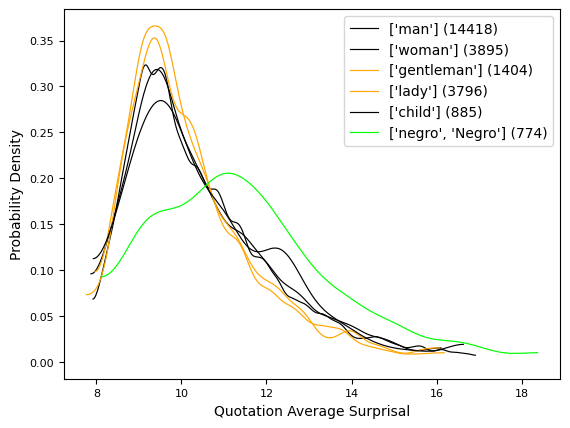

In [1533]:
for i, (speaker, color) in enumerate([(["man"], "black"), (["woman"], "black"), (["gentleman"], "orange"), (["lady"], "orange"), (["child"], "black"), (["negro", "Negro"], "lime")]):

    lb, ub = get_hdi(np.array(quotes.loc[(quotes.loc[:, "AvNLL"].isna()==False) & (quotes.loc[:, "speaker"].isin(speaker)), "AvNLL"]), hdi=0.95)
    mask = (quotes.loc[:, "AvNLL"].isna()==False) & (quotes.loc[:, "AvNLL"] < ub) & (quotes.loc[:, "AvNLL"] > lb) & (quotes.loc[:, "speaker"].isin(speaker))

    az.plot_kde(np.array(quotes.loc[mask, "AvNLL"]), label=f"{speaker} ({sum(mask)})", textsize=8, plot_kwargs={'color':color});
    plt.xlabel("Quotation Average Surprisal")
    plt.ylabel("Probability Density")

    # est. means
    print("est. average", speaker, quotes.loc[mask, "AvNLL"].mean())

In [33]:
# what do the quotations look like by Surprisal?
for i, speaker in enumerate([["negro", "Negro"]]):
    lb, ub = get_hdi(np.array(quotes.loc[(quotes.loc[:, "AvNLL"].isna()==False) & (quotes.loc[:, "speaker"].isin(speaker)), "AvNLL"]), hdi=0.95)
    mask = (quotes.loc[:, "AvNLL"].isna()==False) & (quotes.loc[:, "AvNLL"] < ub) & (quotes.loc[:, "AvNLL"] > lb) & (quotes.loc[:, "speaker"].isin(speaker))

    for s in [8,10,12, 14]:
        lb, ub = s-0.5, s+0.5
        print(speaker)
        print(lb,ub)
        for i in np.random.choice(list(quotes.loc[(mask) & (quotes.loc[:, "AvNLL"]>lb) & (quotes.loc[:, "AvNLL"]<ub), "i"]), size=5):

            surprisals_by_word = []
            
            c = np.array(chains[i])
            q = quotes.loc[i, 'quote']
            s = q[1:-1]
            words = get_words(s)
            tokens = np.array(tokenizer.tokenize(s))
            words_indices, N = get_words_indices(words, tokens)
            
            for word, word_indices in zip(words, words_indices):

                surprisal = -np.log(c[word_indices]).sum()
                surprisals_by_word.append((word, surprisal))

            print(surprisals_by_word)
            print(sum([x[1] for x in surprisals_by_word]) / len(surprisals_by_word))
            print(quotes.loc[i,"AvNLL"])

['negro', 'Negro']
7.5 8.5
[('Pomp', 12.745163377911325), (',', 8.908733680239104), ('my', 8.15487741706939), ('noble', 5.593150393431662), ('fellow', 5.8544982882134375), ('!', 7.8913391301704685)]
8.191293714505896
8.191293714505896
[('FIGHT', 16.985638510026394), (',', 8.962578825330812), ('sar', 6.407307565240219), (';', 9.64040859401201), ('gib', 8.812395329353894), ('dem', 5.034492259117673), ('de', 6.710499551343321), ('chance', 9.172713604895229), (',', 8.715849491588925), ('and', 6.814208233488087), ('den', 5.831951792669897), ('see', 5.717314254535503), ('.', 10.186636565387598)]
8.383999582845352
8.383999582845352
[('Oh', 9.549871054655648), ('!', 7.315758530692469)]
8.432814792674058
8.432814792674058
[('Fight', 9.943859488890746), (',', 9.123350096495201), ('sar', 7.1286821471445965), ('!', 6.315767180190526)]
8.127914728180267
8.127914728180267
[('I', 5.929203704151961), ('am', 8.102990544512906), ('dying', 9.271569865863027), (',', 9.365338636542047), ('colonel', 7.95522

## RQ1

14418 774
man 0.9971772898970794
3895 774
woman 1.0323980653924156
1404 774
gentleman 1.2381445765430854
3796 774
lady 1.2811640897327372
885 774
child 0.9048687912972095


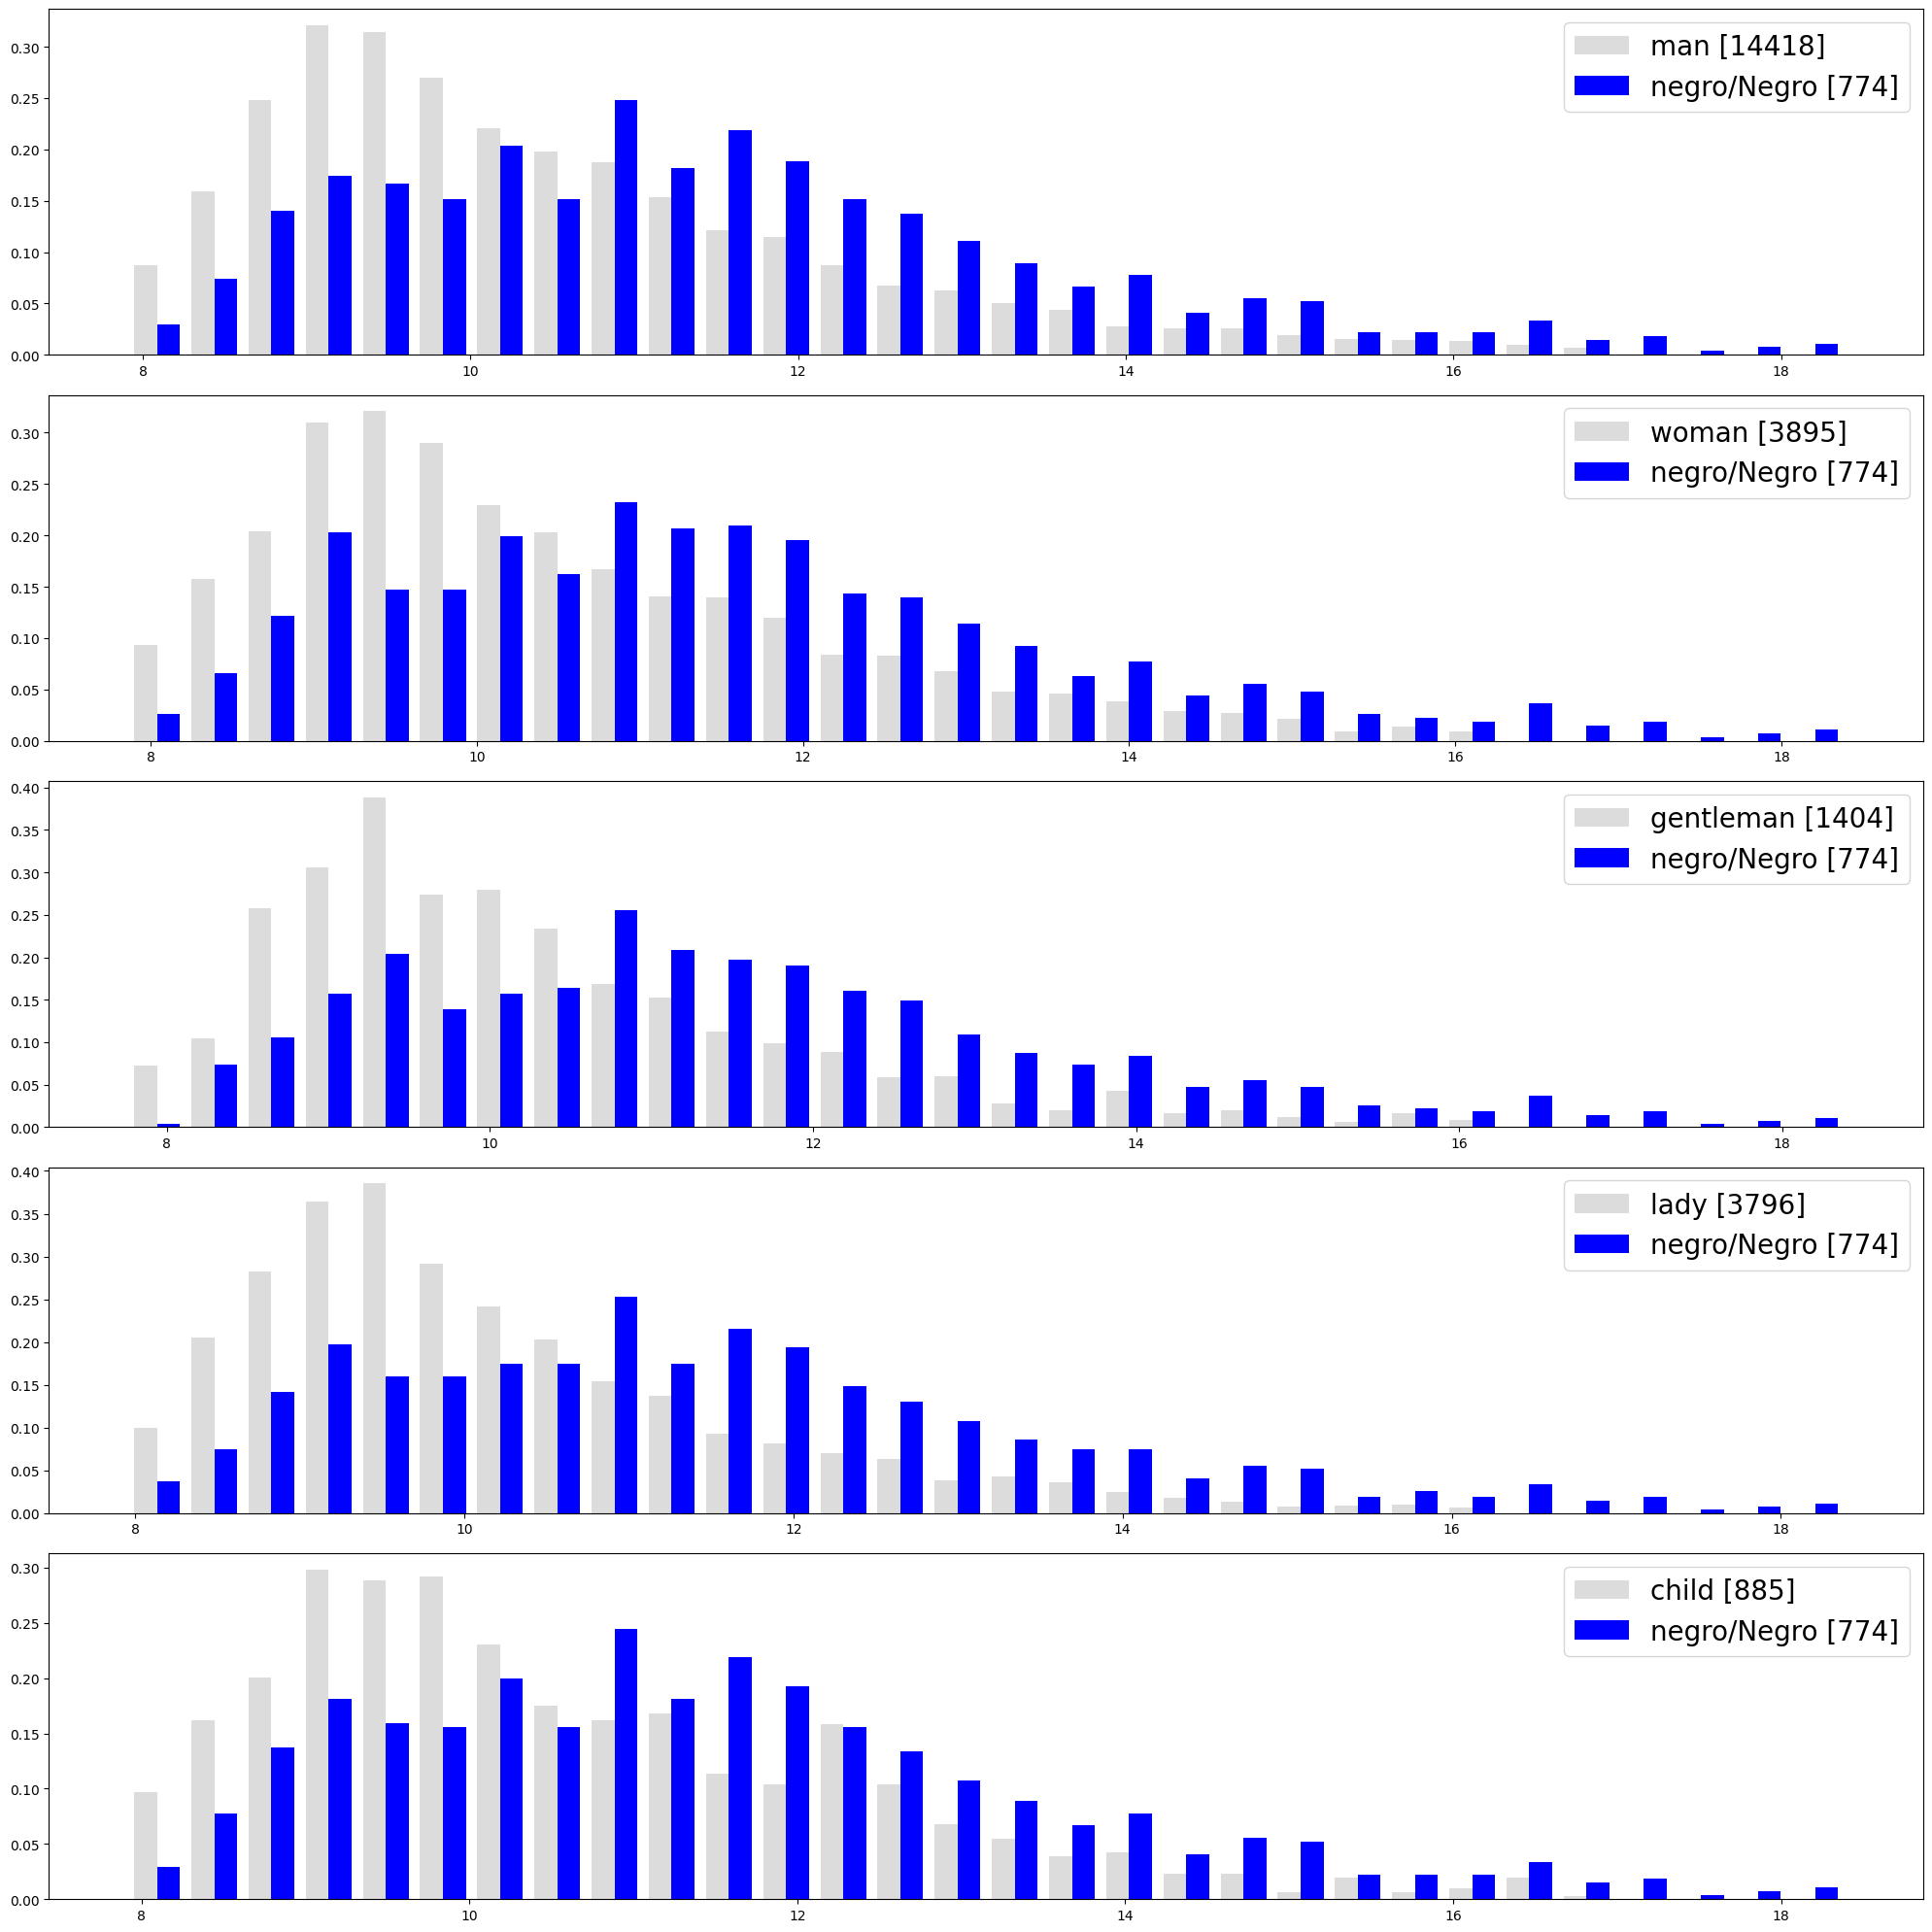

In [1534]:
refs = ['man', 'woman', 'gentleman', 'lady', 'child']
metric = 'AvNLL'
fig, axs = plt.subplots(len(refs), figsize=[20,20])

for i, ref in enumerate(refs):

    r_ = quotes.loc[(quotes.loc[:,'speaker'].isin([ref])==True) & (quotes.loc[:,metric].isna()==False), metric]
    lb, ub = get_hdi(r_, hdi=0.95)
    r = quotes.loc[(quotes.loc[:,'speaker'].isin([ref])==True) & (quotes.loc[:,metric].isna()==False) & (quotes.loc[:,metric] > lb) & (quotes.loc[:,metric] < ub), metric]
    
    c_ = quotes.loc[(quotes.loc[:,'speaker'].isin(['Negro', 'negro'])==True) & (quotes.loc[:,metric].isna()==False), metric]
    lb, ub = get_hdi(c_, hdi=0.95)
    c = quotes.loc[(quotes.loc[:,'speaker'].isin(['Negro', 'negro'])==True) & (quotes.loc[:,metric].isna()==False) & (quotes.loc[:,metric] > lb) & (quotes.loc[:,metric] < ub), metric]

    print(len(r), len(c))

    # https://matplotlib.org/stable/gallery/color/named_colors.html
    axs[i].hist([r, c], density=True, bins=30, label = [f"{ref} [{len(r)}]", f'negro/Negro [{len(c)}]'], color=['gainsboro', 'blue']);
    axs[i].legend(fontsize=20)
    
    print(ref, c.mean() - r.mean())
    
plt.tight_layout()
plt.savefig("RQ1_histogram.jpg")
plt.show()


# Bayesian Analysis

In [1535]:
def estimator(c,r):
    with pm.Model() as model:
       
        ## contentious term
        mu = pm.Normal('mu', 0, 5)
        nu = pm.Exponential('nu', 1)
        sigma = pm.Exponential('sigma', 1)
        pm.StudentT("c", mu=mu, nu=nu, sigma=sigma, observed=c)
        
        ## reference
        mu_ = pm.Normal('mu_', 0, 5)
        nu_ = pm.Exponential('nu_', 1)
        sigma_ = pm.Exponential('sigma_', 1)
        pm.StudentT("r", mu=mu_, nu=nu_, sigma=sigma_, observed=r)
        
        trace=pm.sample()
        
    return model, trace

# def estimator(c,r):
#     with pm.Model() as model:
       
#         ## contentious term
#         mu = pm.Normal('mu', 0, 5)
#         sigma = pm.Exponential('sigma', 1)
#         alpha = pm.Exponential('alpha', 1)
#         pm.SkewNormal("c", mu=mu, sigma=sigma, alpha=alpha, observed=c)
        
#         ## reference
#         mu_ = pm.Normal('mu_', 0, 5)
#         alpha_ = pm.Exponential('alpha_', 1)
#         sigma_ = pm.Exponential('sigma_', 1)
#         pm.SkewNormal("r", mu=mu_, sigma=sigma_, alpha=alpha_, observed=r)
        
#         trace=pm.sample()
        
#     return model, trace
            

In [1536]:
# let's look at the comparative variances of the central 95% ...
for cand in [['man'], ['gentleman'], ['woman'], ['lady'], ['child'], ['Negro', 'negro']]:
    c_ = quotes.loc[(quotes.loc[:,'speaker'].isin(cand)==True) & (quotes.loc[:,metric].isna()==False), metric]
    lb, ub = get_hdi(c_, hdi=0.95)
    c = quotes.loc[(quotes.loc[:,'speaker'].isin(cand)==True) & (quotes.loc[:,metric].isna()==False) & (quotes.loc[:,metric] > lb) & (quotes.loc[:,metric] < ub), metric]
    print(cand, c.std())


['man'] 1.7388449624166982
['gentleman'] 1.5596094824647646
['woman'] 1.682162975934131
['lady'] 1.5116290128380385
['child'] 1.7388545774100765
['Negro', 'negro'] 2.0414751644144093


In [1537]:
X = [['Negro', 'negro'], ['man'], ['woman'], ['gentleman'], ['lady'], ['child']]
for i, cand in enumerate(X[:-1]):
    for ref in X[i+1:]:

        r_ = quotes.loc[(quotes.loc[:,'speaker'].isin(ref)==True) & (quotes.loc[:,metric].isna()==False), metric]
        lb, ub = get_hdi(r_, hdi=0.95)
        r = quotes.loc[(quotes.loc[:,'speaker'].isin(ref)==True) & (quotes.loc[:,metric].isna()==False) & (quotes.loc[:,metric] > lb) & (quotes.loc[:,metric] < ub), metric]
        
        c_ = quotes.loc[(quotes.loc[:,'speaker'].isin(cand)==True) & (quotes.loc[:,metric].isna()==False), metric]
        lb, ub = get_hdi(c_, hdi=0.95)
        c = quotes.loc[(quotes.loc[:,'speaker'].isin(cand)==True) & (quotes.loc[:,metric].isna()==False) & (quotes.loc[:,metric] > lb) & (quotes.loc[:,metric] < ub), metric]
        model, trace = estimator(c, r)
        
        # cohen's D estimate
        mu = trace.posterior['mu'].stack(sample=('chain', 'draw')).to_numpy()  # 1D array, dim=chains * draws
        mu_ = trace.posterior['mu_'].stack(sample=('chain', 'draw')).to_numpy()  # 1D array, dim=chains * draws
        sigma = trace.posterior['sigma'].stack(sample=('chain', 'draw')).to_numpy()  # 1D array, dim=cha4ins * draws
        sigma_ = trace.posterior['sigma_'].stack(sample=('chain', 'draw')).to_numpy()  # 1D array, dim=chains * draws

        print(f"{cand} mean est: {get_hdi(mu, hdi=0.99)}")
        print(f"{ref} mean est: {get_hdi(mu_, hdi=0.99)}")
        # print('Cohen\'s d', ref, cand, get_hdi(cohens_d(mu, mu_, sigma, sigma_), hdi=0.99))
        print('est difference in means', ref, cand, get_hdi(mu - mu_, hdi=0.99))
        print(f'est difference in means as a proportion of ... {cand} mean', ref, cand, get_hdi((mu - mu_) / mu, hdi=0.99))

        # alpha = trace.posterior['alpha'].stack(sample=('chain', 'draw')).to_numpy()  # 1D array, dim=chains * draws
        # print(cand, get_hdi(alpha, hdi=0.99))
        

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, nu, sigma, mu_, nu_, sigma_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


['Negro', 'negro'] mean est: (11.145359371726164, 11.5176754258642)
['man'] mean est: (10.203928476902721, 10.284232838709281)
est difference in means ['man'] ['Negro', 'negro'] (0.8966789929588543, 1.276171848916971)
est difference in means as a proportion of ... ['Negro', 'negro'] mean ['man'] ['Negro', 'negro'] (0.08056656142426653, 0.11086217121045731)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, nu, sigma, mu_, nu_, sigma_]


KeyError: 0

### hmmm. by how much do the the pooled standard variations differ?

In [222]:
for ref in [['man'], ['gentleman'], ['woman'], ['lady'], ['child'], ['negro', 'Negro']]:
# for r in [['negro', 'Negro']]:

    r_ = quotes.loc[(quotes.loc[:,'speaker'].isin(ref)==True) & (quotes.loc[:,metric].isna()==False), metric]
    lb, ub = get_hdi(r_, hdi=0.95)
    r = quotes.loc[(quotes.loc[:,'speaker'].isin(ref)==True) & (quotes.loc[:,metric].isna()==False) & (quotes.loc[:,metric] > lb) & (quotes.loc[:,metric] < ub), metric]

    for cand in [['man'], ['gentleman'], ['woman'], ['lady'], ['child']]:
        
        c_ = quotes.loc[(quotes.loc[:,'speaker'].isin(cand)==True) & (quotes.loc[:,metric].isna()==False), metric]
        lb, ub = get_hdi(c_, hdi=0.95)
        c = quotes.loc[(quotes.loc[:,'speaker'].isin(cand)==True) & (quotes.loc[:,metric].isna()==False) & (quotes.loc[:,metric] > lb) & (quotes.loc[:,metric] < ub), metric]
        
        print(ref, cand, np.sqrt((r.std()**2 + c.std()**2)/2))

['man'] ['man'] 1.7719258361200607
['man'] ['gentleman'] 1.7146113110469126
['man'] ['woman'] 1.7395905541170773
['man'] ['lady'] 1.7085040389271027
['man'] ['child'] 1.71898149573758
['gentleman'] ['man'] 1.7146113110469126
['gentleman'] ['gentleman'] 1.6553134830690674
['gentleman'] ['woman'] 1.6811740169398275
['gentleman'] ['lady'] 1.6489866070682497
['gentleman'] ['child'] 1.659839800085672
['woman'] ['man'] 1.7395905541170773
['woman'] ['gentleman'] 1.6811740169398275
['woman'] ['woman'] 1.7066427345044841
['woman'] ['lady'] 1.6749448284328072
['woman'] ['child'] 1.685630893746253
['lady'] ['man'] 1.7085040389271027
['lady'] ['gentleman'] 1.6489866070682497
['lady'] ['woman'] 1.6749448284328072
['lady'] ['lady'] 1.6426353622611043
['lady'] ['child'] 1.6535302431490797
['child'] ['man'] 1.71898149573758
['child'] ['gentleman'] 1.659839800085672
['child'] ['woman'] 1.685630893746253
['child'] ['lady'] 1.6535302431490797
['child'] ['child'] 1.6643538075381206
['negro', 'Negro'] ['ma

In [215]:
# n-word vs control only
100*(1.82 - 1.75)/1.75

4.0000000000000036

In [217]:
# all RQ1 pooled stdev
100*(1.82 - 1.64)/1.75

10.285714285714294

### glass's delta

In [224]:
for cand in [['man'], ['gentleman'], ['woman'], ['lady'], ['child']]:
    for ref in [['Negro', 'negro']]:

        r_ = quotes.loc[(quotes.loc[:,'speaker'].isin(ref)==True) & (quotes.loc[:,metric].isna()==False), metric]
        lb, ub = get_hdi(r_, hdi=0.95)
        r = quotes.loc[(quotes.loc[:,'speaker'].isin(ref)==True) & (quotes.loc[:,metric].isna()==False) & (quotes.loc[:,metric] > lb) & (quotes.loc[:,metric] < ub), metric]
        
        c_ = quotes.loc[(quotes.loc[:,'speaker'].isin(cand)==True) & (quotes.loc[:,metric].isna()==False), metric]
        lb, ub = get_hdi(c_, hdi=0.95)
        c = quotes.loc[(quotes.loc[:,'speaker'].isin(cand)==True) & (quotes.loc[:,metric].isna()==False) & (quotes.loc[:,metric] > lb) & (quotes.loc[:,metric] < ub), metric]
        model, trace = estimator(c, r)
        
        # cohen's D estimate
        mu = trace.posterior['mu'].stack(sample=('chain', 'draw')).to_numpy()  # 1D array, dim=chains * draws
        mu_ = trace.posterior['mu_'].stack(sample=('chain', 'draw')).to_numpy()  # 1D array, dim=chains * draws
        sigma = trace.posterior['sigma'].stack(sample=('chain', 'draw')).to_numpy()  # 1D array, dim=chains * draws
        sigma_ = trace.posterior['sigma_'].stack(sample=('chain', 'draw')).to_numpy()  # 1D array, dim=chains * draws
        print("Glass's d", ref, cand, get_hdi(glass_delta(mu_, mu, sigma_), hdi=0.99))
        

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, nu, sigma, mu_, nu_, sigma_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


Glass's d ['Negro', 'negro'] ['man'] (-0.5676510081847974, -0.34525550547661393)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, nu, sigma, mu_, nu_, sigma_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


Glass's d ['Negro', 'negro'] ['gentleman'] (-0.663220113515467, -0.40199732154427736)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, nu, sigma, mu_, nu_, sigma_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


Glass's d ['Negro', 'negro'] ['woman'] (-0.5449077190993171, -0.3113233524224895)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, nu, sigma, mu_, nu_, sigma_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


Glass's d ['Negro', 'negro'] ['lady'] (-0.597454073398002, -0.3647986517442432)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, nu, sigma, mu_, nu_, sigma_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


Glass's d ['Negro', 'negro'] ['child'] (-0.573395998131116, -0.30017288276183446)


## RQ2 

### Assemble df, Q

In [18]:
# load the quotes
with open("../LOC/tuples_news.json", "r") as f:
    tuples_news = json.load(f)

In [19]:
# load the chains
with open("../LOC/chains_1.6B_news.json", "r") as f:
    chains_news = json.load(f)

In [626]:
quotes_news = [q for url, (q,m,s) in tuples_news]
display(quotes_news[:5])


["Hit only cost me a string er fish ter git married, jedge, but, please God, I'd give a whale ter git rid er her.",
 'I hopes dis teaches me a lesson.',
 "There's a dog under them steps, an' he's shore mad.",
 "Gimme that gun quick. I'll kill him,",
 "I came for Mr. Ivans's close."]

In [612]:
# load the LOC quotes chains
display(len(chains_news))

1524

In [613]:
get_words("how's it going?")

["how's", 'it', 'going', '?']

In [627]:
# add N to quotes
word_counts = []
for quote in quotes_news:
    N = len(get_words(quote))
    word_counts.append(N)

In [628]:
# add NLL to quotes
AvNLL = []
for i, n in tqdm(enumerate(word_counts)):
    AvNLL.append(-np.log(chains_news[i]).sum()/n)

1524it [00:00, 89106.16it/s]


In [629]:
Q_news: pd.DataFrame = pd.DataFrame({"quote":quotes_news, "N":word_counts, "AvNLL":AvNLL})

In [630]:
Q_news['i'] = list(range(len(Q_news)))

### let's look at examples ...

In [631]:
display(Q_news.loc[2,"quote"])
display(Q_news.loc[2,"N"])

"There's a dog under them steps, an' he's shore mad."

12

### let's look at the spead

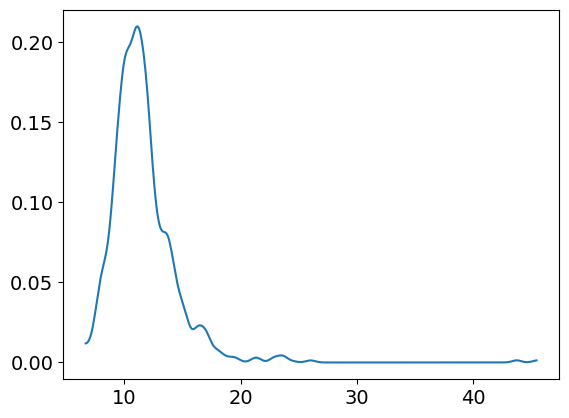

In [632]:
az.plot_kde(np.array(Q_news.loc[:, "AvNLL"]));

### let's look at the spread of 95%

1446

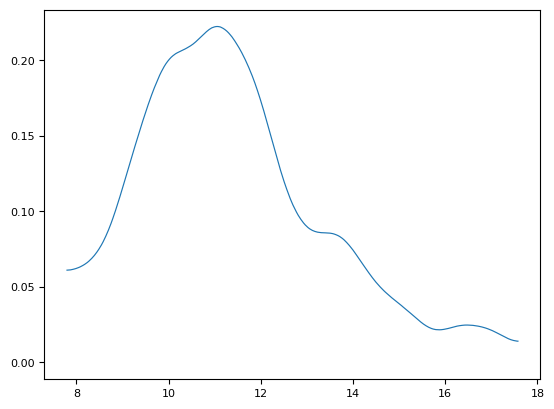

In [752]:
lb, ub = get_hdi(np.array(Q_news.loc[:, "AvNLL"]), hdi=0.95)
mask = ((Q_news.loc[:, "AvNLL"] < ub) & (Q_news.loc[:, "AvNLL"] > lb))
az.plot_kde(np.array(Q_news.loc[mask, "AvNLL"]), textsize=8, );
sum(mask)

In [757]:
### fit estimate the central tendency ... 
metric = "AvNLL"

lb, ub = get_hdi(np.array(Q_news.loc[:, "AvNLL"]), hdi=0.95)
mask = ((Q_news.loc[:, "AvNLL"] < ub) & (Q_news.loc[:, "AvNLL"] > lb))
news = Q_news.loc[mask, metric]

lit_ = quotes.loc[(quotes.loc[:,'speaker'].isin(['negro', 'Negro'])==True) & (quotes.loc[:,metric].isna()==False), metric]
lb, ub = get_hdi(lit_, hdi=0.95)
lit = quotes.loc[(quotes.loc[:,'speaker'].isin(['negro', 'Negro'])==True) & (quotes.loc[:,metric].isna()==False) & (quotes.loc[:,metric] > lb) & (quotes.loc[:,metric] < ub), metric]

model, trace = estimator(lit, news)

# cohen's D estimate
mu_lit = trace.posterior['mu'].stack(sample=('chain', 'draw')).to_numpy()  # 1D array, dim=chains * draws
sigma_lit = trace.posterior['sigma'].stack(sample=('chain', 'draw')).to_numpy()  # 1D array, dim=chains * draws
mu_news = trace.posterior['mu_'].stack(sample=('chain', 'draw')).to_numpy()  # 1D array, dim=chains * draws
sigma_news = trace.posterior['sigma_'].stack(sample=('chain', 'draw')).to_numpy()  # 1D array, dim=chains * draws
get_hdi((mu_news - mu_lit) / mu_lit, hdi=0.99)
# get_hdi(glass_delta(mu_lit, mu_news, sigma_lit), 0.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, nu, sigma, mu_, nu_, sigma_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


(-0.02645469056697198, 0.01573394497527655)

Sampling: [c, r]


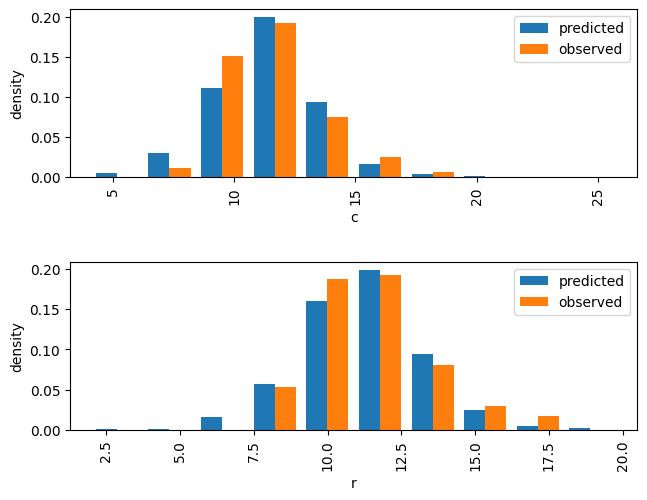

In [754]:
plot_posterior_predictive_overlay(model, trace);

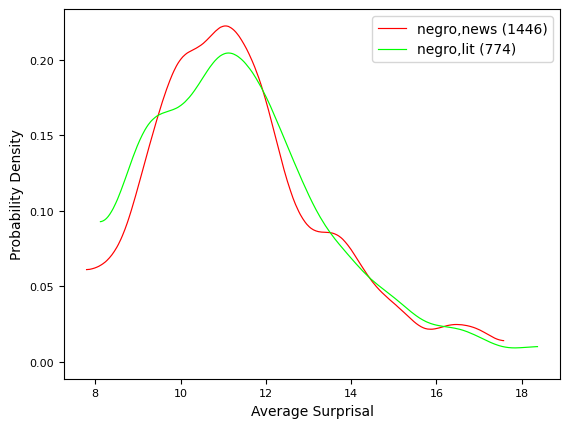

In [794]:
# plot

lb, ub = get_hdi(np.array(Q_news.loc[:, "AvNLL"]), hdi=0.95)
mask = ((Q_news.loc[:, "AvNLL"] < ub) & (Q_news.loc[:, "AvNLL"] > lb))
news = list(Q_news.loc[mask, metric])
az.plot_kde(np.array(news), label=f"negro,news ({len(news)})", textsize=8, plot_kwargs={'color':"red"})


lit_ = quotes.loc[(quotes.loc[:,'speaker'].isin(['negro', 'Negro'])==True) & (quotes.loc[:,metric].isna()==False), metric]
lb, ub = get_hdi(lit_, hdi=0.95)
lit = list(quotes.loc[(quotes.loc[:,'speaker'].isin(['negro', 'Negro'])==True) & (quotes.loc[:,metric].isna()==False) & (quotes.loc[:,metric] > lb) & (quotes.loc[:,metric] < ub), metric])
az.plot_kde(np.array(lit), label=f"negro,lit ({len(lit)})", textsize=8, plot_kwargs={'color':"lime"})

plt.ylabel("Probability Density")
plt.xlabel("Average Surprisal")
plt.savefig("RQ2_overlaid")
plt.show()


In [755]:
display(lit.mean())
display(lit.std())

11.488999713230495

2.041724815179362

In [756]:
display(news.mean())
display(news.std())

11.410466500729017

1.9872700280215068

## RQ3: How do the surprisal contributions look by word ?


### get the surprisals by word (lit)

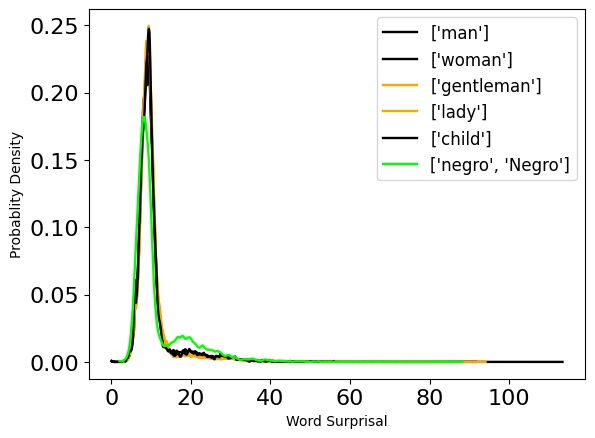

In [1538]:
# for i, speaker in enumerate([["man"], ["woman"], ["gentleman"], ["lady"], ["child"], ["negro", "Negro"], None]):
metric = "AvNLL"
# plt.figure(figsize=(7.5, 7.5))
# plt.minorticks_on()
# plt.grid(which='both', linestyle='--', linewidth=0.5)
for j, (speakers, color) in enumerate([(["man"], "black"), (["woman"], "black"), (["gentleman"], "orange"), (["lady"], "orange"), (["child"], "black"), (["negro", "Negro"], "lime")]):
    
    # get the quotes 'i' of interest
    r_ = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,metric].isna()==False), metric]
    lb, ub = get_hdi(r_, hdi=0.95)
    i_of_interest = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,metric].isna()==False) & (quotes.loc[:,metric] > lb) & (quotes.loc[:,metric] < ub), 'i']
    
    surprisals = []
    for i in i_of_interest:
        try:
            c = np.array(chains[i])
            q = quotes.loc[i, 'quote']
            s  = q[1:-1]
            words = get_words(s)
            tokens = np.array(tokenizer.tokenize(s))
            words_indices, N = get_words_indices(words, tokens)
        
            for word, word_indices in zip(words, words_indices):
                surprisals.append([word, -np.log(c[word_indices]).sum()])
        except:
            pass
            
    surprisals = sorted(surprisals, key = lambda x: x[1], reverse=True)
    az.plot_kde(np.array([x[1] for x in surprisals]), label=f"{speakers}", textsize=16, plot_kwargs={'color':color});
plt.legend(fontsize=12) #, loc='upper left', frameon=True, facecolor='lightgray', edgecolor='black')
plt.ylabel("Probablity Density", )
plt.xlabel("Word Surprisal")
plt.savefig("RQ1_word_level_overlay")



### Get surprisals by word (negro,lit vs negro,news)

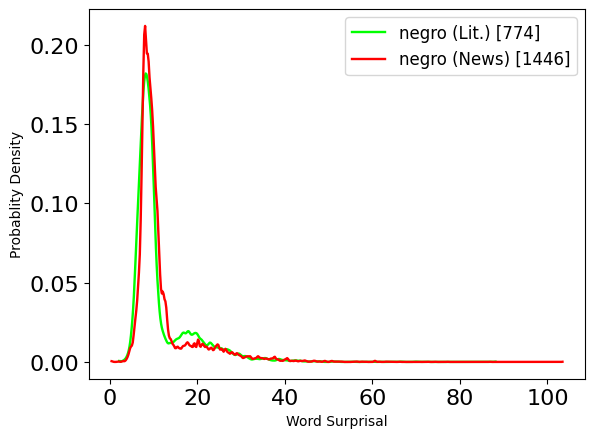

In [804]:
# for i, speaker in enumerate([["man"], ["woman"], ["gentleman"], ["lady"], ["child"], ["negro", "Negro"], None]):
metric = "AvNLL"
# plt.figure(figsize=(7.5, 7.5))
# plt.minorticks_on()
# plt.grid(which='both', linestyle='--', linewidth=0.5)

# ------
# negro, lit 
# ------

speakers, color = (["negro", "Negro"], "lime")
    
# get the quotes 'i' of interest
r_ = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,metric].isna()==False), metric]
lb, ub = get_hdi(r_, hdi=0.95)
i_of_interest = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,metric].isna()==False) & (quotes.loc[:,metric] > lb) & (quotes.loc[:,metric] < ub), 'i']

surprisals = []
for i in i_of_interest:
    try:
        c = np.array(chains[i])
        q = quotes.loc[i, 'quote']
        s  = q[1:-1]
        words = get_words(s)
        tokens = np.array(tokenizer.tokenize(s))
        words_indices, N = get_words_indices(words, tokens)
    
        for word, word_indices in zip(words, words_indices):
            surprisals.append([word, -np.log(c[word_indices]).sum()])
    except:
        pass
        
surprisals = sorted(surprisals, key = lambda x: x[1], reverse=True)
az.plot_kde(np.array([x[1] for x in surprisals]), label=f"negro (Lit.) [{len(i_of_interest)}]", textsize=16, plot_kwargs={'color':color});

# ------
# negro, news
# ------

# get 'i' of interest
lb, ub = get_hdi(np.array(Q_news.loc[:, "AvNLL"]), hdi=0.95)
mask = ((Q_news.loc[:, "AvNLL"] < ub) & (Q_news.loc[:, "AvNLL"] > lb))
i_of_interest = Q_news.loc[mask, 'i']

color = 'red'

# get surprisals over words
surprisals_ = []
for i in i_of_interest:
    c = np.array(chains_news[i])
    q = Q_news.loc[i, 'quote']
    s  = q
    words = get_words(s)
    tokens = np.array(tokenizer.tokenize(s))
    try:
        words_indices, N = get_words_indices(words, tokens)
        for word, word_indices in zip(words, words_indices):
            surprisals_.append([word, -np.log(c[word_indices]).sum()])
    except:
        pass
        
surprisals_ = sorted(surprisals_, key = lambda x: x[1], reverse=True)
az.plot_kde(np.array([x[1] for x in surprisals_]), label=f"negro (News) [{len(i_of_interest)}]", textsize=16, plot_kwargs={'color':color});


plt.legend(fontsize=12) #, loc='upper left', frameon=True, facecolor='lightgray', edgecolor='black')
plt.ylabel("Probablity Density", )
plt.xlabel("Word Surprisal")
plt.savefig("RQ2_word_level_overlay")

Let's take a look at the n-word, lit quoations split into quotaiton Surprisal Bands ... do we observe ...

In [875]:
def values_to_probabilty_density(d:list, bins = 100):
    """ Return (bin_centres: np.ndarry, bin_probability: np.ndarray) tuple for a list of values, d.
    """

    # establish bin width, bin centres, and boundaries
    bin_width = (max(d) - min(d)) / (bins - 1)
    centres = np.array([min(d) + i*bin_width for i in range(bins)])
    lb = centres - bin_width/2
    ub = centres + bin_width/2

    # get counts in each bin
    counts = np.array([0]*len(centres))
    for value in d:
        counts += ((value >= lb) & (value < ub))

    # convert to density
    density = counts / counts.sum()

    return centres, density
        
# test
get_density([1,1,1.1,2, 2,3,4, 5,5,5], 5)

(array([1., 2., 3., 4., 5.]), array([0.3, 0.2, 0.1, 0.1, 0.3]))

198
309
175
65
22


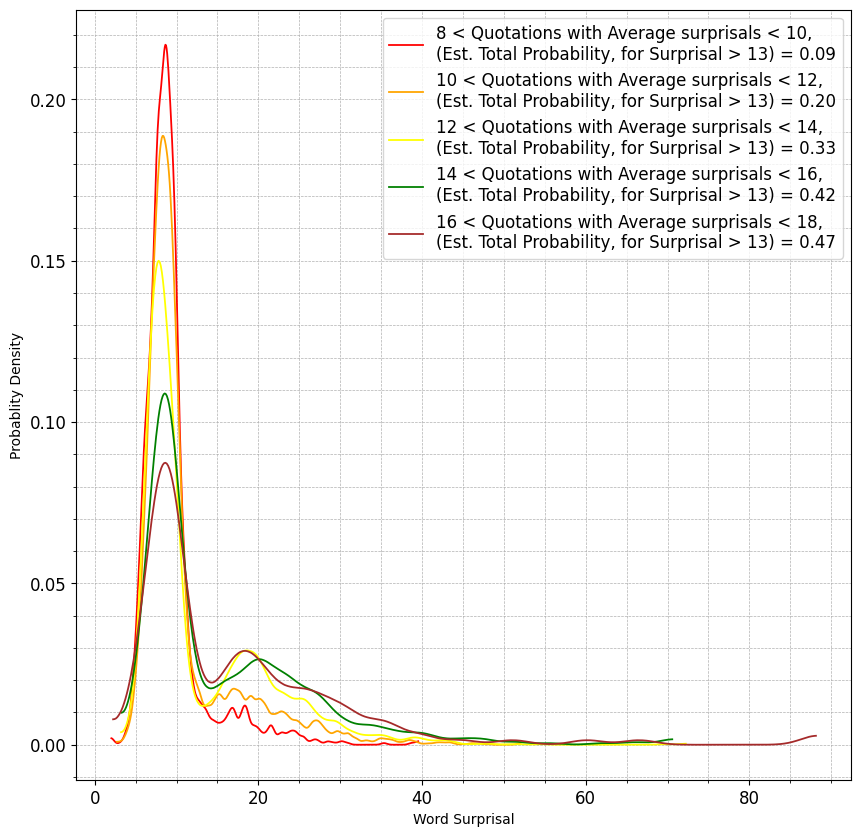

In [904]:
# fig, axs = plt.subplots(2, 3, figsize=(15, 10))

plt.figure(figsize=(10, 10))
plt.minorticks_on()
plt.grid(which='both', linestyle='--', linewidth=0.5)

colours = ['red', 'orange', 'yellow', 'green', 'brown', 'indigo', 'violet']

metric = "AvNLL"
for j, (speakers, color) in enumerate([(["negro", "Negro"], "lime")]):
    
    # get the quotes 'i' of interest
    r_ = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,metric].isna()==False), metric]
    lb, ub = get_hdi(r_, hdi=0.95)

    # consider bands of Quotation Average Surprisals ... 
for k, band_lb in enumerate(range(8,18,2)):
        band_ub = band_lb+2
        i_of_interest = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,metric].isna()==False) & (quotes.loc[:,metric] > lb) & (quotes.loc[:,metric] >= band_lb) & (quotes.loc[:,metric] < ub)& (quotes.loc[:,metric] < band_ub), 'i']
        print(len(i_of_interest))
        
        surprisals = []
        for i in i_of_interest:
            try:
                c = np.array(chains[i])
                q = quotes.loc[i, 'quote']
                s  = q[1:-1]
                words = get_words(s)
                tokens = np.array(tokenizer.tokenize(s))
                words_indices, N = get_words_indices(words, tokens)
            
                for word, word_indices in zip(words, words_indices):
                    surprisals.append([word, -np.log(c[word_indices]).sum()])
            except:
                pass
                
        surprisals = sorted(surprisals, key = lambda x: x[1], reverse=True)

        # estimate the total probability between 13 and 30 ... 
        C, P = get_density([x[1] for x in surprisals], 100)
        area = sum([p for c,p in zip(C,P) if c>13])


        # # plot
        # row = k // 3
        # col = k - (row)*3
        # az.plot_kde(np.array([x[1] for x in surprisals]), label=f"{speakers}, \n{(band_lb, band_ub)},\n{area:.2f}", textsize=16, ax=axs[row, col]);

        az.plot_kde(np.array([x[1] for x in surprisals]), label=f"{band_lb} < Quotations with Average surprisals < {band_ub},\n(Est. Total Probability, for Surprisal > 13) = {area:.2f}", textsize=12, plot_kwargs={'color':colours[k]});
    
plt.legend(fontsize=12) #, loc='upper left', frameon=True, facecolor='lightgray', edgecolor='black')
plt.ylabel("Probablity Density", )
plt.xlabel("Word Surprisal")
plt.savefig("RQ3_word surprisal by quotations surprisal bands")
plt.show()


what proportion of out of dictionary words are present in each of these bands?

get words greater than surprisal of 13

In [731]:
of_interest = []
seen = set()

for speakers in [["man"], ["woman"], ["gentleman"], ["lady"], ["child"], ["negro", "Negro"]]:

    # get the quotes 'i' of interest
    r_ = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False), "AvNLL"]
    lb, ub = get_hdi(r_, hdi=0.95)
    i_of_interest = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False) & (quotes.loc[:,"AvNLL"] > 13) & (quotes.loc[:,"AvNLL"] < 40), 'i']

    for i in i_of_interest:
        try:
            
            c = np.array(chains[i])
            q = quotes.loc[i, 'quote']
            s  = q[1:-1]
            words = get_words(s)
            
            tokens = np.array(tokenizer.tokenize(s))
            words_indices, N = get_words_indices(words, tokens)
        
            for word, word_indices in zip(words, words_indices):
                surprisal = -np.log(c[word_indices]).sum()
                if surprisal > 13 and word not in seen:
                    of_interest.append((word, s))
                    seen.add(word) 
        except:
            pass

with open("over13.json", "w") as f:
    json.dump(of_interest, f)

#### News Negro vs Literature Negro

## RQ3: Average Surprisal contribution by *class* of eye - dialect

generally useful functions ...

In [89]:
def gen_indices(reference:list[str], find: list[str])->typing.Generator:
    """ Return the slice lb and ub of the 'reference' array, that share the same elements of the 'find' array
    """
    for i in range(len(reference) - len(find)+1):
        if reference[i:i+len(find)] == find:
            yield (i,i+len(find))

In [300]:
def find_all_indices(word, substring):
    indices = []
    start = 0
    while True:
        start = word.find(substring, start)
        if start == -1:
            break
        indices.append(start)
        start += len(substring)  # Move past the last found index
    return indices

In [306]:
find_all_indices("forthwith", "th")

[3, 7]

mean Average Surprisals of Observed Data

In [1539]:
quotes['words'] = quotes['quote'].progress_map(lambda q: get_words(q[1:-1]))


100%|███████████████████████████████████████████████████| 2379076/2379076 [01:05<00:00, 36127.87it/s]


## Regularisation of Irregular verbs

In [1147]:
regularised_irregular = set(["ised", "hased", "shalled", "beed", "haved", "getted", "seed", "knowed", "finded", "taked", "doesed", "becomed", "comed", "understanded", "choosed", "growed", "bringed", "beginnned", "writed", "builded", "speaked", "forgetted", "sended", "throwed", "maked", "goed", "thinked", "readed", "keeped", "gived", "sayed", "buyed", "holded", "dealed", "falled", "spended", "runned", "breaked", "rised", "standed", "leaded", "meeted", "springed", "rided", "shooted", "eated", "beated", "sleeped", "drawed", "sitted", "winned", "drinked", "feeded", "seeked", "striked", "hurted", "swimmed", "sinked", "swinged", "stealed", "fighted", "mistaked", "bended", "bited", "bidded"])


#### n-word,lit vs normative,lit

In [1287]:
quotes['irregular_verbs'] = quotes['words'].progress_map(lambda words: [word for word in words if word in regularised_irregular])
quotes['irregular_verbs_count'] = quotes['irregular_verbs'].progress_map(lambda words: len(words))


100%|█████████████████████████████████████████████████| 2379076/2379076 [00:01<00:00, 2029435.10it/s]


In [1288]:
quotes.loc[quotes.loc[:, "irregular_verbs_count"]>0, 'quote']

2909       "I seed yo' ma yestiddy en she sutney wuz look...
7026       "Not when he's knowed you like I have! I'll ge...
9966       "That's Benson ahead of us, off yonder where y...
9990                       "I allow you knowed the general?"
9992       "He was right smart of a man in his day, and o...
                                 ...                        
2378495    "I didn' knowed but Miss Grac'ella mought a to...
2378508    "Dey wuz a rickety ole table settin' in de mid...
2378721    "He didn't live hyuh, suh; I used ter live hyu...
2378925    "It's as dange'ous as a gun, and a gun is dang...
2379073    "Well, suh, after you went away the enthusiasm...
Name: quote, Length: 4280, dtype: object

rates

In [1289]:
variation = "irregular_verbs"
for speakers in [["negro", "Negro"], ["man"], ["woman"], ["gentleman"], ["lady"], ["child"]]:

    # get 95\% HDI
    r_ = quotes.loc[(df.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False), "AvNLL"]
    lb, ub = get_hdi(r_, hdi=0.95)
    i_of_interest = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False) & (df.loc[:,"AvNLL"] > lb) & (quotes.loc[:,"AvNLL"] < ub), 'i']

    word_count = quotes.loc[i_of_interest, "N"].sum()
    var_count = quotes.loc[(quotes.loc[:, "i"].isin(i_of_interest)) , f'{variation}_count'].sum()
    
    print(speakers, 100*var_count / word_count, var_count, word_count)
    

['negro', 'Negro'] 0.0896422459457257 11 12271
['man'] 0.012192376950780312 26 213248
['woman'] 0.041962443612966395 24 57194
['gentleman'] 0.0 0 22035
['lady'] 0.006176652254478073 4 64760
['child'] 0.028190189813944746 3 10642


contribution to AvNLL difference

100%|█████████████████████████████████████████████████████████| 5200/5200 [00:00<00:00, 13369.47it/s]


negro,Negro 11.417817649479787 11.416268597371822
['man'] 0.11583284841257446
['woman'] 0.011835829986138418
['gentleman'] 0.1400320187127463
['lady'] 0.09804263549266887
['child'] -0.08158164223021826
['man', 'woman', 'child'] 0.08625432278150606
['gentleman', 'lady'] 0.10837951045384121


/opt/homebrew/lib/python3.11/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


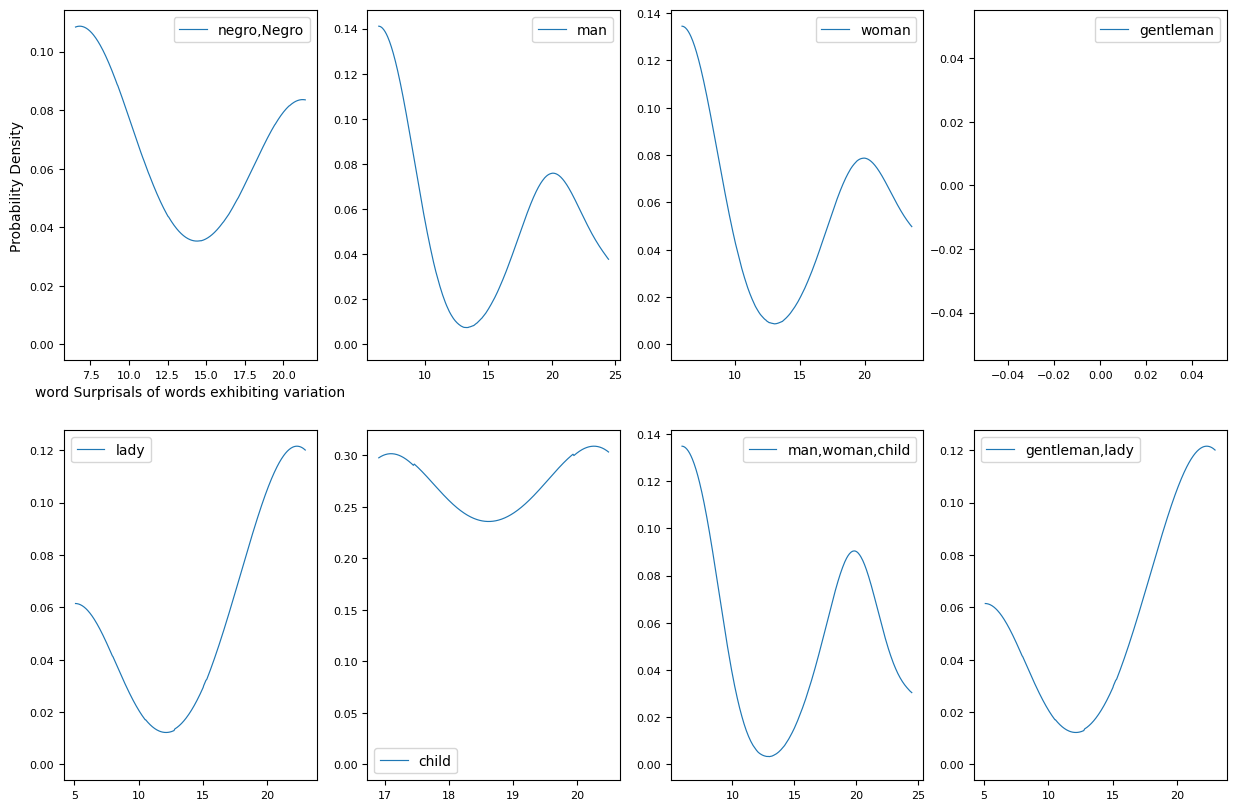

In [1290]:
variation = "irregular_verbs"
surprisals = defaultdict(list)  # {speakers: list of surprisals (each corresponding to a word demonstrating the variation)}

# get the surprisals ... 
S = [["negro", "Negro"], ["man"], ["woman"], ["gentleman"], ["lady"], ["child"], ["man", "woman", "child"], ["gentleman", "lady", ]]
for speakers in S:
    
    # get the quotation set, 'i' of interest
    r_ = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False), "AvNLL"]
    lb, ub = get_hdi(r_, hdi=0.95)
    i_of_interest = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False) & (quotes.loc[:,"AvNLL"] > lb) & (quotes.loc[:,"AvNLL"] < ub), 'i']

    count_all
    for i in tqdm(i_of_interest):

        try:

            # get probability chain corresponding to quote
            c = np.array(chains[i])
            
            q = quotes.loc[i, 'quote']
            s  = q[1:-1]
            
            # convert quote to words           
            words = quotes.loc[i, 'words']

            tokens = np.array(tokenizer.tokenize(s))
            words_indices, N = get_words_indices(words, tokens)

            if quotes.loc[i, f"{variation}_count"] > 0:
                
                for instance in quotes.loc[i, variation]:

                    # the instance may occur multiple times
                    for lb, ub in gen_indices(words, get_words(instance)):

                        # add surprisals for each word in the instance
                        for i in range(lb,ub):
                        
                            word_indices = words_indices[i]  # token and chain indices corresponding to word
                            surprisals[",".join(speakers)].append(-np.log(c[word_indices]).sum())

                    # check
                    # print(instance)
                    
        except:
            if len(quotes.loc[i, variation]) > 0:
                # print(q)
                pass

# Get the MAS and newMAS for n-word, where newMAS due to the absence of words showing the variation in question
speakers = ['negro', "Negro"]
r_ = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False), "AvNLL"]
lb, ub = get_hdi(r_, hdi=0.95)
i_of_interest = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False) & (quotes.loc[:,"AvNLL"] > lb) & (quotes.loc[:,"AvNLL"] < ub), 'i']

MAS_negro = quotes.loc[i_of_interest, "sumNLL"].sum() / quotes.loc[i_of_interest, "N"].sum()
newMAS_negro = (quotes.loc[i_of_interest, "sumNLL"].sum() - sum(surprisals['negro,Negro'])) / (quotes.loc[i_of_interest, "N"].sum() - len(surprisals['negro,Negro']))
print('negro,Negro', MAS_negro, newMAS_negro)

# get importance:
for speakers in S[1:]:
    
    r_ = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False), "AvNLL"]
    lb, ub = get_hdi(r_, hdi=0.95)
    i_of_interest = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False) & (quotes.loc[:,"AvNLL"] > lb) & (quotes.loc[:,"AvNLL"] < ub), 'i']

    MAS = quotes.loc[i_of_interest, "sumNLL"].sum() / quotes.loc[i_of_interest, "N"].sum()
    newMAS = (quotes.loc[i_of_interest, "sumNLL"].sum() - sum(surprisals[",".join(speakers)])) / (quotes.loc[i_of_interest, "N"].sum() - len(surprisals[",".join(speakers)]))
    
    importance = 100*((MAS_negro - newMAS_negro) - (MAS - newMAS)) / (MAS_negro - MAS)
    print(speakers, importance)

# get plots of collected Surprisals
x,y = 2,4
fig, axs = plt.subplots(x, y, figsize=(15, 10))
for i, speakers in enumerate(S):

    row = i // y
    col = i - (row)*y
    az.plot_kde(np.array(surprisals[",".join(speakers)]), ax=axs[row, col], label=",".join(speakers), textsize=8, );

    if row==0 and col==0:
        axs[row, col].set_xlabel("word Surprisals of words exhibiting variation")
        axs[row, col].set_ylabel("Probability Density")


let's take a random sample, and explore the effect on whole quotation probabilities from 'correction' not 'removal'

In [1159]:
sample = [(q[1:-1],q[1:-1])  for q in np.random.choice(quotes.loc[quotes.loc[:,'irregular_verbs_count'] == 1, "quote"], size=50)]
with open("sample_irregular_verbs.json", "w") as f:
    json.dump(sample, f)

## Non--standard contractions (elision)

In [1571]:
# load unix dict
with open("/usr/share/dict/words", "r") as f:
    en_words = [x.strip("\n") for x in f.readlines()]

# extra
en_words.append("shan't")

# Load the CMU pronunciation dictionary
import requests
lines = requests.get("http://svn.code.sf.net/p/cmusphinx/code/trunk/cmudict/cmudict-0.7b").text.splitlines()

# add in CMU instances
en_words += [line.split(" ")[0].lower() for line in lines] + [line.split(" ")[0].lower().capitalize() for line in lines]
en_words = set(en_words)

#### n-word,lit vs normative,lit

In [1573]:
# get the elision instances: i.e., words containing apostrophes, not recognised as 'standard contractions' and not possessive
def interesting_apos(word:str)->bool:
    
    if word.count("'") - word[-2:].count("'s") - word[-2:].count("'d") - word[-3:].count("'ll") - word[1:3].count("'[A-Z]") > 0 and word!="ma'am" and word!="Ma'am" and not (word[0]=="'" and word[-1]=="'") and len(word)>1 and '-' not in word:
        return True
    else:
        return False


quotes['elision'] = quotes['words'].progress_map(lambda words: [word for word in words if word not in en_words and interesting_apos(word)])
quotes['elision_count'] = quotes['elision'].progress_map(lambda words: len(words))

100%|█████████████████████████████████████████████████| 2379076/2379076 [00:00<00:00, 2473607.67it/s]


In [1574]:
quotes.loc[(quotes.loc[:, 'elision_count']>0) & (quotes.loc[:, 'speaker'].isin(['negro', "Negro"])), "elision"]


2909                                              [yo', an']
20797                                                  [an']
21338                                                 ['pon]
35992      [tol', an', an', sep'rate, an', an', an', an',...
44354                                                  [an']
                                 ...                        
2266096                                      ['speck, roun']
2267577                                   [sut'n'y, sut'n'y]
2313038                                                [Mo']
2371695                       [She'm, sinkin', she'm, un'er]
2374848                                             ['Pears]
Name: elision, Length: 243, dtype: object

relative rates

In [1575]:
variation = "elision"
for speakers in [["negro", "Negro"], ["man"], ["woman"], ["gentleman"], ["lady"], ["child"]]:

    # get 95\% HDI
    r_ = quotes.loc[(df.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False), "AvNLL"]
    lb, ub = get_hdi(r_, hdi=0.95)
    i_of_interest = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False) & (df.loc[:,"AvNLL"] > lb) & (quotes.loc[:,"AvNLL"] < ub), 'i']

    word_count = quotes.loc[i_of_interest, "N"].sum()
    var_count = quotes.loc[(quotes.loc[:, "i"].isin(i_of_interest)) , f'{variation}_count'].sum()
    
    
    print(speakers, 100*var_count / word_count, var_count, word_count)
    

['negro', 'Negro'] 3.950154748330347 485 12278
['man'] 1.229951785889993 2625 213423
['woman'] 1.5199692511967573 870 57238
['gentleman'] 0.3856274385264495 85 22042
['lady'] 0.3380359954311117 219 64786
['child'] 0.6953580154106371 74 10642


contributions to difference in AvNLL

100%|█████████████████████████████████████████████████████████| 5200/5200 [00:00<00:00, 16794.40it/s]


negro,Negro 11.411308061310187 10.849801037397384
['man'] 41.31633898138373
['woman'] 37.69610035621399
['gentleman'] 46.293430648293494
['lady'] 43.24384964480168
['child'] 49.9919357333402
['man', 'woman', 'child'] 40.87843605769047
['gentleman', 'lady'] 44.00920003172824


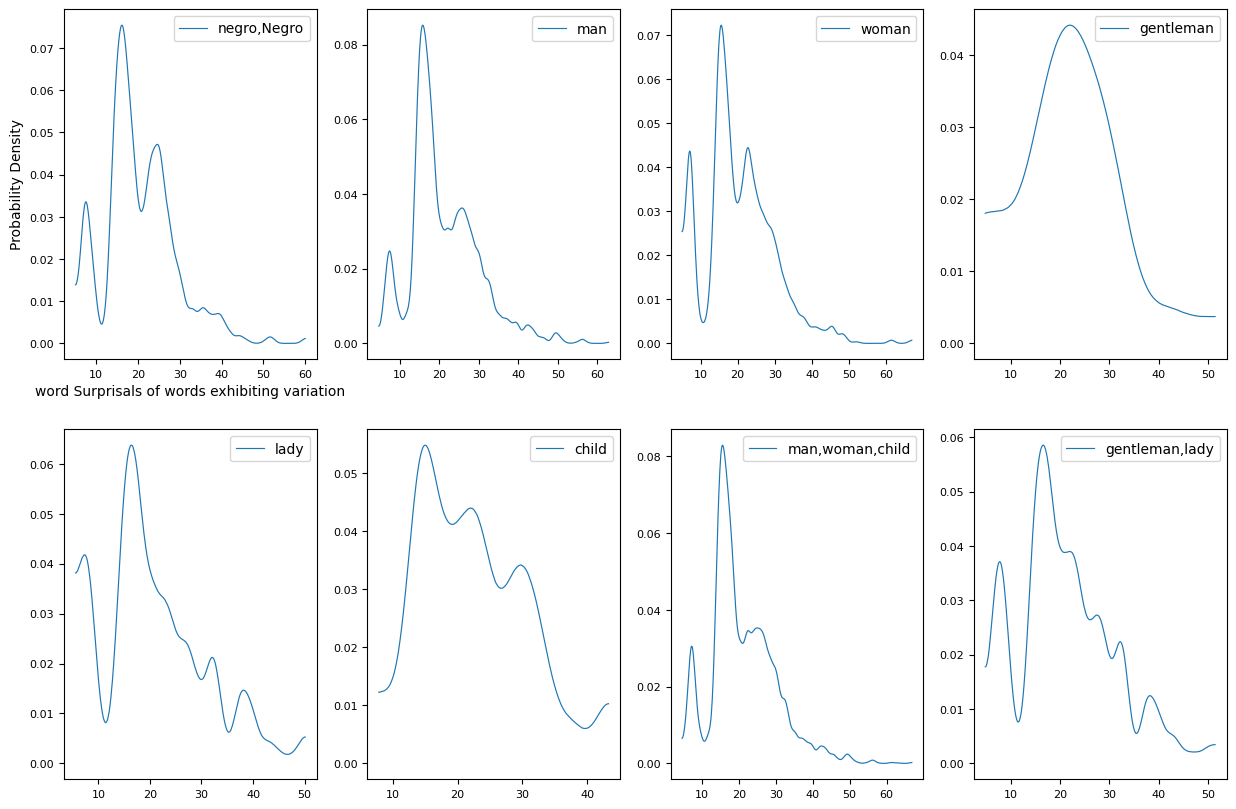

In [1576]:
variation = "elision"
surprisals = defaultdict(list)  # {speakers: list of surprisals (each corresponding to a word demonstrating the variation)}
corresponding_instance = defaultdict(list)

# get the surprisals ... 
S = [["negro", "Negro"], ["man"], ["woman"], ["gentleman"], ["lady"], ["child"], ["man", "woman", "child"], ["gentleman", "lady", ]]
for speakers in S:
    
    # get the quotation set, 'i' of interest
    r_ = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False), "AvNLL"]
    lb, ub = get_hdi(r_, hdi=0.95)
    i_of_interest = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False) & (quotes.loc[:,"AvNLL"] > lb) & (quotes.loc[:,"AvNLL"] < ub), 'i']

    
    for i in tqdm(i_of_interest):

        try:

            # get probability chain corresponding to quote
            c = np.array(chains[i])
            
            q = quotes.loc[i, 'quote']
            s  = q[1:-1]
            
            # convert quote to words           
            words = quotes.loc[i, 'words']

            tokens = np.array(tokenizer.tokenize(s))
            words_indices, N = get_words_indices(words, tokens)

            if quotes.loc[i, f"{variation}_count"] > 0:
                
                for instance in quotes.loc[i, variation]:

                    # the instance may occur multiple times
                    for lb, ub in gen_indices(words, get_words(instance)):

                        # add surprisals for each word in the instance
                        for i in range(lb,ub):
                        
                            word_indices = words_indices[i]  # token and chain indices corresponding to word
                            surprisals[",".join(speakers)].append(-np.log(c[word_indices]).sum())
                            corresponding_instance[",".join(speakers)].append(instance)

                    # check
                    # print(instance)
                    
        except:
            if len(quotes.loc[i, variation]) > 0:
                # print(q)
                pass

# Get the MAS and newMAS for n-word, where newMAS due to the absence of words showing the variation in question
speakers = ['negro', "Negro"]
r_ = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False), "AvNLL"]
lb, ub = get_hdi(r_, hdi=0.95)
i_of_interest = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False) & (quotes.loc[:,"AvNLL"] > lb) & (quotes.loc[:,"AvNLL"] < ub), 'i']

MAS_negro = quotes.loc[i_of_interest, "sumNLL"].sum() / quotes.loc[i_of_interest, "N"].sum()
newMAS_negro = (quotes.loc[i_of_interest, "sumNLL"].sum() - sum(surprisals['negro,Negro'])) / (quotes.loc[i_of_interest, "N"].sum() - len(surprisals['negro,Negro']))
print('negro,Negro', MAS_negro, newMAS_negro)

# get importance:
for speakers in S[1:]:
    
    r_ = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False), "AvNLL"]
    lb, ub = get_hdi(r_, hdi=0.95)
    i_of_interest = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False) & (quotes.loc[:,"AvNLL"] > lb) & (quotes.loc[:,"AvNLL"] < ub), 'i']

    MAS = quotes.loc[i_of_interest, "sumNLL"].sum() / quotes.loc[i_of_interest, "N"].sum()
    newMAS = (quotes.loc[i_of_interest, "sumNLL"].sum() - sum(surprisals[",".join(speakers)])) / (quotes.loc[i_of_interest, "N"].sum() - len(surprisals[",".join(speakers)]))
    
    importance = 100*((MAS_negro - newMAS_negro) - (MAS - newMAS)) / (MAS_negro - MAS)
    print(speakers, importance)

# get plots of collected Surprisals
x,y = 2,4
fig, axs = plt.subplots(x, y, figsize=(15, 10))
for i, speakers in enumerate(S):

    row = i // y
    col = i - (row)*y
    az.plot_kde(np.array(surprisals[",".join(speakers)]), ax=axs[row, col], label=",".join(speakers), textsize=8, );

    if row==0 and col==0:
        axs[row, col].set_xlabel("word Surprisals of words exhibiting variation")
        axs[row, col].set_ylabel("Probability Density")


In [1579]:
# what's instances are still present at less than Surprisal==13
s = ",".join(["negro", "Negro"])
for instance, surprisal in zip(corresponding_instance[s], surprisals[s]):
    if surprisal < 13:
        print(instance, surprisal)

'im 7.304202094025286
habin' 7.225109871367805
Don' 8.401565530792407
Don' 8.662067523590776
an' 7.2177947036265
an' 6.548912273720899
an' 7.1177201868899855
an' 6.580008527981531
b'lief 5.190146388100896
h'yar 9.4615392172327
Don' 8.401565530792407
Don' 8.662067523590776
Mahs' 7.480538896616719
Mahs' 8.004579379860061
an' 7.2177947036265
an' 6.548912273720899
an' 7.1177201868899855
an' 6.580008527981531
Mahs' 7.480538896616719
Mahs' 8.004579379860061
keepin' 7.878616751049616
breakin' 7.500243467546708
'jected 6.8246281155245905
marryin' 9.145397573749957
an' 7.2177947036265
an' 6.548912273720899
an' 7.1177201868899855
an' 6.580008527981531
Mahs' 7.480538896616719
Mahs' 8.004579379860061
an' 7.2177947036265
an' 6.548912273720899
an' 7.1177201868899855
an' 6.580008527981531
gittin' 7.087993914086905
an' 7.2177947036265
an' 6.548912273720899
an' 7.1177201868899855
an' 6.580008527981531
Mahs' 7.480538896616719
Mahs' 8.004579379860061
don' 5.504978011569464
an' 10.245700665067181
yo' 11.9

let's take a random sample, and explore the elevated contextual surprisal due to the variation, not captured by removal of the variation alone.

In [1556]:
sample_i = [i  for i in np.random.choice(quotes.loc[quotes.loc[:,'elision_count'] == 1, "i"], size=60)]
sample = [(q[1:-1], q[1:-1], el, i) for i, (q, el) in quotes.loc[sample_i, ["quote", "elision"]].iterrows()]
sample_fn = "sample_elision.json"
with open(sample_fn, "w") as f:
    json.dump(sample, f)

# we correct, then we estimate of mAS for corrected, which gives us the basis of an error margin of our estimate from removing variant only.

In the earlier RQs we measure difference between speaker, based on overal difference in mAS of quotation distributions.
We then remove surprisals for each variation, to measure its influence on the former. i.e., how much of the difference is explained.

But this ignores any contextual effects, and leads to the natural questions of "what influence the variation has on context", and what's the error of our RQ3 analysis?
How do we answer this? Well, take a large sample size, and for this sample size we can estimate the mAS(orignal, context) and mAS(corrected, context) over the sample size
; we can compare this to mAS(original) - mAS'(original, var); i.e., the latter estimates the absolute shift in mAS on removing the variation, the former is the absolute shift due to context ripples only, how do they compare?

method: A) for each quotation, capture i) mAS(corrected, context only); ii) mAS(original); iii) mAS'(original, var)
        B) we report the ratio: (\mean_{quotations} mAS'(orignal, var) - mAS(corrected, context only)/(\mean_{quotations} mAS(original) - mAS'(original, var))
           this ratio is an estimate of the reduction in mean AvNLL due context vs due to removal of the variance



In [1543]:
X = [
    ["S'p't investment went up", "That investment went up", "S'p't"],
    ["The dag was walking", "The dog was walking", "dag"],
    ["The dog was wa'king", "The dog was walking", "wa'king"],
]

for original, correction, v in X:

    chains = get_chains([original, correction], tokenizer, GPTmodel)
    chain_o = np.array(chains[0])
    chain_c = np.array(chains[1])
    
    words_o = get_words(original)
    words_c = get_words(correction)
    
    tokens_o = tokenizer.tokenize(original)
    tokens_c = tokenizer.tokenize(correction)
    
    words_indices_o, N_o = get_words_indices(words_o, tokens_o)
    words_indices_c, N_c = get_words_indices(words_c, tokens_c)

    # get context indices for original
    context_indices_o = set()
    for context_chunk in original.split(v):
        for lb, ub in gen_indices(words_o, get_words(context_chunk.strip())):
            context_indices_o.update(range(lb,ub))
    context_indices_o = np.array(sorted(list(context_indices_o)))

    # get context indices for correction
    context_indices_c = set()
    for context_chunk in original.split(v):
        for lb, ub in gen_indices(words_c, get_words(context_chunk.strip())):
            context_indices_c.update(range(lb,ub))
    context_indices_c = np.array(sorted(list(context_indices_c)))

    print(original)
    print('\t',[(words_o[i], -np.log(chain_o[words_indices_o[i]]).sum()) for i in range(len(words_o))])
    print('\t', -np.log(chain_o).sum() / len(words_o))
    print('\t',[(words_o[i], -np.log(chain_o[words_indices_o[i]]).sum()) for i in context_indices_o])
    print('\t',sum([-np.log(chain_o[words_indices_o[i]]).sum() for i in context_indices_o]) / len(context_indices_o))
    print('\t',[(words_c[i], -np.log(chain_c[words_indices_c[i]]).sum()) for i in context_indices_c])
    print('\t',sum([-np.log(chain_c[words_indices_c[i]]).sum() for i in context_indices_c]) / len(context_indices_c))

# what do we see? 
# obviously GPT is only affected by 

S'p't investment went up
	 [("S'p't", 35.373882), ('investment', 7.232523), ('went', 11.1412735), ('up', 7.848941)]
	 15.399155616760254
	 [('investment', 7.232523), ('went', 11.1412735), ('up', 7.848941)]
	 8.740912437438965
	 [('investment', 7.003496), ('went', 11.983417), ('up', 8.410299)]
	 9.132404009501139
The dag was walking
	 [('The', 11.934254), ('dag', 13.254358), ('was', 8.881604), ('walking', 10.644817)]
	 11.17875862121582
	 [('The', 11.934254), ('was', 8.881604), ('walking', 10.644817)]
	 10.486891746520996
	 [('The', 11.934254), ('was', 8.856996), ('walking', 10.509218)]
	 10.433489163716635
The dog was wa'king
	 [('The', 11.934254), ('dog', 7.4901567), ('was', 8.856996), ("wa'king", 37.80121)]
	 16.520652770996094
	 [('The', 11.934254), ('dog', 7.4901567), ('was', 8.856996)]
	 9.427135308583578
	 [('The', 11.934254), ('dog', 7.4901567), ('was', 8.856996)]
	 9.427135308583578


In [1544]:
def get_chains(spans: list[str], tokenizer, model):
    """
    get the chained probabilities wrt., each span, i.e.: torch.tensor([P(w1), P(w2|w1), P(w3|w1,w2), ...])
    """
    # encode the spans
    spans_ids = [tokenizer.encode(span) for span in spans]

    # add padding
    max_length = max([len(span_ids) for span_ids in spans_ids])
    pad_token_id = tokenizer.eos_token_id
    input_ids = torch.tensor(
        [
            span_ids + [pad_token_id] * (max_length - len(span_ids))
            for span_ids in spans_ids
        ]
    )

    # create attention mask
    attention_mask = torch.tensor(
        [
            [0 if token_id == pad_token_id else 1 for token_id in span_ids]
            for span_ids in input_ids
        ]
    )

    # get the chained proababilities
    with torch.no_grad():

        logits = model(input_ids=input_ids, attention_mask=attention_mask).logits
        # logits.shape = (|batch size|, |tokens|, |vocab|)

        probs = F.softmax(logits, dim=-1).cpu()  # transfer to gpu

        chains = [
            [probs[i][j][id_] for j, id_ in enumerate(span_ids)]
            for i, span_ids in enumerate(spans_ids)
        ]

    return chains

sample_fn = "sample_elision_annotated.json"
with open(sample_fn, "r") as f:
    samples = json.load(f)

# for each quotatation, get the following ... 
mAS_original_context_only = []
mAS_corrected_context_only = []
mAS_original = []

for original_quote, corrected_quote, instance, i in samples:

    chains_ = get_chains([original_quote, corrected_quote], tokenizer, GPTmodel)
    chain_original = np.array(chains_[0])
    chain_corrected = np.array(chains_[1])

    original_words = get_words(original_quote)
    original_tokens = tokenizer.tokenize(original_quote)
    original_words_indices, N_o = get_words_indices(original_words, original_tokens)
    
    corrected_words = get_words(corrected_quote)
    corrected_tokens = tokenizer.tokenize(corrected_quote)
    corrected_words_indices, N_c = get_words_indices(corrected_words, corrected_tokens)

    ## get the indices of the context words in the corrected quote
    context_indices_for_corrected = set()
    for context_chunk in original_quote.split(instance[0]):
        for lb, ub in gen_indices(corrected_words, get_words(context_chunk)):
            context_indices_for_corrected.update(range(lb,ub))
    context_indices_for_corrected = np.array(sorted(list(context_indices_for_corrected)))

    ## get the indices of the context words in the original quote
    context_indices_for_original = set()
    for context_chunk in original_quote.split(instance[0]):
        for lb, ub in gen_indices(original_words, get_words(context_chunk.strip())):
            context_indices_for_original.update(range(lb,ub))
    context_indices_for_original = np.array(sorted(list(context_indices_for_original)))

    # get the statistics
    try:
        mAS_original.append(-np.log(chain_original).sum() / len(original_words))
        mAS_original_context_only.append(sum([-np.log(chain_original[original_words_indices[i]]).sum() for i in context_indices_for_original])/ len(context_indices_for_original))
        mAS_corrected_context_only.append(sum([-np.log(chain_corrected[corrected_words_indices[i]]).sum() for i in context_indices_for_corrected])/ len(context_indices_for_corrected))
    except:
        pass

# az.plot_kde(np.array(diffs))

In [1545]:
display(get_hdi(mAS_original, hdi=0.95))

(9.596534729003906, 16.145928955078126)

In [1546]:
display(get_hdi(mAS_original_context_only, hdi=0.95))

(7.693529309829077, 14.547884353399276)

In [1547]:
display(get_hdi(mAS_corrected_context_only, hdi=0.95))

(7.572154313325883, 15.245118244886372)

In [1548]:
list(zip(mAS_original_context_only, mAS_corrected_context_only))

[(9.69655890691848, 9.805164405277797),
 (10.046766971019988, 10.078933284637776),
 (9.449467744146075, 9.531984380313329),
 (12.248982677459717, 12.239812068939209),
 (11.709310045429305, 11.84266632678462),
 (11.56644107555521, 11.577729570454565),
 (11.596032070076983, 11.68710674410281),
 (8.87414132224189, 8.717837280697292),
 (10.347848951816559, 10.279268443584442),
 (9.488270935259367, 9.156556631389417),
 (10.147552103609652, 10.443493804416141),
 (14.537277340888977, 14.293922543525696),
 (13.762525007128716, 13.864722892642021),
 (10.420585866834296, 10.996182793476542),
 (11.62550162467636, 11.63380409288807),
 (10.950587211511074, 10.886283703339405),
 (9.491092150027935, 9.61038376734807),
 (10.255251850400652, 10.31624174118042),
 (12.019613829526035, 12.16087933260985),
 (11.631564994191015, 11.69671034997748),
 (11.56455348519718, 11.909629092496985),
 (10.138989857264928, 10.138989857264928),
 (11.413550567626952, 11.521664047241211),
 (11.355440241949898, 11.31729264

In [1550]:
### point estimate (%)
100*(sum(mAS_original_context_only)-sum(mAS_corrected_context_only))/(sum(mAS_original) - sum(mAS_original_context_only))

-14.681927745342616

In [1555]:
# Bootstrapping to represent error
bootstrapped = []
for _ in range(1000):
    n=len(mAS_original)
    mAS_original_ = np.random.choice(mAS_original, 50)
    mAS_original_context_only_ = np.random.choice(mAS_original_context_only, n)
    mAS_corrected_context_only_ = np.random.choice(mAS_corrected_context_only, n)
    bootstrapped.append(100*(sum(mAS_original_context_only_)-sum(mAS_corrected_context_only_))/(sum(mAS_original_) - sum(mAS_original_context_only_)))

get_hdi(bootstrapped, hdi=0.95)

(-30.92354148028087, 14.764911843314954)

/var/folders/n9/04fxpc3d4dn4s513dwth10b80000gn/T/ipykernel_31332/1163604720.py:4: RuntimeWarning: invalid value encountered in scalar divide
  x.append(ideal / proxy)


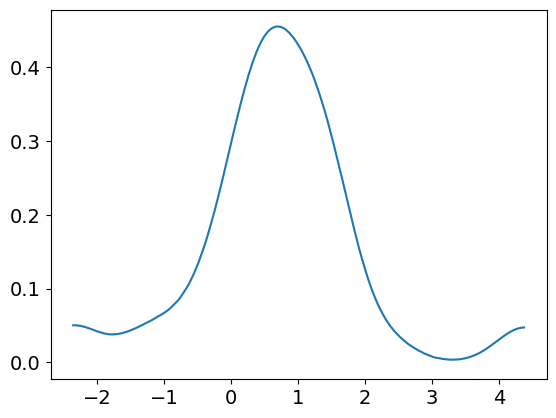

In [1328]:
diffs = [x for x in diffs if x!=False]
x = []
for ideal, proxy in diffs:
    x.append(ideal / proxy)

az.plot_kde(np.array(x));

## aux verbs (Be, Have, Do) conjugation normalised to third person singular

In [1098]:
nlp = spacy.load("en_core_web_sm")
from spacy import displacy

In [1130]:
doc = nlp("I isn't tall")
{token.text: token.head.text for token in doc if is_reg_aux(token)}

{'I': 'is'}

In [1135]:
def is_reg_aux(token):
    if token.text in ['I', 'you', 'You', 'we', 'We', 'they', 'They'] and token.head.text == 'is':
        return True
    else:
        return False

for speakers in [["negro", "Negro"], ["man"], ["woman"], ["gentleman"], ["lady"], ["child"]]:

     # get the quotation set, 'i' of interest
    r_ = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False), "AvNLL"]
    lb, ub = get_hdi(r_, hdi=0.95)
    i_of_interest = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False) & (quotes.loc[:,"AvNLL"] > lb) & (quotes.loc[:,"AvNLL"] < ub), 'i']

    quotes.loc[i_of_interest, 'levellings_aux'] = quotes.loc[i_of_interest,'quote'].progress_map(lambda quote: [token.text + " " + token.head.text for token in nlp(quote[1:-1]) if is_reg_aux(token)])
    quotes.loc[i_of_interest,'levellings_aux_count'] = quotes.loc[i_of_interest,"levellings_aux"].progress_map(lambda x: len(x))



100%|█████████████████████████████████████████████████████████| 885/885 [00:00<00:00, 1288427.30it/s]


In [1140]:
for q in quotes.loc[(quotes.loc[:,'levellings_aux_count']>0) & (quotes.loc[:,'speaker'].isin(['Negro', 'negro'])), 'quote']:
    print(q)

"I'se sorry to part with ye, Kurnel, but I bless de Lord you is gwine. We'll meet again one of dese days, whar de Rebs won't trouble us, and whar we will be free foreber,"
"scuse me fur int'ruptin', but I can't help it. Don' you go, an ax an ole man like me if I tinks dat ole miss went away cos you was comin' an' if it's my true b'lief dat she'll neber come back while you is h'yar. Don' ask me nuffin like dat, Mahs' Junius. Ise libed in dis place all my bawn days, an' I ain't neber done nuffin to you, Mahs' Junius, 'cept keepin' you from breakin' you neck when you was too little to know better. I neber 'jected to you marryin' any lady you like bes', an' 'tain't f'ar Mahs' Junius, now Ise ole an' gittin' on de careen, fur you to ax me wot I tinks about ole miss gwine away an' comin' back. I begs you, Mahs' Junius, don' ax me dat."
"You is one of us,"
"I was back. An honest man as I is, can't get on in this world. Necessity makes rascals of better men than me, Mr. Fitzgerald. Mr. Krone (

In [1137]:
variation = "levellings_aux"
for speakers in [["negro", "Negro"], ["man"], ["woman"], ["gentleman"], ["lady"], ["child"]]:

    # get 95\% HDI
    r_ = quotes.loc[(df.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False), "AvNLL"]
    lb, ub = get_hdi(r_, hdi=0.95)
    i_of_interest = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False) & (df.loc[:,"AvNLL"] > lb) & (quotes.loc[:,"AvNLL"] < ub), 'i']

    word_count = quotes.loc[i_of_interest, "N"].sum()
    var_count = quotes.loc[(quotes.loc[:, "i"].isin(i_of_interest)) , f'{variation}_count'].sum()
    
    print(speakers, 100*var_count / word_count, var_count, word_count)
    

['negro', 'Negro'] 0.09779154103170076 12.0 12271
['man'] 0.015474939975990396 33.0 213248
['woman'] 0.03671713816134559 21.0 57194
['gentleman'] 0.009076469253460404 2.0 22035
['lady'] 0.004632489190858555 3.0 64760
['child'] 0.03758691975192633 4.0 10642


contribution to difference in mean AvNLL

100%|█████████████████████████████████████████████████████████| 5200/5200 [00:00<00:00, 13027.95it/s]


negro,Negro 11.417817649479787 11.421315614802674
['man'] -0.371956889104945
['woman'] -0.33289259846343666
['child'] -0.32960078496393935
['gentleman'] -0.3162108898936165
['lady'] -0.29875335908049033
['man', 'woman', 'child'] -0.36188001539212383
['gentleman', 'lady'] -0.3031568461369973


/opt/homebrew/lib/python3.11/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


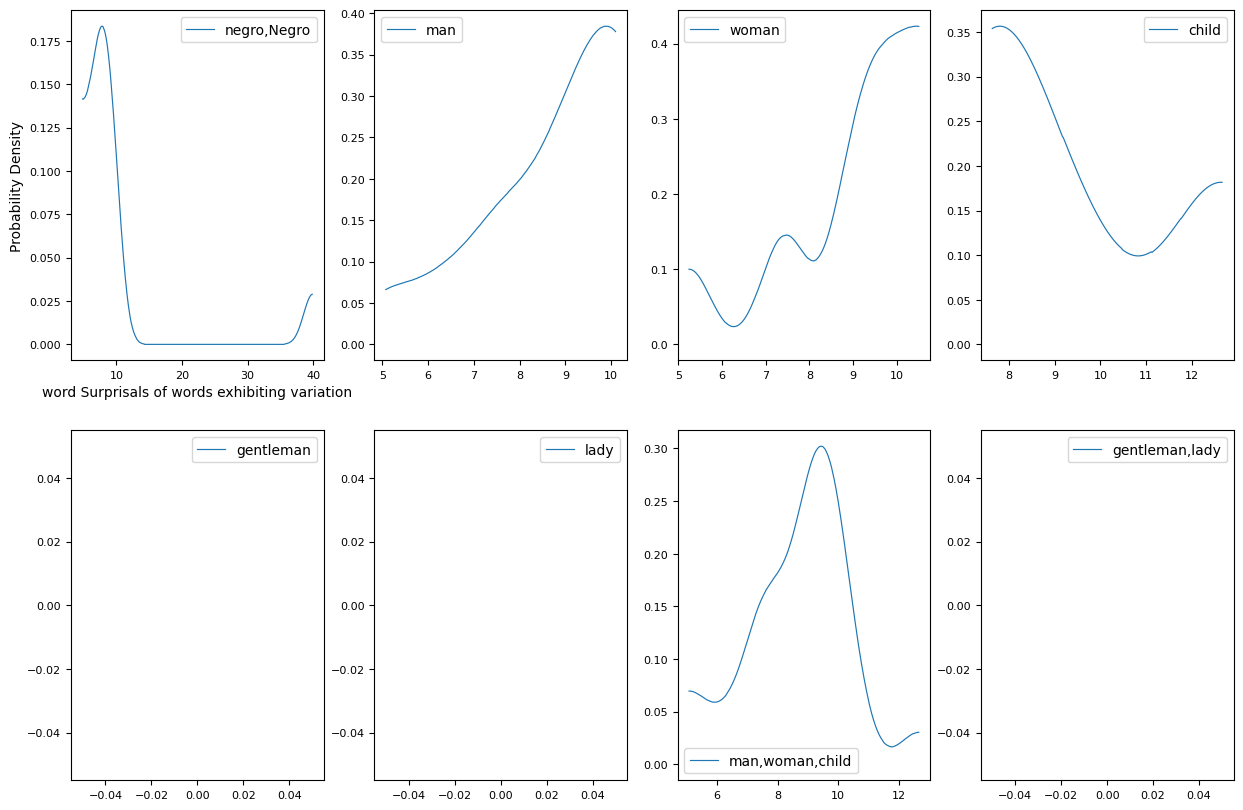

In [1144]:
variation = "levellings_aux"
surprisals = defaultdict(list)  # {speakers: list of surprisals (each corresponding to a word demonstrating the variation)}

# get the surprisals ... 
S = [["negro", "Negro"], ["man"], ["woman"], ["child"], ["gentleman"], ["lady"],  ["man", "woman", "child"], ["gentleman", "lady", ]]
for speakers in S:
    
    # get the quotation set, 'i' of interest
    r_ = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False), "AvNLL"]
    lb, ub = get_hdi(r_, hdi=0.95)
    i_of_interest = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False) & (quotes.loc[:,"AvNLL"] > lb) & (quotes.loc[:,"AvNLL"] < ub), 'i']

    count_all
    for i in tqdm(i_of_interest):

        try:

            # get probability chain corresponding to quote
            c = np.array(chains[i])
            
            q = quotes.loc[i, 'quote']
            s  = q[1:-1]
            
            # convert quote to words           
            words = quotes.loc[i, 'words']

            tokens = np.array(tokenizer.tokenize(s))
            words_indices, N = get_words_indices(words, tokens)

            if quotes.loc[i, f"{variation}_count"] > 0:
                
                for instance in quotes.loc[i, variation]:

                    # the instance may occur multiple times
                    for lb, ub in gen_indices(words, get_words(instance)):

                        # add surprisals for each word in the instance
                        for i in range(lb,ub):
                        
                            word_indices = words_indices[i]  # token and chain indices corresponding to word
                            surprisals[",".join(speakers)].append(-np.log(c[word_indices]).sum())

                    # check
                    # print(instance)
                    
        except:
            if len(quotes.loc[i, variation]) > 0:
                # print(q)
                pass

# Get the MAS and newMAS for n-word, where newMAS due to the absence of words showing the variation in question
speakers = ['negro', "Negro"]
r_ = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False), "AvNLL"]
lb, ub = get_hdi(r_, hdi=0.95)
i_of_interest = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False) & (quotes.loc[:,"AvNLL"] > lb) & (quotes.loc[:,"AvNLL"] < ub), 'i']

MAS_negro = quotes.loc[i_of_interest, "sumNLL"].sum() / quotes.loc[i_of_interest, "N"].sum()
newMAS_negro = (quotes.loc[i_of_interest, "sumNLL"].sum() - sum(surprisals['negro,Negro'])) / (quotes.loc[i_of_interest, "N"].sum() - len(surprisals['negro,Negro']))
print('negro,Negro', MAS_negro, newMAS_negro)

# get importance:
for speakers in S[1:]:
    
    r_ = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False), "AvNLL"]
    lb, ub = get_hdi(r_, hdi=0.95)
    i_of_interest = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False) & (quotes.loc[:,"AvNLL"] > lb) & (quotes.loc[:,"AvNLL"] < ub), 'i']

    MAS = quotes.loc[i_of_interest, "sumNLL"].sum() / quotes.loc[i_of_interest, "N"].sum()
    newMAS = (quotes.loc[i_of_interest, "sumNLL"].sum() - sum(surprisals[",".join(speakers)])) / (quotes.loc[i_of_interest, "N"].sum() - len(surprisals[",".join(speakers)]))
    
    importance = 100*((MAS_negro - newMAS_negro) - (MAS - newMAS)) / (MAS_negro - MAS)
    print(speakers, importance)

# get plots of collected Surprisals
x,y = 2,4
fig, axs = plt.subplots(x, y, figsize=(15, 10))
for i, speakers in enumerate(S):

    row = i // y
    col = i - (row)*y
    az.plot_kde(np.array(surprisals[",".join(speakers)]), ax=axs[row, col], label=",".join(speakers), textsize=8, );

    if row==0 and col==0:
        axs[row, col].set_xlabel("word Surprisals of words exhibiting variation")
        axs[row, col].set_ylabel("Probability Density")


## Double Modals

e.g., I might could go with you

Consider most common english modals: can, could, may, might, will, would, shall, should, must, ought to, 
Which of these have variation in 1st/2nd/3rd person conjugations?: None

In [914]:
modals = ['can', 'could', 'may', 'might', 'would', 'shall', 'should', 'must', 'ought to', "can't", "couldn't", "mightn't", "won't", "wouldn't", "shalln't", "shouldn't", "mustn't", "oughtn't to"]
    

#### n-word,lit vs normative,lit

detection

In [915]:
quotes['double_modals'] = quotes['quote'].progress_map(lambda quote: [" ".join(double) for double in permutations(modals, 2) if " " +  " ".join(double) + " " in quote])
quotes['double_modals_count'] = quotes['double_modals'].progress_map(lambda x: len(x))


100%|█████████████████████████████████████████████████| 2379076/2379076 [00:01<00:00, 2023209.83it/s]


In [922]:
for x in list(quotes.loc[quotes.loc[:,'double_modals_count'] > 0, 'quote']):
    print(x)

"Nevertheless it's true.  Is it any wonder a fellow who is playing as safe as he can would lean toward Germany rather than the Allies.  Also, to my mind, it seems to be a case of Germany being the under dog and my sympathies are naturally with that animal."
"The whole bunch was runts--sickly, measly little fellers. Nevertheless an' agin, you shouldn't ought to have any kick comin'. You had a fine trip an' a heap of adventure an' me an' Bull paid your passage back to San Francisco. Come, Scraggs. Be sensible. What's the use holdin' a grudge after twenty-five years?"
"no man that _wants_ to be good need be afraid of me. You'd have been a good boy always--if it hadn't been for me. _I_ know that as well as you. I've got the past all written down in my head. I can't rub it out. But any man that's got the nerve can put new writing across and across the old, until the old can't be read, or if it could would read like a joke. You can tell whomsoever it concerns to do well and fear nothing. At 

Very few instances observed, none in our negro or normative cases, and sometimes, it's a question of missing comma or word: "The best I can shall be done,"

rates of occurrence

In [923]:
variation = "double_modals"
for speakers in [["negro", "Negro"], ["man"], ["woman"], ["gentleman"], ["lady"], ["child"]]:

    # get 95\% HDI
    r_ = quotes.loc[(df.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False), "AvNLL"]
    lb, ub = get_hdi(r_, hdi=0.95)
    i_of_interest = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False) & (df.loc[:,"AvNLL"] > lb) & (quotes.loc[:,"AvNLL"] < ub), 'i']

    word_count = quotes.loc[i_of_interest, "N"].sum()
    var_count = quotes.loc[(quotes.loc[:, "i"].isin(i_of_interest)) , f'{variation}_count'].sum()
    
    print(speakers, 100*var_count / word_count, var_count, word_count)
    

['negro', 'Negro'] 0.0 0 12271
['man'] 0.0 0 213248
['woman'] 0.0 0 57194
['gentleman'] 0.0 0 22035
['lady'] 0.0 0 64760
['child'] 0.0 0 10642


#### news

In [1010]:
# news
Q_news['double_modals'] = Q_news['quote'].progress_map((lambda quote: [" ".join(double) for double in permutations(modals, 2) if " " +  " ".join(double) + " " in quote]))
Q_news['double_modals_count'] = Q_news['double_modals'].progress_map(lambda x: len(x))


# get 95\% HDI
r_ = Q_news.loc[:, metric]
lb, ub = get_hdi(r_, hdi=0.95)
i_of_interest = Q_news.loc[(Q_news.loc[:,metric] > lb) & (Q_news.loc[:,metric] < ub), 'i']

# rate
print(100*sum(Q_news.loc[(Q_news.loc[:, "i"].isin(i_of_interest)) , 'double_modals_count']) / len(i_of_interest), sum(Q_news.loc[(Q_news.loc[:, "i"].isin(i_of_interest)) , 'double_modals_count']), len(i_of_interest) )


100%|██████████████████████████████████████████████████████████████████████████████████████| 1524/1524 [00:00<00:00, 1815942.98it/s]

0.0 0 1446


## Double Negation

E.g., "I ain't never"

In [549]:
p = re.compile(r"\s+\w+(?:n't|aint|haint)\s+(?!said no|say no|saying no)(?:\w+\s+){,2}(?:(?:nuff|noff|noth)in[kg']*|ne[vb]+er|nobody|no)")

# test 1
s = "No, I hain\'t said nuffin,"

# find matches ...
matches = re.findall(p, s)
display(matches)

# find the indices of the matches
for m in matches:
    
    quote_words = get_words(s)    
    match_words = get_words(m)

    for lb, ub in gen_indices(quote_words, match_words):
        print(lb,ub,quote_words[lb:ub])

[" hain't said nuffin"]

3 6 ["hain't", 'said', 'nuffin']


In [550]:
# test 2
s = ['How', 'kin', 'I', 'go', '?', 'I', "ain't", 'got', 'no', 'money', ',', 'and', 'I', "ain't", 'got', 'the', "stren'th", 'to', 'walk', '.', "I'm", "jes'", 'a', 'pore', 'ole', 'man', 'what', "don't", 'mean', 'no', 'harm', 'to', 'nobody', '.', 'Take', 'me', 'along', 'with', 'you-all', '!', "I'm", 'afeared', 'the', "Riders'll", 'git', 'me', "ag'in", '.', 'I', 'come', 'back', 'to', 'see', 'my', 'darter', ',', 'the', 'onliest', 'chile', 'I', 'got', 'in', 'the', "worl'", '.', 'I', "ain't", 'got', 'no', 'other', 'place', 'to', 'go', 'at', '.', 'The', 'Madam', "won't", 'let', 'a', 'pore', 'ole', 'man', 'suffer', '.', 'I', 'wants', 'to', 'see', 'my', 'darter', '.']
o = ["ain't", 'got', 'no']

for lb,ub in gen_indices(s, o):
    print(lb,ub,s[lb:ub])

6 9 ["ain't", 'got', 'no']
66 69 ["ain't", 'got', 'no']


#### n-word,lit vs normative,lit

In [551]:

quotes['double_negatives'] = quotes['quote'].progress_map(lambda quote: re.findall(p, quote))
quotes['double_negatives_count'] = quotes['double_negatives'].progress_map(lambda x: len(x))

100%|███████████████████████████████████████████████████████| 2379076/2379076 [00:01<00:00, 2028327.48it/s]


In [927]:
list(zip(quotes.loc[(quotes.loc[:,'double_negatives_count']>0) & (quotes.loc[:,'speaker'].isin(["negro", "Negro"])), 'double_negatives'], quotes.loc[(quotes.loc[:,'double_negatives_count']>0) & (quotes.loc[:,'speaker'].isin(["negro", "Negro"])), 'quote']))


[([" don't know nuffin"],
  '"Carl\'s forgot his English, and don\'t know nuffin what she wants! he, he, he! Or if she makes him und\'stan\' one ting, den he talks Dutch, and _she_ don\'t und\'stan.\' And so dey\'se habin\' it, fust one, den tudder, while Miss Jinny she hears \'em and comes fur to let us know. But how de ol\' critter eber found you out, dat am one ob de mysteries!"'),
 ([" ain't neber done nuffin"],
  '"scuse me fur int\'ruptin\', but I can\'t help it. Don\' you go, an ax an ole man like me if I tinks dat ole miss went away cos you was comin\' an\' if it\'s my true b\'lief dat she\'ll neber come back while you is h\'yar. Don\' ask me nuffin like dat, Mahs\' Junius. Ise libed in dis place all my bawn days, an\' I ain\'t neber done nuffin to you, Mahs\' Junius, \'cept keepin\' you from breakin\' you neck when you was too little to know better. I neber \'jected to you marryin\' any lady you like bes\', an\' \'tain\'t f\'ar Mahs\' Junius, now Ise ole an\' gittin\' on de ca

rate of variation observed

In [928]:
variation = "double_negatives"
for speakers in [["negro", "Negro"], ["man"], ["woman"], ["gentleman"], ["lady"], ["child"]]:

    # get 95\% HDI
    r_ = quotes.loc[(df.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False), "AvNLL"]
    lb, ub = get_hdi(r_, hdi=0.95)
    i_of_interest = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False) & (df.loc[:,"AvNLL"] > lb) & (quotes.loc[:,"AvNLL"] < ub), 'i']

    word_count = quotes.loc[i_of_interest, "N"].sum()
    var_count = quotes.loc[(quotes.loc[:, "i"].isin(i_of_interest)) , f'{variation}_count'].sum()
    
    print(speakers, 100*var_count / word_count, var_count, word_count)
    

['negro', 'Negro'] 0.11409013120365089 14 12271
['man'] 0.05580357142857143 119 213248
['woman'] 0.08042801692485226 46 57194
['gentleman'] 0.004538234626730202 1 22035
['lady'] 0.012353304508956145 8 64760
['child'] 0.028190189813944746 3 10642


Get contribution to mean AvNLL

In [1284]:
variation = "double_negatives"
surprisals = defaultdict(list)  # {speakers: list of surprisals (each corresponding to a word demonstrating the variation)}

# get the surprisals ... 
S = [["negro", "Negro"], ["man"], ["woman"], ["child"], ["gentleman"], ["lady"],  ["man", "woman", "child"], ["gentleman", "lady", ]]
for speakers in S:
    
    # get the quotation set, 'i' of interest
    r_ = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False), "AvNLL"]
    lb, ub = get_hdi(r_, hdi=0.95)
    i_of_interest = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False) & (quotes.loc[:,"AvNLL"] > lb) & (quotes.loc[:,"AvNLL"] < ub), 'i']

    for i in tqdm(i_of_interest):

        try:

            # get probability chain corresponding to quote
            c = np.array(chains[i])
            
            q = quotes.loc[i, 'quote']
            s  = q[1:-1]
            
            # convert quote to words           
            words = quotes.loc[i, 'words']

            tokens = np.array(tokenizer.tokenize(s))
            words_indices, N = get_words_indices(words, tokens)

            if quotes.loc[i, f"{variation}_count"] > 0:
                
                for instance in quotes.loc[i, variation]:

                    # the instance may occur multiple times
                    for lb, ub in gen_indices(words, get_words(instance)):

                        # add surprisals for each word in the instance
                        for i in range(lb,ub):
                        
                            word_indices = words_indices[i]  # token and chain indices corresponding to word
                            surprisals[",".join(speakers)].append(-np.log(c[word_indices]).sum())

                    # check
                    # print(instance)
                    
        except:
            if len(quotes.loc[i, variation]) > 0:
                # print(q)
                pass

# Get the MAS and newMAS for n-word, where newMAS due to the absence of words showing the variation in question
speakers = ['negro', "Negro"]
r_ = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False), "AvNLL"]
lb, ub = get_hdi(r_, hdi=0.95)
i_of_interest = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False) & (quotes.loc[:,"AvNLL"] > lb) & (quotes.loc[:,"AvNLL"] < ub), 'i']

MAS_negro = quotes.loc[i_of_interest, "sumNLL"].sum() / quotes.loc[i_of_interest, "N"].sum()
newMAS_negro = (quotes.loc[i_of_interest, "sumNLL"].sum() - sum(surprisals['negro,Negro'])) / (quotes.loc[i_of_interest, "N"].sum() - len(surprisals['negro,Negro']))
print('negro,Negro', MAS_negro, newMAS_negro)

# get importance:
for speakers in S[1:]:
    
    r_ = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False), "AvNLL"]
    lb, ub = get_hdi(r_, hdi=0.95)
    i_of_interest = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False) & (quotes.loc[:,"AvNLL"] > lb) & (quotes.loc[:,"AvNLL"] < ub), 'i']

    MAS = quotes.loc[i_of_interest, "sumNLL"].sum() / quotes.loc[i_of_interest, "N"].sum()
    newMAS = (quotes.loc[i_of_interest, "sumNLL"].sum() - sum(surprisals[",".join(speakers)])) / (quotes.loc[i_of_interest, "N"].sum() - len(surprisals[",".join(speakers)]))
    
    importance = 100*((MAS_negro - newMAS_negro) - (MAS - newMAS)) / (MAS_negro - MAS)
    print(speakers, importance)

# get plots of collected Surprisals
x,y = 2,4
fig, axs = plt.subplots(x, y, figsize=(15, 10))
for i, speakers in enumerate(S):

    row = i // y
    col = i - (row)*y
    az.plot_kde(np.array(surprisals[",".join(speakers)]), ax=axs[row, col], label=",".join(speakers), textsize=8, );

    if row==0 and col==0:
        axs[row, col].set_xlabel("word Surprisals of words exhibiting variation")
        axs[row, col].set_ylabel("Probability Density")


  0%|                                                                        | 0/774 [00:00<?, ?it/s]


KeyError: 'double_negatives'

#### news

In [292]:
Q_news['double_negatives'] = Q_news['quote'].progress_map(lambda quote: re.findall(p, quote))
Q_news['double_negatives_count'] = Q_news['double_negatives'].progress_map(lambda x: len(x))

100%|██████████████████████████████████████████████████████████████████████████████████████| 1524/1524 [00:00<00:00, 1394441.38it/s]


In [298]:
list(Q_news.loc[Q_news.loc[:,'double_negatives_count']>0, 'double_negatives'])

[[" hadn't never "],
 [" ain't zactly made no "],
 [" ain't doing nothing "],
 [" don't know nothing "],
 [" ain't never "],
 [" ain't got no "],
 [" ain't got no "],
 [" hain't no "],
 [" wasn't no "],
 [" ain't noffin' "],
 [" didn't do no "],
 [" don't needs no "],
 [" don't know nuffin."],
 [" worn't nothin' "],
 [" ain't no "],
 [" ain't got no "],
 [" won't hurt nobody,"],
 [" ain't no "],
 [" ain't done nothin'."],
 [" ain't no "],
 [" can't git nuffin' "],
 [" hain't got no "],
 [" worn't no "],
 [" worn't nothin' "],
 [" don't want nothin' "],
 [" can't do nuffin' "],
 [" ain't no "],
 [" hain't heeerd nothin' "],
 [" hain't got no "],
 [" won't be no "],
 [" worn't nothin' "],
 [" ain't seed nothin',"],
 [" ain't seed nothin' "],
 [" can't tell nothin' "],
 [" ain't got no "],
 [" hain't got no "],
 [" ain't no "],
 [" didn't hab no ", " don't like turkey no "],
 [" worn't no "],
 [" worn't nothin' "],
 [" don't want nothin' "],
 [" ain't no "],
 [" ain't no "],
 [" ain't don

percentage of quotations ....

In [293]:
# get 95\% HDI
r_ = Q_news.loc[:, metric]
lb, ub = get_hdi(r_, hdi=0.95)
i_of_interest = Q_news.loc[(Q_news.loc[:,metric] > lb) & (Q_news.loc[:,metric] < ub), 'i']

print('news+negro', 100*sum(Q_news.loc[(Q_news.loc[:, "i"].isin(i_of_interest)) , 'double_negatives_count']) / len(i_of_interest), sum(Q_news.loc[(Q_news.loc[:, "i"].isin(i_of_interest)) , 'double_negatives_count']), len(i_of_interest) )


news+negro 3.2503457814661134 47 1446


In [1019]:
contrib_news = 0

# get the quotation set, 'i' of interest
r_ = Q_news.loc[:, metric]
lb, ub = get_hdi(r_, hdi=0.95)
i_of_interest = Q_news.loc[(Q_news.loc[:,metric] > lb) & (Q_news.loc[:,metric] < ub), 'i']

# collect the sum of surprisals for matching variations
surprisal = 0  # records total surprisal contribution due to variation under consideraiton
count_all = 0  # keeps count of all words in quotation set
for i in i_of_interest:
    try:

        # get probability chain corresponding to quote
        c = np.array(chains_news[i])
        
        # convert quote to words           
        q = Q_news.loc[i, 'quote']
        s  = q
        quote_words = get_words(s)
        count_all += len(quote_words)

        # get matches wrt., variation type of interest
        matches = re.findall(p, s)

        # iterate over matches ...
        for m in matches: 
            
            match_words:list[str] = get_words(m)

            # get probability chains wrt., match, m
            for lb_,ub_ in gen_indices(quote_words, match_words):
                # add chain to surprisal
                surprisal += -np.log(c[lb_:ub_]).sum()               
    except:
        print(i)

contrib_news = surprisal / count_all
print(contrib_news)

# get ratios of contribution:
print(contrib_news / contribs['negro,Negro'])


1446
0.05660715083603921
1.9523426120487677


## done VERB

they done ate all of their food


In [35]:
import spacy

In [36]:
nlp = spacy.load("en_core_web_sm")

In [959]:
re.findall("done said", "he done said it")

['done said']

detection

In [969]:
for token in nlp("what's happening?"):
    print(token.text)

what
's
happening
?


In [1102]:
quotes.loc[quotes.loc[:, 'quote']==False, 'i']

Series([], Name: i, dtype: int64)

In [1101]:
for speakers in [["negro", "Negro"], ["man"], ["woman"], ["gentleman"], ["lady"], ["child"]]:
    
    r_ = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False), "AvNLL"]
    lb, ub = get_hdi(r_, hdi=0.95)
    i_of_interest = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False) & (quotes.loc[:,"AvNLL"] > lb) & (quotes.loc[:,"AvNLL"] < ub), 'i']

    quotes.loc[i_of_interest, 'spacy_tokens'] = quotes.loc[i_of_interest, 'quote'].progress_map(lambda quote: [(token.text, token.pos_) for token in nlp(quote[1:-1])])
    quotes.loc[i_of_interest, 'done_VERB'] = quotes.loc[i_of_interest, "spacy_tokens"].progress_map(lambda tuples: [c[0] for p, c in zip(tuples[:-1], tuples[1:]) if p[0]=='done' and c[1]=="VERB"])
    # we only record VERB ... this is where the heighted effect
    
    quotes.loc[i_of_interest, 'done_VERB_count'] = quotes.loc[i_of_interest, 'done_VERB'].progress_map(lambda x: len(x))


100%|█████████████████████████████████████████████████████████| 885/885 [00:00<00:00, 1520048.75it/s]


In [1015]:
for q in quotes.loc[quotes.loc[:,'done_VERB_count'] > 0, 'quote']:
    print(q)

"But ain't I done won it?"
"he al'ays yells like that when his Ma's done scrubbed him."
"But I have hearn the bride's name; and a rum un it is, too! Lady, Lady Hoist? no! Hurl? no! Hurt? yes, that is it! Lady Hurt-me-so, that's the name of the lady he's done married!"
"Now, sure as the world, honey, you done heard somefin 'bout de poor young marser? Is he come to an accident, honey?"
"Yes, Dinah, 'oman, here day is; little foot-prints in de snow a-goin' away from de house an' almost covered up now! She done gone! Now don't dat beat eberything? Now she'll be froze to death, 'less I goes out in de storm to look for her; an' maybe she'll be froze anyway; for dere's no sartainty 'bout my findin' of her. Now aint dat a trial for any colored gentleman's narves! Well den, here goes! Wait for me here, ole 'omen, till I come back, and if I nebber comes, all I leabes is yourn, you know,"
"He's done gone out in de new-ground terbacker, long wid de han's,"
"Dunno whar ole miss is, but I reckon she

#### n-word,lit vs normative,lit

rate

In [1103]:
variation = "done_VERB"
for speakers in [["negro", "Negro"], ["man"], ["woman"], ["gentleman"], ["lady"], ["child"]]:

    # get 95\% HDI
    r_ = quotes.loc[(df.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False), "AvNLL"]
    lb, ub = get_hdi(r_, hdi=0.95)
    i_of_interest = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False) & (df.loc[:,"AvNLL"] > lb) & (quotes.loc[:,"AvNLL"] < ub), 'i']

    word_count = quotes.loc[i_of_interest, "N"].sum()
    var_count = quotes.loc[(quotes.loc[:, "i"].isin(i_of_interest)) , f'{variation}_count'].sum()
    
    print(speakers, 100*var_count / word_count, var_count, word_count)
    

['negro', 'Negro'] 0.04074647542987531 5.0 12271
['man'] 0.012661314525810324 27.0 213248
['woman'] 0.005245305451620799 3.0 57194
['gentleman'] 0.004538234626730202 1.0 22035
['lady'] 0.0 0.0 64760
['child'] 0.028190189813944746 3.0 10642


contribution to mean Average Surprisal

100%|███████████████████████████████████████████████████████████| 774/774 [00:00<00:00, 11566.70it/s]


done won
done call
done say
done fotched
done said


 18%|██████████                                              | 2587/14418 [00:00<00:00, 13002.03it/s]

done scrubbed
done heard
done gone
done feel
done gone
done gone
done gone
done come
done come
done gone
done gone
done come


 52%|████████████████████████████▉                           | 7452/14418 [00:00<00:00, 15789.11it/s]

done guessed
done got


 85%|██████████████████████████████████████████████▌        | 12222/14418 [00:00<00:00, 15235.98it/s]

done said
done asked
done promise
done took
done got
done got
done got


100%|███████████████████████████████████████████████████████| 14418/14418 [00:00<00:00, 14681.23it/s]


done held
done gone
done fitted
done eased
done gone
done come


 84%|███████████████████████████████████████████████▊         | 3268/3895 [00:00<00:00, 15362.28it/s]

done married
done gone
done married


100%|█████████████████████████████████████████████████████████| 1404/1404 [00:00<00:00, 14267.69it/s]


done gone


100%|███████████████████████████████████████████████████████████| 885/885 [00:00<00:00, 16144.57it/s]


done laughing
done buyed
done made


 20%|███████████▍                                            | 3909/19199 [00:00<00:00, 19549.66it/s]

done scrubbed
done married
done heard
done gone
done gone
done feel
done gone
done gone
done gone
done come
done come
done gone
done gone
done come


 52%|█████████████████████████████                           | 9963/19199 [00:00<00:00, 19995.73it/s]

done guessed
done got
done married


 84%|█████████████████████████████████████████████▉         | 16041/19199 [00:00<00:00, 20045.67it/s]

done said
done asked
done promise
done took
done laughing
done got
done got
done got


100%|███████████████████████████████████████████████████████| 19199/19199 [00:00<00:00, 19829.80it/s]


done held
done gone
done buyed
done made
done fitted
done eased
done gone
done come


 71%|████████████████████████████████████████▌                | 3706/5200 [00:00<00:00, 18684.14it/s]

done gone


100%|█████████████████████████████████████████████████████████| 5200/5200 [00:00<00:00, 18490.16it/s]


negro,Negro 11.417817649479787 11.419009049667897
['man'] -0.04642969082017856
['woman'] -0.15019269425002008
['gentleman'] -0.08949786066537611
['lady'] -0.10175481325621864
['child'] -0.12142731831332229
['man', 'woman', 'child'] -0.0713213726757828
['gentleman', 'lady'] -0.09891923203216554


/opt/homebrew/lib/python3.11/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


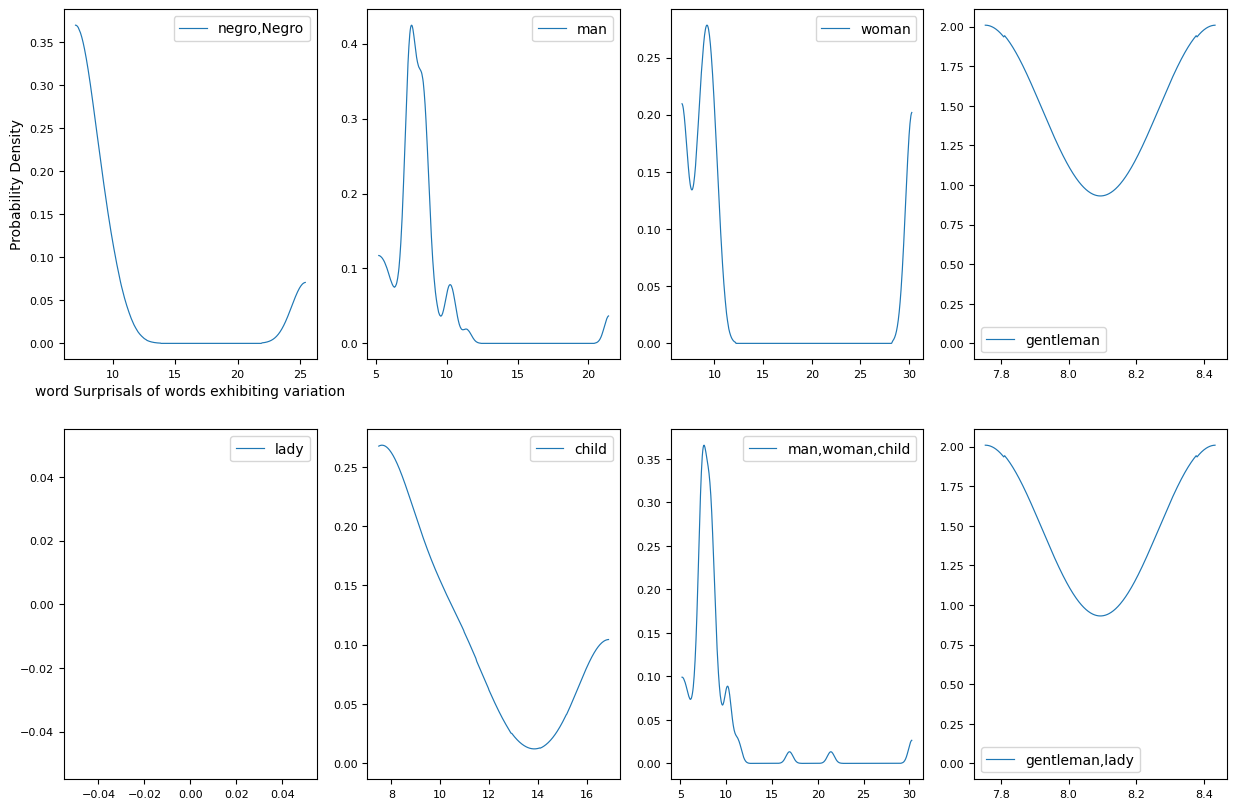

In [1019]:
variation = "done_VERB"
surprisals = defaultdict(list)  # {speakers: list of surprisals (each corresponding to a word demonstrating the variation)}

# get the surprisals ... 
S = [["negro", "Negro"], ["man"], ["woman"], ["gentleman"], ["lady"], ["child"], ["man", "woman", "child"], ["gentleman", "lady", ]]
for speakers in S:
    
    # get the quotation set, 'i' of interest
    r_ = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False), "AvNLL"]
    lb, ub = get_hdi(r_, hdi=0.95)
    i_of_interest = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False) & (quotes.loc[:,"AvNLL"] > lb) & (quotes.loc[:,"AvNLL"] < ub), 'i']

    count_all
    for i in tqdm(i_of_interest):

        try:

            # get probability chain corresponding to quote
            c = np.array(chains[i])
            
            q = quotes.loc[i, 'quote']
            s  = q[1:-1]
            
            # convert quote to words           
            words = quotes.loc[i, 'words']

            tokens = np.array(tokenizer.tokenize(s))
            words_indices, N = get_words_indices(words, tokens)

            if quotes.loc[i, f"{variation}_count"] > 0:
                
                for instance in quotes.loc[i, variation]:
                    print(instance)

                    # the instance may occur multiple times
                    for lb, ub in gen_indices(words, get_words(instance)):

                        # add surprisals for each word in the instance
                        for i in range(lb,ub):
                        
                            word_indices = words_indices[i]  # token and chain indices corresponding to word
                            surprisals[",".join(speakers)].append(-np.log(c[word_indices]).sum())

                    # check
                    # print(instance)
                    
        except:
            if len(quotes.loc[i, variation]) > 0:
                # print(q)
                pass

# Get the MAS and newMAS for n-word, where newMAS due to the absence of words showing the variation in question
speakers = ['negro', "Negro"]
r_ = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False), "AvNLL"]
lb, ub = get_hdi(r_, hdi=0.95)
i_of_interest = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False) & (quotes.loc[:,"AvNLL"] > lb) & (quotes.loc[:,"AvNLL"] < ub), 'i']

MAS_negro = quotes.loc[i_of_interest, "sumNLL"].sum() / quotes.loc[i_of_interest, "N"].sum()
newMAS_negro = (quotes.loc[i_of_interest, "sumNLL"].sum() - sum(surprisals['negro,Negro'])) / (quotes.loc[i_of_interest, "N"].sum() - len(surprisals['negro,Negro']))
print('negro,Negro', MAS_negro, newMAS_negro)

# get importance:
for speakers in S[1:]:
    
    r_ = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False), "AvNLL"]
    lb, ub = get_hdi(r_, hdi=0.95)
    i_of_interest = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False) & (quotes.loc[:,"AvNLL"] > lb) & (quotes.loc[:,"AvNLL"] < ub), 'i']

    MAS = quotes.loc[i_of_interest, "sumNLL"].sum() / quotes.loc[i_of_interest, "N"].sum()
    newMAS = (quotes.loc[i_of_interest, "sumNLL"].sum() - sum(surprisals[",".join(speakers)])) / (quotes.loc[i_of_interest, "N"].sum() - len(surprisals[",".join(speakers)]))
    
    importance = 100*((MAS_negro - newMAS_negro) - (MAS - newMAS)) / (MAS_negro - MAS)
    print(speakers, importance)

# get plots of collected Surprisals
x,y = 2,4
fig, axs = plt.subplots(x, y, figsize=(15, 10))
for i, speakers in enumerate(S):

    row = i // y
    col = i - (row)*y
    az.plot_kde(np.array(surprisals[",".join(speakers)]), ax=axs[row, col], label=",".join(speakers), textsize=8, );

    if row==0 and col==0:
        axs[row, col].set_xlabel("word Surprisals of words exhibiting variation")
        axs[row, col].set_ylabel("Probability Density")


In [630]:
[x.pos_ for x in nlp("ain't")]

['VERB', 'PART']

In [593]:
tokens = tokenizer.tokenize("But ain't I done won it?")
words = get_words("But ain't I done won it?")
words_indices = get_words_indices(words, tokens)
words_indices

([[0], [1, 2], [3], [4], [5], [6], [7]], 7)

In [427]:
# # news
# get 95\% HDI
r_ = Q_news.loc[:, metric]
lb, ub = get_hdi(r_, hdi=0.95)
i_of_interest = Q_news.loc[(Q_news.loc[:,metric] > lb) & (Q_news.loc[:,metric] < ub), 'i']

count = 0
for q in tqdm(list(Q_news.loc[(Q_news.loc[:, "i"].isin(i_of_interest)), "quote"])):
    
    doc = nlp(q)
    q_ = " ".join(['done' if token.text == 'done' else token.pos_ for token in doc])

    if "PRON done VERB" in q_ or "PROPN done VERB" in q_:
        print(q)
        count += 1


print("negro+news", count, len(i_of_interest), 100*count / len(i_of_interest))

 31%|████████████████████████████▋                                                              | 455/1446 [00:02<00:05, 187.86it/s]

I reckon we done pitched into a cloudburst


 38%|██████████████████████████████████▊                                                        | 553/1446 [00:03<00:04, 185.50it/s]

I done 'quire about yer kyracktir, and I done find out it are no good.


 48%|███████████████████████████████████████████▊                                               | 696/1446 [00:04<00:04, 176.49it/s]

heah's where I weaken, I'll tell you the trufe. I done serve four years over in Pennsylvania, and I let that there little bird out because I don't want to see nuffin' behind bars.


 51%|██████████████████████████████████████████████▏                                            | 733/1446 [00:04<00:04, 160.53it/s]

Afo' de Lawd, Boss, is hit you dat's cookin' dat chicking? I done smelled hit more'n a miled away, and hab bin huntin' foh de Lawd's sake, jist gib me a leetle, teenty, weenty sup in dis heah tin-cup for my boss. He's an ossifer, an' is layin' in de ossifer's horse-pistol ober dar. Hit'll do him a powerful sight ob good.


 61%|███████████████████████████████████████████████████████▉                                   | 889/1446 [00:05<00:03, 171.97it/s]

Now, see heah. Yo' can go fru th' whole blamed joggarfy, but Massa Sherman he done say that nobody can get pas' me wifout sayin' Cambridge!


 70%|███████████████████████████████████████████████████████████████▎                          | 1017/1446 [00:06<00:02, 196.40it/s]

Now see heah. Yo' can go fru th' whole blamed joggrafy, but Massa Sherman he done say that nobody can get pas' me wifout sayin' Cambridge!
Well, here's what I done come ax yuh,


 76%|████████████████████████████████████████████████████████████████████▏                     | 1095/1446 [00:06<00:01, 186.79it/s]

if I done had chicken for supper would they by able to see it?
Well, here's what I done come to ax yuh,


 84%|███████████████████████████████████████████████████████████████████████████▋              | 1216/1446 [00:07<00:01, 172.54it/s]

Now, seea heah - yo' can go fru th' whole blamed joggrafy; but Massa Sherman he done say that nobody can get pas' me wifout sayin' 'Cambridge!
Yes, but you see Massa Stranger one ob dem Virginny gemmens come 'long here last year, and showed him how to eat greens in his licker; he liked it so well dat he done stuck to it till it killed him.
Miss 'Gusta,  I done named dat calf.


100%|██████████████████████████████████████████████████████████████████████████████████████████| 1446/1446 [00:08<00:00, 169.87it/s]

negro+news 12 1446 0.8298755186721992


## voiceless dental fricative as 'f'

In [292]:
# Load the CMU pronunciation dictionary
import requests
lines = requests.get("http://svn.code.sf.net/p/cmusphinx/code/trunk/cmudict/cmudict-0.7b").text.splitlines()

# ignore eveything up the 'A  AH0'
lines = lines[lines.index('A  AH0'):]

In [1032]:
# load unix dict
with open("/usr/share/dict/words", "r") as f:
    en_words = [x.strip("\n") for x in f.readlines()]

# add in instances with "ing" replaced with "in'"
en_words += [word[:-3] + "in'" for word in en_words if word[-3:]=="ing"]

In [515]:
# get all words with DH
TH = [line for line in lines if " TH" in line]
TH

['AALSETH  AA1 L S EH0 TH',
 'ABENDROTH  AE1 B IH0 N D R AO0 TH',
 'ABERNATHY  AE1 B ER0 N AE2 TH IY0',
 'ABERNETHY  AE1 B ER0 N EH2 TH IY0',
 'ABSINTHE  AE1 B S IH0 N TH',
 'ACCUHEALTH  AE1 K Y UW0 HH EH2 L TH',
 'ACERO(2)  AH0 TH EH1 R OW0',
 'AEROSMITH  EH1 R OW0 S M IH2 TH',
 "AEROSMITH'S  EH1 R OW0 S M IH2 TH S",
 'AESTHENOPIA  AE0 S TH AH0 N AO1 P Y AH0',
 'AESTHETE  EH1 S TH IY0 T',
 "AESTHETE'S  EH1 S TH IY0 T S",
 'AESTHETES  EH1 S TH IY0 T S',
 'AESTHETIC  EH0 S TH EH1 T IH0 K',
 'AESTHETICALLY  EH0 S TH EH1 T IH0 K L IY0',
 'AESTHETICS  EH0 S TH EH1 T IH0 K S',
 'AFORETHOUGHT  AH0 F AO1 R TH AA2 T',
 'AFTERMATH  AE1 F T ER0 M AE2 TH',
 'AFTERMATHS  AE1 F T ER0 M AE2 TH S',
 'AFTERTHOUGHT  AE1 F T ER0 TH AA2 T',
 'AFTERTHOUGHT(1)  AE1 F T ER0 TH AO2 T',
 'AFTERTHOUGHTS  AE1 F T ER0 TH AA2 T S',
 'AFTERTHOUGHTS(1)  AE1 F T ER0 TH AO2 T S',
 'AGATHA  AE1 G AH0 TH AH0',
 'AINSWORTH  EY1 N S W ER0 TH',
 "AINSWORTH'S  EY1 N Z W ER0 TH S",
 'AITHNE  EY1 TH N',
 'ALBERTHAL  AE1 L B 

In [516]:
# Expand TH to include variants of words where ING is replaced with IN'
display([" ".join([x.split(" ")[0][:-1] + "'"] + x.split(" ")[1:]) for x in TH if x.split(" ")[0][-3:]=="ING"])
TH += [" ".join([x.split(" ")[0][:-1] + "'"] + x.split(" ")[1:]) for x in TH if x.split(" ")[0][-3:]=="ING"]

["ANYTHIN'  EH1 N IY0 TH IH2 NG",
 "AUTHENTICATIN'  AO0 TH EH1 N T AH0 K EY2 T IH0 NG",
 "AUTHORIN'  AO1 TH ER0 IH0 NG",
 "AUTHORIZIN'  AO1 TH ER0 AY2 Z IH0 NG",
 "BIRTHIN'  B ER1 TH IH0 NG",
 "BREATHTAKIN'  B R EH1 TH T EY2 K IH0 NG",
 "COAUTHORIN'  K OW1 AA1 TH ER0 IH0 NG",
 "EARTHLIN'  ER1 TH L IH0 NG",
 "EARTHMOVIN'  ER1 TH M UW2 V IH0 NG",
 "EARTHSHAKIN'  ER1 TH SH EY2 K IH0 NG",
 "EVERYTHIN'  EH1 V R IY0 TH IH2 NG",
 "FORTHCOMIN'  F AO1 R TH K AH1 M IH0 NG",
 "LENGTHENIN'  L EH1 NG TH AH0 N IH0 NG",
 "LIFE-THREATENIN'  L AY1 F TH R EH2 T N IH0 NG",
 "LOATHIN'  L OW1 TH IH0 NG",
 "MOTHBALLIN'  M AO1 TH B AO1 L IH0 NG",
 "NOTHIN'  N AH1 TH IH0 NG",
 "NOTWITHSTANDIN'  N AA2 T W IH0 TH S T AE1 N D IH0 NG",
 "OVERTHROWIN'  OW1 V ER0 TH R OW2 IH0 NG",
 "PLAYTHIN'  P L EY1 TH IH2 NG",
 "REAUTHORIZIN'  R IY0 AO1 TH ER0 AY2 Z IH0 NG",
 "RETHINKIN'  R IY0 TH IH1 NG K IH0 NG",
 "SLEUTHIN'  S L UW1 TH IH0 NG",
 "SOMETHIN'  S AH1 M TH IH0 NG",
 "STRENGTHENIN'  S T R EH1 NG TH AH0 N IH0 NG",
 

In [1033]:
# expand en_words with DH variants
en_words += [line.split(" ")[0].lower() for line in lines] + [line.split(" ")[0].lower().capitalize() for line in lines]
en_words = set(en_words)

In [1035]:
# build a word list variants, replacing th letters corresponding to DH sound, with ...
f = []
for line in TH:

    word = line.split(" ")[0]
    ARPAbet_rep = line.split(" ")[1:]

    # get indices of 'th' positions in word
    th_indices = find_all_indices(word, 'TH')

    # order of occurrence of DH or TH sounds in ARPAbet representation
    th_sounds = [x for x in ARPAbet_rep if x == "DH" or x =='TH']

    # convert th letters corresponding to DH sound, as ...
    var1 = word  # th sounds like DH -> d
    var2 = word  ## th sounds like DH -> dd
    var3 = word  ## th sounds like DH -> t
    var4 = word  ## th sounds like DH -> tt
    for i, th_sound in zip(th_indices, th_sounds):
        if th_sound == 'TH':
            var1 = var1[:i] + 'f' + var1[i+2:]  #this -> dis
            f.append(var1)
            var2 = var2[:i] + 'ff' + var2[i+2:]  #with -> widd
            f.append(var2)
            var3 = var3[:i] + 't' + var3[i+2:]  #with -> wit
            f.append(var3)
            var4 = var4[:i] + 'tt' + var4[i+2:]  #with -> wit
            f.append(var4)

# # add variants where v --> b or bb
# f += [x.replace('v', 'b') for x in f if 'v' in x]
# f += [x.replace('v', 'bb') for x in f if 'v' in x]

# lowercase
f = [x.lower() for x in set(f)]

# get uppercase variants
f += [x.capitalize() for x in f]

# remove instances present in en_words
print(len(f))
f = set([x for x in f if x not in en_words])
print(len(f))
            


23660
22407


#### n-word,lit vs normative,lit

In [1036]:
quotes['th-f'] = quotes['words'].progress_map(lambda words: f.intersection(words))
quotes['th-f_count'] = quotes['th-f'].progress_map(lambda x: len(x))

100%|█████████████████████████████████████████████████| 2379076/2379076 [00:00<00:00, 2462006.26it/s]


In [1031]:
'loafing' in en_words

True

In [1037]:
for q in quotes.loc[quotes.loc[:,'th-f_count']>0,'th-f'][:50]:
    print(q)

{'fing'}
{'teef'}
{'mouf'}
{'strengt'}
{'shet'}
{'shet'}
{"somefin'"}
{"somefin'"}
{'shet'}
{'shet'}
{'Shet'}
{'shet'}
{"Keitt's"}
{"Keitt's"}
{'Vot'}
{'tinks'}
{'vot'}
{'anyting'}
{'anyting'}
{'Vot'}
{'Vot'}
{'Vot'}
{'Vot'}
{'vot'}
{'vot'}
{'tings'}
{'vot'}
{'tings'}
{'tirty'}
{'lef'}
{'lef'}
{'anyting'}
{'anyting'}
{'anyting'}
{'earf'}
{'wifout'}
{'Cafolic'}
{'mouf'}
{'mouf'}
{'frows', 'tings'}
{'lef'}
{'mouf'}
{"Norf's"}
{'mouf'}
{'lef'}
{"mont's"}
{'Souf', 'Norf'}
{'bof'}
{'mouf'}
{'Norf'}


rate

In [1038]:
variation = "th-f"
for speakers in [["negro", "Negro"], ["man"], ["woman"], ["gentleman"], ["lady"], ["child"]]:

    # get 95\% HDI
    r_ = quotes.loc[(df.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False), "AvNLL"]
    lb, ub = get_hdi(r_, hdi=0.95)
    i_of_interest = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False) & (df.loc[:,"AvNLL"] > lb) & (quotes.loc[:,"AvNLL"] < ub), 'i']

    word_count = quotes.loc[i_of_interest, "N"].sum()
    var_count = quotes.loc[(quotes.loc[:, "i"].isin(i_of_interest)) , f'{variation}_count'].sum()
    
    print(speakers, 100*var_count / word_count, var_count, word_count)
    

['negro', 'Negro'] 0.13853801646157607 17 12271
['man'] 0.011254501800720289 24 213248
['woman'] 0.0472077490645872 27 57194
['gentleman'] 0.004538234626730202 1 22035
['lady'] 0.0077208153180975915 5 64760
['child'] 0.028190189813944746 3 10642


contribution to mean Average Surprisal

In [1046]:
variation = "th-f"
surprisals = defaultdict(list)  # {speakers: list of surprisals (each corresponding to a word demonstrating the variation)}

# get the surprisals ... 
S = [["negro", "Negro"], ["man"], ["woman"], ["child"], ["gentleman"], ["lady"],  ["man", "woman", "child"], ["gentleman", "lady", ]]
for speakers in S:
    
    # get the quotation set, 'i' of interest
    r_ = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False), "AvNLL"]
    lb, ub = get_hdi(r_, hdi=0.95)
    i_of_interest = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False) & (quotes.loc[:,"AvNLL"] > lb) & (quotes.loc[:,"AvNLL"] < ub), 'i']

    count_all
    for i in tqdm(i_of_interest):

        try:

            # get probability chain corresponding to quote
            c = np.array(chains[i])
            
            q = quotes.loc[i, 'quote']
            s  = q[1:-1]
            
            # convert quote to words           
            words = quotes.loc[i, 'words']

            tokens = np.array(tokenizer.tokenize(s))
            words_indices, N = get_words_indices(words, tokens)

            if quotes.loc[i, f"{variation}_count"] > 0:
                
                for instance in quotes.loc[i, variation]:

                    # the instance may occur multiple times
                    for lb, ub in gen_indices(words, get_words(instance)):

                        # add surprisals for each word in the instance
                        for i in range(lb,ub):
                        
                            word_indices = words_indices[i]  # token and chain indices corresponding to word
                            surprisals[",".join(speakers)].append(-np.log(c[word_indices]).sum())

                    # check
                    # print(instance)
                    
        except:
            if len(quotes.loc[i, variation]) > 0:
                # print(q)
                pass

# Get the MAS and newMAS for n-word, where newMAS due to the absence of words showing the variation in question
speakers = ['negro', "Negro"]
r_ = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False), "AvNLL"]
lb, ub = get_hdi(r_, hdi=0.95)
i_of_interest = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False) & (quotes.loc[:,"AvNLL"] > lb) & (quotes.loc[:,"AvNLL"] < ub), 'i']

MAS_negro = quotes.loc[i_of_interest, "sumNLL"].sum() / quotes.loc[i_of_interest, "N"].sum()
newMAS_negro = (quotes.loc[i_of_interest, "sumNLL"].sum() - sum(surprisals['negro,Negro'])) / (quotes.loc[i_of_interest, "N"].sum() - len(surprisals['negro,Negro']))
print('negro,Negro', MAS_negro, newMAS_negro)

# get importance:
for speakers in S[1:]:
    
    r_ = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False), "AvNLL"]
    lb, ub = get_hdi(r_, hdi=0.95)
    i_of_interest = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False) & (quotes.loc[:,"AvNLL"] > lb) & (quotes.loc[:,"AvNLL"] < ub), 'i']

    MAS = quotes.loc[i_of_interest, "sumNLL"].sum() / quotes.loc[i_of_interest, "N"].sum()
    newMAS = (quotes.loc[i_of_interest, "sumNLL"].sum() - sum(surprisals[",".join(speakers)])) / (quotes.loc[i_of_interest, "N"].sum() - len(surprisals[",".join(speakers)]))
    
    importance = 100*((MAS_negro - newMAS_negro) - (MAS - newMAS)) / (MAS_negro - MAS)
    print(speakers, importance)

100%|█████████████████████████████████████████████████████████| 5200/5200 [00:00<00:00, 18853.22it/s]


negro,Negro 11.417817649479787 11.40927600220101
['man'] 0.8773997255953911
['woman'] 0.5669225692372242
['child'] 0.5672139413080088
['gentleman'] 0.7308954697301803
['lady'] 0.6172920911038874
['man', 'woman', 'child'] 0.8000276519623909
['gentleman', 'lady'] 0.6452916512264639


## voiced dental fricative as 'd' 

E.g., this --> dis
    

In [505]:
# Load the CMU pronunciation dictionary
import requests
lines = requests.get("http://svn.code.sf.net/p/cmusphinx/code/trunk/cmudict/cmudict-0.7b").text.splitlines()

# ignore eveything up the 'A  AH0'
lines = lines[lines.index('A  AH0'):]

In [1039]:
# load unix dict
with open("/usr/share/dict/words", "r") as f:
    en_words = [x.strip("\n") for x in f.readlines()]

# add in instances with "ing" replaced with "in'"
en_words += [word[:-3] + "in'" for word in en_words if word[-3:]=="ing"]

In [670]:
# get all words with DH
DH = [line for line in lines if " DH" in line]
DH[:10]

['ACANTHA  AA0 K AA1 N DH AH0',
 'AIRWORTHINESS  EH1 R W ER2 DH IY0 N AH0 S',
 'AIRWORTHY  EH1 R W ER2 DH IY0',
 'ALGORITHM  AE1 L G ER0 IH2 DH AH0 M',
 'ALGORITHMS  AE1 L G ER0 IH2 DH AH0 M Z',
 'ALTHOUGH  AO2 L DH OW1',
 'ALTOGETHER  AO2 L T AH0 G EH1 DH ER0',
 'ANOTHER  AH0 N AH1 DH ER0',
 "ANOTHER'S  AH0 N AH1 DH ER0 Z",
 'ANTHES  AE1 N DH AH0 Z']

In [671]:
# Expand DH to include variants of words where ING is replaced with IN'
display([" ".join([x.split(" ")[0][:-1] + "'"] + x.split(" ")[1:]) for x in DH if x.split(" ")[0][-3:]=="ING"])
DH += [" ".join([x.split(" ")[0][:-1] + "'"] + x.split(" ")[1:]) for x in DH if x.split(" ")[0][-3:]=="ING"]

["BATHIN'  B EY1 DH IH0 NG",
 "BOTHERIN'  B AA1 DH ER0 IH0 NG",
 "BREATHIN'  B R IY1 DH IH0 NG",
 "CLOTHIN'  K L OW1 DH IH0 NG",
 "DITHERIN'  D IH1 DH ER0 IH0 NG",
 "FARTHIN'  F AA1 R DH IH0 NG",
 "FATHERIN'  F AA1 DH ER0 IH0 NG",
 "FEATHERBEDDIN'  F EH1 DH ER0 B EH2 D IH0 NG",
 "FEATHERIN'  F EH1 DH ER0 IH0 NG",
 "FURTHERIN'  F ER1 DH ER0 IH0 NG",
 "GATHERIN'  G AE1 DH ER0 IH0 NG",
 "GRANDFATHERIN'  G R AE1 N D F AA2 DH ER0 IH0 NG",
 "MOTHERFUCKIN'  M AH1 DH ER0 F AH2 K IH0 NG",
 "MOTHERIN'  M AH1 DH ER0 IH0 NG",
 "MOUTHIN'  M AW1 DH IH0 NG",
 "SCATHIN'  S K EY1 DH IH0 NG",
 "SEETHIN'  S IY1 DH IH0 NG",
 "SHEATHIN'  SH IY1 DH IH0 NG",
 "SLATHERIN'  S L AE1 DH ER0 IH0 NG",
 "SLITHERIN'  S L IH1 DH ER0 IH0 NG",
 "SMOOTHIN'  S M UW1 DH IH0 NG",
 "SMOTHERIN'  S M AH1 DH ER0 IH0 NG",
 "SOOTHIN'  S UW1 DH IH0 NG",
 "SUNBATHIN'  S AH1 N B EY2 DH IH0 NG",
 "TEETHIN'  T IY1 DH IH0 NG",
 "THESIN'  DH IY1 Z IH0 NG",
 "TITHIN'  T AY1 DH IH0 NG",
 "WEATHERIN'  W EH1 DH ER0 IH0 NG",
 "WITHERIN'  W 

In [1040]:
# expand en_words with DH variants
en_words += [line.split(" ")[0].lower() for line in lines] + [line.split(" ")[0].lower().capitalize() for line in lines]
en_words = set(en_words)

In [1041]:
# build a word list variants, replacing th letters corresponding to DH sound, with ...
d = []
for line in DH:

    word = line.split(" ")[0]
    ARPAbet_rep = line.split(" ")[1:]

    # get indices of 'th' positions in word
    th_indices = find_all_indices(word, 'TH')

    # order of occurrence of DH or TH sounds in ARPAbet representation
    th_sounds = [x for x in ARPAbet_rep if x == "DH" or x =='TH']

    # convert th letters corresponding to DH sound, as ...
    var1 = word  # th sounds like DH -> d
    var2 = word  ## th sounds like DH -> dd
    for i, th_sound in zip(th_indices, th_sounds):
        if th_sound == 'DH':
            var1 = var1[:i] + 'D' + var1[i+2:]  #this -> dis
            d.append(var1)
            var2 = var2[:i] + 'DD' + var2[i+2:]  #with -> widd
            d.append(var2)

# add variant, replacing OTH letters corresponding to "AH1 DH" sound, with "UDD"
for line in DH:

    word = line.split(" ")[0]
    ARPAbet_rep = line.split(" ")[1:]

    if len(list(gen_indices(ARPAbet_rep, ['AH1', 'DH'])))>0:

        # get indices of 'oth' positions in word
        oth_indices = find_all_indices(word, 'OTH')
    
        # order of occurrence of DH or 'TH or AH1 DH' sounds in ARPAbet representation
        th_sounds = []

        last_sound = None
        for sound in ARPAbet_rep:
            if sound == "DH" and last_sound == "AH1":
                th_sounds.append('AH1 DH')
            elif sound == "TH" or sound == "DH":
                th_sounds.append(sound)
            last_sound = sound
            
        # convert oth letters corresponding to AH1 DH sound, as ...
        var1 = word  # th sounds like AH1 DH -> UDD
        for i, th_sound in zip(oth_indices, th_sounds):
            if th_sound == 'AH1 DH':
                var1 = var1[:i] + 'UDD' + var1[i+len('oth'):]  #this -> dis
                d.append(var1)

# add variant, replacing OTH letters corresponding to "AA1 DH" sound, with "ARD"
for line in DH:

    word = line.split(" ")[0]
    ARPAbet_rep = line.split(" ")[1:]

    if len(list(gen_indices(ARPAbet_rep, ['AA1', 'DH'])))>0:

        # get indices of 'oth' positions in word
        ath_indices = find_all_indices(word, 'ATH')
    
        # order of occurrence of DH or 'TH or AH1 DH' sounds in ARPAbet representation
        th_sounds = []

        last_sound = None
        for sound in ARPAbet_rep:
            if sound == "DH" and last_sound == "AA1":
                th_sounds.append('AA1 DH')
            elif sound == "TH" or sound == "DH":
                th_sounds.append(sound)
            last_sound = sound
            
        # convert ath letters corresponding to AA1 DH sound, as ...
        var1 = word
        for i, th_sound in zip(ath_indices, th_sounds):
            if th_sound == 'AA1 DH':
                var1 = var1[:i] + 'ARD' + var1[i+len('ath'):]  #father -> farder
                d.append(var1)

# add variant, replacing OTH letters corresponding to "AA2 DH" sound, with "ARD"
for line in DH:

    word = line.split(" ")[0]
    ARPAbet_rep = line.split(" ")[1:]

    if len(list(gen_indices(ARPAbet_rep, ['AA2', 'DH'])))>0:

        # get indices of 'oth' positions in word
        ath_indices = find_all_indices(word, 'ATH')
    
        # order of occurrence of DH or 'TH or AH1 DH' sounds in ARPAbet representation
        th_sounds = []

        last_sound = None
        for sound in ARPAbet_rep:
            if sound == "DH" and last_sound == "AA2":
                th_sounds.append('AA2 DH')
            elif sound == "TH" or sound == "DH":
                th_sounds.append(sound)
            last_sound = sound
            
        # convert ath letters corresponding to AA1 DH sound, as ...
        var1 = word
        for i, th_sound in zip(ath_indices, th_sounds):
            if th_sound == 'AA2 DH':
                var1 = var1[:i] + 'ARD' + var1[i+len('ath'):]  #father -> farder
                d.append(var1)

# # add variants where v --> b or bb
# d += [x.replace('v', 'b') for x in d if 'v' in x]
# d += [x.replace('v', 'bb') for x in d if 'v' in x]

# lowercase
d = [x.lower() for x in d]       
            
# get uppercase variants
d += [x.capitalize() for x in d]

# remove instances present in en_words
print(len(d))
d = set([x for x in d if x not in en_words])
print(len(d))

2634
2416


#### n-word,lit vs normative,lit

In [1042]:
quotes['dh-d'] = quotes['words'].progress_map(lambda words: d.intersection(words))
quotes['dh-d_count'] = quotes['dh-d'].progress_map(lambda x: len(x))

100%|█████████████████████████████████████████████████| 2379076/2379076 [00:01<00:00, 2189669.24it/s]


In [1043]:
quotes.loc[quotes.loc[:,'dh-d_count']>0,'dh-d']

6606             {Dat's}
7536             {dat's}
8076           {anodder}
16881              {dem}
20290              {dem}
               ...      
2378508            {dem}
2378514          {dat's}
2378719    {dey'll, dem}
2378756          {Dat's}
2378913            {dem}
Name: dh-d, Length: 5807, dtype: object

In [1044]:
variation = "dh-d"
for speakers in [["negro", "Negro"], ["man"], ["woman"], ["gentleman"], ["lady"], ["child"]]:

    # get 95\% HDI
    r_ = quotes.loc[(df.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False), "AvNLL"]
    lb, ub = get_hdi(r_, hdi=0.95)
    i_of_interest = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False) & (df.loc[:,"AvNLL"] > lb) & (quotes.loc[:,"AvNLL"] < ub), 'i']

    word_count = quotes.loc[i_of_interest, "N"].sum()
    var_count = quotes.loc[(quotes.loc[:, "i"].isin(i_of_interest)) , f'{variation}_count'].sum()
    
    print(speakers, 100*var_count / word_count, var_count, word_count)
    

['negro', 'Negro'] 0.4400619346426534 54 12271
['man'] 0.030949879951980792 66 213248
['woman'] 0.048956184215127464 28 57194
['gentleman'] 0.018152938506920808 4 22035
['lady'] 0.004632489190858555 3 64760
['child'] 0.028190189813944746 3 10642


contribution to mean Average Surprisal

In [1045]:
variation = "dh-d"
surprisals = defaultdict(list)  # {speakers: list of surprisals (each corresponding to a word demonstrating the variation)}

# get the surprisals ... 
S = [["negro", "Negro"], ["man"], ["woman"], ["child"], ["gentleman"], ["lady"],  ["man", "woman", "child"], ["gentleman", "lady", ]]
for speakers in S:
    
    # get the quotation set, 'i' of interest
    r_ = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False), "AvNLL"]
    lb, ub = get_hdi(r_, hdi=0.95)
    i_of_interest = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False) & (quotes.loc[:,"AvNLL"] > lb) & (quotes.loc[:,"AvNLL"] < ub), 'i']

    count_all
    for i in tqdm(i_of_interest):

        try:

            # get probability chain corresponding to quote
            c = np.array(chains[i])
            
            q = quotes.loc[i, 'quote']
            s  = q[1:-1]
            
            # convert quote to words           
            words = quotes.loc[i, 'words']

            tokens = np.array(tokenizer.tokenize(s))
            words_indices, N = get_words_indices(words, tokens)

            if quotes.loc[i, f"{variation}_count"] > 0:
                
                for instance in quotes.loc[i, variation]:

                    # the instance may occur multiple times
                    for lb, ub in gen_indices(words, get_words(instance)):

                        # add surprisals for each word in the instance
                        for i in range(lb,ub):
                        
                            word_indices = words_indices[i]  # token and chain indices corresponding to word
                            surprisals[",".join(speakers)].append(-np.log(c[word_indices]).sum())

                    # check
                    # print(instance)
                    
        except:
            if len(quotes.loc[i, variation]) > 0:
                # print(q)
                pass

# Get the MAS and newMAS for n-word, where newMAS due to the absence of words showing the variation in question
speakers = ['negro', "Negro"]
r_ = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False), "AvNLL"]
lb, ub = get_hdi(r_, hdi=0.95)
i_of_interest = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False) & (quotes.loc[:,"AvNLL"] > lb) & (quotes.loc[:,"AvNLL"] < ub), 'i']

MAS_negro = quotes.loc[i_of_interest, "sumNLL"].sum() / quotes.loc[i_of_interest, "N"].sum()
newMAS_negro = (quotes.loc[i_of_interest, "sumNLL"].sum() - sum(surprisals['negro,Negro'])) / (quotes.loc[i_of_interest, "N"].sum() - len(surprisals['negro,Negro']))
print('negro,Negro', MAS_negro, newMAS_negro)

# get importance:
for speakers in S[1:]:
    
    r_ = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False), "AvNLL"]
    lb, ub = get_hdi(r_, hdi=0.95)
    i_of_interest = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False) & (quotes.loc[:,"AvNLL"] > lb) & (quotes.loc[:,"AvNLL"] < ub), 'i']

    MAS = quotes.loc[i_of_interest, "sumNLL"].sum() / quotes.loc[i_of_interest, "N"].sum()
    newMAS = (quotes.loc[i_of_interest, "sumNLL"].sum() - sum(surprisals[",".join(speakers)])) / (quotes.loc[i_of_interest, "N"].sum() - len(surprisals[",".join(speakers)]))
    
    importance = 100*((MAS_negro - newMAS_negro) - (MAS - newMAS)) / (MAS_negro - MAS)
    print(speakers, importance)

100%|█████████████████████████████████████████████████████████| 5200/5200 [00:00<00:00, 18541.64it/s]


negro,Negro 11.417817649479787 11.396008983810022
['man'] 2.3264829604836073
['woman'] 2.1678409209076
['child'] 1.8656391438064694
['gentleman'] 1.8987204359984597
['lady'] 1.8276368286117326
['man', 'woman', 'child'] 2.272597530407954
['gentleman', 'lady'] 1.8457408777965527


#### news

In [424]:
# news
# get 95\% HDI
r_ = Q_news.loc[:, metric]
lb, ub = get_hdi(r_, hdi=0.95)
i_of_interest = Q_news.loc[(Q_news.loc[:,metric] > lb) & (Q_news.loc[:,metric] < ub), 'i']

count = 0
for q in tqdm(list(Q_news.loc[(Q_news.loc[:, "i"].isin(i_of_interest)), "quote"])):
    words = get_words(q)
    
    if set(d_.values()).intersection(words):
        # if speakers == ['gentleman']:
        #     print(q)
        count += 1

print("negro+news", count, len(i_of_interest), 100*count / len(i_of_interest))

100%|████████████████████████████████████████████████████████████████████████████████████████| 1446/1446 [00:00<00:00, 37563.49it/s]

negro+news 373 1446 25.79529737206086


## a-

e.g., he is a-rushing 

In [1048]:
p = re.compile(r"\ba-\w{3,}\b")


#### n-word,lit vs normative,lit

In [1049]:
quotes['a-'] = quotes['quote'].progress_map(lambda quote: re.findall(p, quote))
quotes['a-_count'] = quotes['a-'].progress_map(lambda x: len(x))

100%|█████████████████████████████████████████████████| 2379076/2379076 [00:01<00:00, 2026007.68it/s]


In [1050]:
for q in quotes.loc[(quotes.loc[:,'a-_count']>0) & (quotes.loc[:, 'speaker'].isin(['negro', 'Negro'])), 'quote']:
    print(q)

"Dat dere house? Oh, laws-a-messy! Bress my soul, missy, you don't want to go in dat house! Dat's de haunted house! And oh, law, dere's de corpse lights a-burnin' in dere now!"
"WHAT is yer a-gwine tub do wid me, mas'r?"
"WHAT is yer a-gwine tub do wid me, mas'r?"
"we are all gemplans now-a-days, and has plenty of blackberries. Well, as I was saying, we liked the sign a heap. But after Nelly Hilliard as was--we calls her Miss Ellen now--quit Wonderville school, where she learnt everything on the face of the yearth, she thought she would persecute painting at home, for she had a turn that way and wanted to keep her hand in. So she set to, and painted a new sign, and took it all out of her own head; and gove it to old Binkey and axplaned it to us. There's a thing on it that Miss Ellen calls a urn or wase--_that_ stands for beer--and then there's a sugarcane growing out of it--_that_ stands for molasses. And then there's a thick string of green leaves, with roots twisted amongst 'em--_tha

rate

In [1051]:
variation = "a-"
for speakers in [["negro", "Negro"], ["man"], ["woman"], ["gentleman"], ["lady"], ["child"]]:

    # get 95\% HDI
    r_ = quotes.loc[(df.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False), "AvNLL"]
    lb, ub = get_hdi(r_, hdi=0.95)
    i_of_interest = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False) & (df.loc[:,"AvNLL"] > lb) & (quotes.loc[:,"AvNLL"] < ub), 'i']

    word_count = quotes.loc[i_of_interest, "N"].sum()
    var_count = quotes.loc[(quotes.loc[:, "i"].isin(i_of_interest)) , f'{variation}_count'].sum()
    
    print(speakers, 100*var_count / word_count, var_count, word_count)
    

['negro', 'Negro'] 0.08149295085975063 10 12271
['man'] 0.033294567827130854 71 213248
['woman'] 0.057698359967828794 33 57194
['gentleman'] 0.004538234626730202 1 22035
['lady'] 0.00926497838171711 6 64760
['child'] 0.028190189813944746 3 10642


contribution to difference in AvNLL

100%|█████████████████████████████████████████████████████████| 5200/5200 [00:00<00:00, 13611.50it/s]


negro,Negro 11.417817649479787 11.410006790523793
['man'] 0.6628450991913978
['woman'] 0.23476881378282588
['gentleman'] 0.6446425846840457
['lady'] 0.6310363666549491
['child'] 0.3576555826112906
['man', 'woman', 'child'] 0.5608586207610374
['gentleman', 'lady'] 0.6346403732388037


/opt/homebrew/lib/python3.11/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


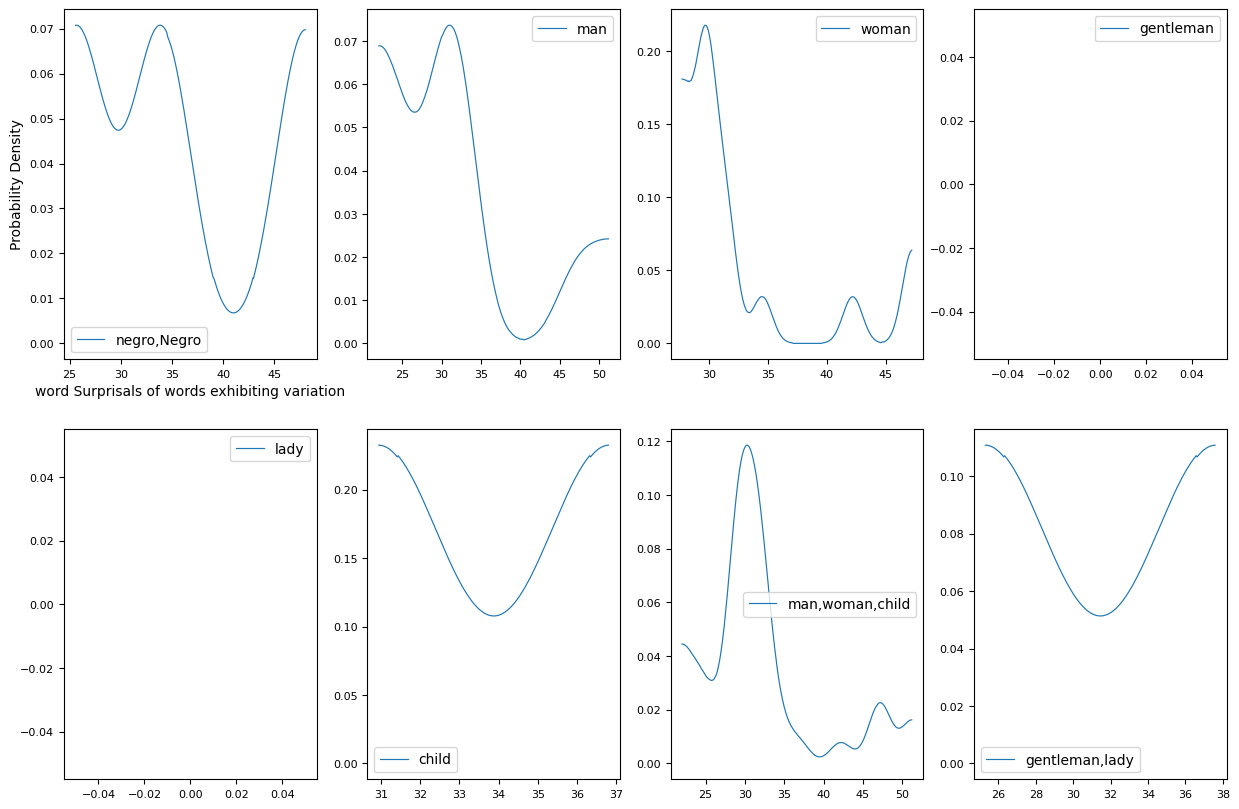

In [1052]:
variation = "a-"
surprisals = defaultdict(list)  # {speakers: list of surprisals (each corresponding to a word demonstrating the variation)}

# get the surprisals ... 
S = [["negro", "Negro"], ["man"], ["woman"], ["gentleman"], ["lady"], ["child"], ["man", "woman", "child"], ["gentleman", "lady", ]]
for speakers in S:
    
    # get the quotation set, 'i' of interest
    r_ = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False), "AvNLL"]
    lb, ub = get_hdi(r_, hdi=0.95)
    i_of_interest = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False) & (quotes.loc[:,"AvNLL"] > lb) & (quotes.loc[:,"AvNLL"] < ub), 'i']

    count_all
    for i in tqdm(i_of_interest):

        try:

            # get probability chain corresponding to quote
            c = np.array(chains[i])
            
            q = quotes.loc[i, 'quote']
            s  = q[1:-1]
            
            # convert quote to words           
            words = quotes.loc[i, 'words']

            tokens = np.array(tokenizer.tokenize(s))
            words_indices, N = get_words_indices(words, tokens)

            if quotes.loc[i, f"{variation}_count"] > 0:
                
                for instance in quotes.loc[i, variation]:

                    # the instance may occur multiple times
                    for lb, ub in gen_indices(words, get_words(instance)):

                        # add surprisals for each word in the instance
                        for i in range(lb,ub):
                        
                            word_indices = words_indices[i]  # token and chain indices corresponding to word
                            surprisals[",".join(speakers)].append(-np.log(c[word_indices]).sum())

                    # check
                    # print(instance)
                    
        except:
            if len(quotes.loc[i, variation]) > 0:
                # print(q)
                pass

# Get the MAS and newMAS for n-word, where newMAS due to the absence of words showing the variation in question
speakers = ['negro', "Negro"]
r_ = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False), "AvNLL"]
lb, ub = get_hdi(r_, hdi=0.95)
i_of_interest = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False) & (quotes.loc[:,"AvNLL"] > lb) & (quotes.loc[:,"AvNLL"] < ub), 'i']

MAS_negro = quotes.loc[i_of_interest, "sumNLL"].sum() / quotes.loc[i_of_interest, "N"].sum()
newMAS_negro = (quotes.loc[i_of_interest, "sumNLL"].sum() - sum(surprisals['negro,Negro'])) / (quotes.loc[i_of_interest, "N"].sum() - len(surprisals['negro,Negro']))
print('negro,Negro', MAS_negro, newMAS_negro)

# get importance:
for speakers in S[1:]:
    
    r_ = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False), "AvNLL"]
    lb, ub = get_hdi(r_, hdi=0.95)
    i_of_interest = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False) & (quotes.loc[:,"AvNLL"] > lb) & (quotes.loc[:,"AvNLL"] < ub), 'i']

    MAS = quotes.loc[i_of_interest, "sumNLL"].sum() / quotes.loc[i_of_interest, "N"].sum()
    newMAS = (quotes.loc[i_of_interest, "sumNLL"].sum() - sum(surprisals[",".join(speakers)])) / (quotes.loc[i_of_interest, "N"].sum() - len(surprisals[",".join(speakers)]))
    
    importance = 100*((MAS_negro - newMAS_negro) - (MAS - newMAS)) / (MAS_negro - MAS)
    print(speakers, importance)

# get plots of collected Surprisals
x,y = 2,4
fig, axs = plt.subplots(x, y, figsize=(15, 10))
for i, speakers in enumerate(S):

    row = i // y
    col = i - (row)*y
    az.plot_kde(np.array(surprisals[",".join(speakers)]), ax=axs[row, col], label=",".join(speakers), textsize=8, );

    if row==0 and col==0:
        axs[row, col].set_xlabel("word Surprisals of words exhibiting variation")
        axs[row, col].set_ylabel("Probability Density")


#### news


In [482]:
Q_news['a-ing'] = Q_news['quote'].progress_map(lambda quote: re.findall(p, quote))
Q_news['a-ing_count'] = Q_news['a-ing'].progress_map(lambda x: len(x))

100%|███████████████████████████████████████████████████████████████████████████████████████| 1524/1524 [00:00<00:00, 729194.54it/s]


In [483]:
list(Q_news.loc[Q_news.loc[:,'a-ing_count']>0, "quote"])

['I have been a-boarding.']

In [484]:
# get 95\% HDI
r_ = Q_news.loc[:, metric]
lb, ub = get_hdi(r_, hdi=0.95)
i_of_interest = Q_news.loc[(Q_news.loc[:,metric] > lb) & (Q_news.loc[:,metric] < ub), 'i']

print('news+negro', 100*sum(Q_news.loc[(Q_news.loc[:, "i"].isin(i_of_interest)) , 'a-ing_count']) / len(i_of_interest), sum(Q_news.loc[(Q_news.loc[:, "i"].isin(i_of_interest)) , 'a-ing_count']), len(i_of_interest) )


news+negro 0.06915629322268327 1 1446


## z -> d

wasn't, hasn't, artisans, prison (Z AH0 N) -> wadn't: i.e, find index of 's' in text that corresponds to (Z AH0 N), and replace 's' with 'd'

prisoner (Z AH0 N) -> pridner; i.e., find index of s corresponding to (Z AH0 N), and replace everything btween 's' and 'n' with 'dn'

doesn't (AH1 Z AH0 N) -> dudn't; i.e., find index of 'oesn' in text which is (AH1 Z AH0 N), and replace 'oesn' with 'udn'

business (Z N) --> bidness, ; find 's' that  corresponds to (Z N), and replace everything between 's' and 'n' with 'dn'
SSN, SN



In [521]:
# Load the CMU pronunciation dictionary
import requests
lines = requests.get("http://svn.code.sf.net/p/cmusphinx/code/trunk/cmudict/cmudict-0.7b").text.splitlines()

# ignore eveything up the 'A  AH0'
lines = lines[lines.index('A  AH0'):]

In [526]:
# load unix dict
with open("/usr/share/dict/words", "r") as f:
    en_words = [x.strip("\n") for x in f.readlines()]

In [527]:
# expand en_words with DH variants
en_words += [line.split(" ")[0].lower() for line in lines] + [line.split(" ")[0].lower().capitalize() for line in lines]
en_words = set(en_words)

In [528]:
# get all words with DH
ZN = [line for line in lines if " Z AH0 N " in line] + [line for line in lines if " Z N " in line]
ZN

['ARKANSANS  AA2 R K AE1 N Z AH0 N Z',
 'ARTISANS  AA1 R T AH0 Z AH0 N Z',
 'BESANT  B EH1 Z AH0 N T',
 'BEZANSON  B EH1 Z AH0 N S AH0 N',
 'BIPARTISANSHIP  B AY0 P AA1 R T AH0 Z AH0 N SH IH2 P',
 'BOSENDORFER  B OW1 Z AH0 N D AO2 R F ER0',
 'BRAZENLY  B R EY1 Z AH0 N L IY0',
 'BRAZENNESS  B R EY1 Z AH0 N AH0 S',
 'BYZANTINE  B IH1 Z AH0 N T AY2 N',
 'BYZANTINE(1)  B IH1 Z AH0 N T IY2 N',
 'CAZENOVE  K AE1 Z AH0 N OW2 V',
 'CHAZANOFF  CH AE1 Z AH0 N AO0 F',
 'CHRZANOWSKI  CH ER2 Z AH0 N AO1 F S K IY0',
 "CITIZEN'S  S IH1 T AH0 Z AH0 N Z",
 'CITIZENRY  S IH1 T IH0 Z AH0 N R IY0',
 "CITIZENRY'S  S IH1 T IH0 Z AH0 N R IY0 Z",
 'CITIZENS  S IH1 T AH0 Z AH0 N Z',
 'CITIZENS(1)  S IH1 T IH0 Z AH0 N Z',
 "CITIZENS'  S IH1 T IH0 Z AH0 N Z",
 'CITIZENSHIP  S IH1 T IH0 Z AH0 N SH IH2 P',
 'COGNIZANCE  K AA1 G N AH0 Z AH0 N S',
 'COGNIZANT  K AA1 G N AH0 Z AH0 N T',
 "COUSIN'S  K AH1 Z AH0 N Z",
 'COUSINS  K AH1 Z AH0 N Z',
 'COUZENS  K UW1 Z AH0 N Z',
 'COZZENS  K AA1 Z AH0 N Z',
 'DEFEASANCE  D

In [529]:
# Expand DH to include variants of words where ING is replaced with IN'
display([" ".join([x.split(" ")[0][:-1] + "'"] + x.split(" ")[1:]) for x in ZN if x.split(" ")[0][-3:]=="ING"])
ZN += [" ".join([x.split(" ")[0][:-1] + "'"] + x.split(" ")[1:]) for x in ZN if x.split(" ")[0][-3:]=="ING"]

["IMPRISONIN'  IH2 M P R IH1 Z AH0 N IH0 NG",
 "POISONIN'  P OY1 Z AH0 N IH0 NG",
 "REASONIN'  R IY1 Z AH0 N IH0 NG",
 "RESONATIN'  R EH1 Z AH0 N EY2 T IH0 NG",
 "SEASONIN'  S IY1 Z AH0 N IH0 NG",
 "UNREASONIN'  AH0 N R IY1 Z N IH0 NG"]

In [232]:
# build a word list variants, replacing th letters corresponding to DH sound, with ...
d = []
for line in DH:

    word = line.split(" ")[0]
    ARPAbet_rep = line.split(" ")[1:]

    # get indices of 'th' positions in word
    th_indices = find_all_indices(word, 'TH')

    # order of occurrence of DH or TH sounds in ARPAbet representation
    th_sounds = [x for x in ARPAbet_rep if x == "DH" or x =='TH']

    # convert th letters corresponding to DH sound, as ...
    var1 = word  # th sounds like DH -> d
    var2 = word  ## th sounds like DH -> dd
    for i, th_sound in zip(th_indices, th_sounds):
        if th_sound == 'DH':
            var1 = var1[:i] + 'D' + var1[i+2:]  #this -> dis
            d.append(var1)
            var2 = var2[:i] + 'DD' + var2[i+2:]  #with -> widd
            d.append(var2)

# add variant, replacing OTH letters corresponding to "AH1 DH" sound, with "UDD"
for line in DH:

    word = line.split(" ")[0]
    ARPAbet_rep = line.split(" ")[1:]

    if len(list(gen_indices(ARPAbet_rep, ['AH1', 'DH'])))>0:

        # get indices of 'oth' positions in word
        oth_indices = find_all_indices(word, 'OTH')
    
        # order of occurrence of DH or 'TH or AH1 DH' sounds in ARPAbet representation
        th_sounds = []

        last_sound = None
        for sound in ARPAbet_rep:
            if sound == "DH" and last_sound == "AH1":
                th_sounds.append('AH1 DH')
            elif sound == "TH" or sound == "DH":
                th_sounds.append(sound)
            last_sound = sound
            
        # convert oth letters corresponding to AH1 DH sound, as ...
        var1 = word  # th sounds like AH1 DH -> UDD
        for i, th_sound in zip(oth_indices, th_sounds):
            if th_sound == 'AH1 DH':
                var1 = var1[:i] + 'UDD' + var1[i+len('oth'):]  #this -> dis
                d.append(var1)

# add variant, replacing OTH letters corresponding to "AA1 DH" sound, with "ARD"
for line in DH:

    word = line.split(" ")[0]
    ARPAbet_rep = line.split(" ")[1:]

    if len(list(gen_indices(ARPAbet_rep, ['AA1', 'DH'])))>0:

        # get indices of 'oth' positions in word
        ath_indices = find_all_indices(word, 'ATH')
    
        # order of occurrence of DH or 'TH or AH1 DH' sounds in ARPAbet representation
        th_sounds = []

        last_sound = None
        for sound in ARPAbet_rep:
            if sound == "DH" and last_sound == "AA1":
                th_sounds.append('AA1 DH')
            elif sound == "TH" or sound == "DH":
                th_sounds.append(sound)
            last_sound = sound
            
        # convert ath letters corresponding to AA1 DH sound, as ...
        var1 = word
        for i, th_sound in zip(ath_indices, th_sounds):
            if th_sound == 'AA1 DH':
                var1 = var1[:i] + 'ARD' + var1[i+len('ath'):]  #father -> farder
                d.append(var1)

# add variant, replacing OTH letters corresponding to "AA2 DH" sound, with "ARD"
for line in DH:

    word = line.split(" ")[0]
    ARPAbet_rep = line.split(" ")[1:]

    if len(list(gen_indices(ARPAbet_rep, ['AA2', 'DH'])))>0:

        # get indices of 'oth' positions in word
        ath_indices = find_all_indices(word, 'ATH')
    
        # order of occurrence of DH or 'TH or AH1 DH' sounds in ARPAbet representation
        th_sounds = []

        last_sound = None
        for sound in ARPAbet_rep:
            if sound == "DH" and last_sound == "AA2":
                th_sounds.append('AA2 DH')
            elif sound == "TH" or sound == "DH":
                th_sounds.append(sound)
            last_sound = sound
            
        # convert ath letters corresponding to AA1 DH sound, as ...
        var1 = word
        for i, th_sound in zip(ath_indices, th_sounds):
            if th_sound == 'AA2 DH':
                var1 = var1[:i] + 'ARD' + var1[i+len('ath'):]  #father -> farder
                d.append(var1)

# # add variants where v --> b or bb
# d += [x.replace('v', 'b') for x in d if 'v' in x]
# d += [x.replace('v', 'bb') for x in d if 'v' in x]

# lowercase
d = [x.lower() for x in d]       
            
# get uppercase variants
d += [x.capitalize() for x in d]

# remove instances present in en_words
print(len(d))
d = set([x for x in d if x not in en_words])
print(len(d))

True
1024
561


In [238]:
z.update(["bidness", "bidnessman", "bidnesswoman", "bidness's"])

In [239]:
"wadn't" in z

True

In [240]:
"idn't" in z

True

#### literature

# RQ4

In [841]:
S = [['negro', 'Negro'], ["man", "woman", "child"], ["professor"], ['judge'], ["teacher"], ['farmer'], ['hand']]


In [836]:
OmAS_lit_rq4 = {}

for speakers in S:
    
    # get 95% HDI wrt. speaker
    r_ = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False), "AvNLL"]
    lb, ub = get_hdi(r_, hdi=0.95)
    i_of_interest = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False) & (quotes.loc[:,"AvNLL"] > lb) & (quotes.loc[:,"AvNLL"] < ub), 'i']

    OmAS_lit_rq4[",".join(speakers)] = quotes.loc[quotes.loc[:, 'i'].isin(i_of_interest), 'AvNLL'].mean()
display(OmAS_lit_rq4)   


{'negro,Negro': 11.488999713230495,
 'professor': 10.389646045367483,
 'judge': 10.397298993868308,
 'teacher': 10.07158296214865,
 'farmer': 10.68204496732737,
 'hand': 10.476473114240191,
 'man,woman,child': 10.48914714213429}

## non--standard contractions

rates

In [837]:
for speakers in S:

    # get 95\% HDI
    r_ = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False), "AvNLL"]
    lb, ub = get_hdi(r_, hdi=0.95)
    i_of_interest = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False) & (quotes.loc[:,"AvNLL"] > lb) & (quotes.loc[:,"AvNLL"] < ub), 'i']
    
    print(speakers, 100*sum(quotes.loc[(quotes.loc[:, "i"].isin(i_of_interest)) , 'elision_count']) / len(i_of_interest), sum(quotes.loc[(quotes.loc[:, "i"].isin(i_of_interest)) , 'elision_count']), len(i_of_interest) )
    

['negro', 'Negro'] 65.89147286821705 510 774
['professor'] 7.317073170731708 54 738
['judge'] 9.8687963491158 173 1753
['teacher'] 16.143497757847534 36 223
['farmer'] 26.0 91 350
['hand'] 19.349215572341663 666 3442
['man', 'woman', 'child'] 21.25110682848065 4080 19199


contribution to difference in AvNLL

In [842]:
contribs = {}
for speakers in S:

    print(speakers)
    
    # get the quotation set, 'i' of interest
    r_ = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False), "AvNLL"]
    lb, ub = get_hdi(r_, hdi=0.95)
    i_of_interest = quotes.loc[(quotes.loc[:,'speaker'].isin(speakers)==True) & (quotes.loc[:,"AvNLL"].isna()==False) & (quotes.loc[:,"AvNLL"] > lb) & (quotes.loc[:,"AvNLL"] < ub), 'i']

    # collect the sum of surprisals for matching variations
    surprisal = 0  # records total surprisal contribution due to variation under consideraiton
    count_all = 0  # keeps count of all words in quotation set
    for i in tqdm(i_of_interest):
        
        try:

            # get probability chain corresponding to quote
            c = np.array(chains[i])
            
            q = quotes.loc[i, 'quote']
            s  = q[1:-1]
            
            # convert quote to words           
            words = get_words(s)
            count_all += len(words)

            tokens = np.array(tokenizer.tokenize(s))
            words_indices, N = get_words_indices(words, tokens)

            # get matches wrt., variation type of interest
            if quotes.loc[i, 'elision_count'] > 0:
                
                for word in quotes.loc[i, 'elision']:
                                  
                    # add to surprisal
                    for lb, ub in gen_indices(words, [word]):
                        # get surprisal wrt., target string
                        for j in range(lb, ub): 
                            word_indices = words_indices[j]
                            surprisal += -np.log(c[word_indices]).sum()

                    # check! i.e., reassembling tokens according to word_indices yields the targetted string
                    check = []
                    for j in range(lb,ub): 
                        word_indices = words_indices[j]
                        check.append("".join(tokens[word_indices])[1:])  # remove 'Ġ'
                    # print(check, s)
                    
        except:
            pass

    contribs[",".join(speakers)] = surprisal / count_all
display(contribs)

## get importance:
# #E.g, n-word vs laborer
# [contrib(var, n-word) - contrib(var, norm)]/diff(n-word, norm) - [contrib(var, laborer) - contrib(var, norm)] / diff(laborer, norm)

for s in S[2:]:
    a = (contribs['negro,Negro'] - contribs['man,woman,child']) / (OmAS_lit_rq4['negro,Negro'] - OmAS_lit_rq4['man,woman,child'])
    b = (contribs[",".join(s)] - contribs['man,woman,child']) / (OmAS_lit_rq4[",".join(s)] - OmAS_lit_rq4['man,woman,child'])
    print(s, b)

['negro', 'Negro']


100%|█████████████████████████████████████████████████████████████████| 774/774 [00:00<00:00, 10473.31it/s]


['man', 'woman', 'child']


100%|█████████████████████████████████████████████████████████████| 19199/19199 [00:01<00:00, 13208.50it/s]


['professor']


100%|█████████████████████████████████████████████████████████████████| 738/738 [00:00<00:00, 11820.85it/s]


['judge']


100%|███████████████████████████████████████████████████████████████| 1753/1753 [00:00<00:00, 13245.90it/s]


['teacher']


100%|█████████████████████████████████████████████████████████████████| 223/223 [00:00<00:00, 10745.98it/s]


['farmer']


100%|██████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 9487.72it/s]


['hand']


100%|████████████████████████████████████████████████████████████████| 3442/3442 [00:00<00:00, 9008.58it/s]


{'negro,Negro': 1.2675974361562392,
 'man,woman,child': 0.4347477085944359,
 'professor': 0.13811424202904402,
 'judge': 0.1489282287459145,
 'teacher': 0.4212300049910043,
 'farmer': 0.5163495374892391,
 'hand': 0.2637492830187757}

['professor'] 2.9812080087980455
['judge'] 3.111869811689854
['teacher'] 0.0323727566955012
['farmer'] 0.42303135773108946
['hand'] 13.492034813596021
